In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from aging.behavior.syllables import relabel_by_usage
from toolz import valmap

In [2]:
earliest_mouse_age = 21  # days


def age(s):
    return ((s - s.min()).dt.days + earliest_mouse_age) / 7


def load_long_df(version=4, df_version=0):
    df = pd.read_parquet(
        f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/longtogeny_males_syllable_df_v{df_version:02d}.parquet"
    )
    df = relabel_by_usage(df, return_map=False)
    df["mouse_id"] = df["subject_name"].str[:5]
    df = df[~df["mouse_id"].str.lower().str.contains("c")]
    df = df[~df["mouse_id"].str.lower().str.contains("long")]
    ages = df.groupby("mouse_id", sort=False)['date'].transform(age)
    df["age"] = ages

    session_length = df.groupby("uuid")["timestamps"].max()
    remove_uuids = session_length[session_length < 600].index
    df = df[~df["uuid"].isin(remove_uuids)]

    usage_df = (
        df.query("onsets")
        .groupby(["age", "mouse_id", "uuid"])["relabeled_syllables"]
        .value_counts(normalize=True)
    )
    usage_df.name = "usage"
    usage_df = usage_df.reset_index()
    usage_mtx = usage_df.pivot_table(
        values="usage", columns="relabeled_syllables", index=["age", "mouse_id", "uuid"]
    ).fillna(0)

    # remove sessions with abnormally high syllable usage
    usage_mtx = usage_mtx[~(usage_mtx > 0.15).any(axis=1)]

    # remove sessions with abnormally few syllables used
    usage_mtx = usage_mtx[(usage_mtx > 0).sum(axis=1) > 20]
    return usage_mtx

In [3]:
df = load_long_df()
df = df.drop('05_02', level=1)

In [4]:
mouse_cov = {}
for mouse, _df in df.groupby('mouse_id'):
    cov = np.corrcoef(_df.T)
    mouse_cov[mouse] = cov

In [5]:
cov.shape

(55, 55)

In [6]:
g = sns.clustermap(
    mouse_cov["01_01"],
    method="complete",
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    figsize=(14, 14),
)

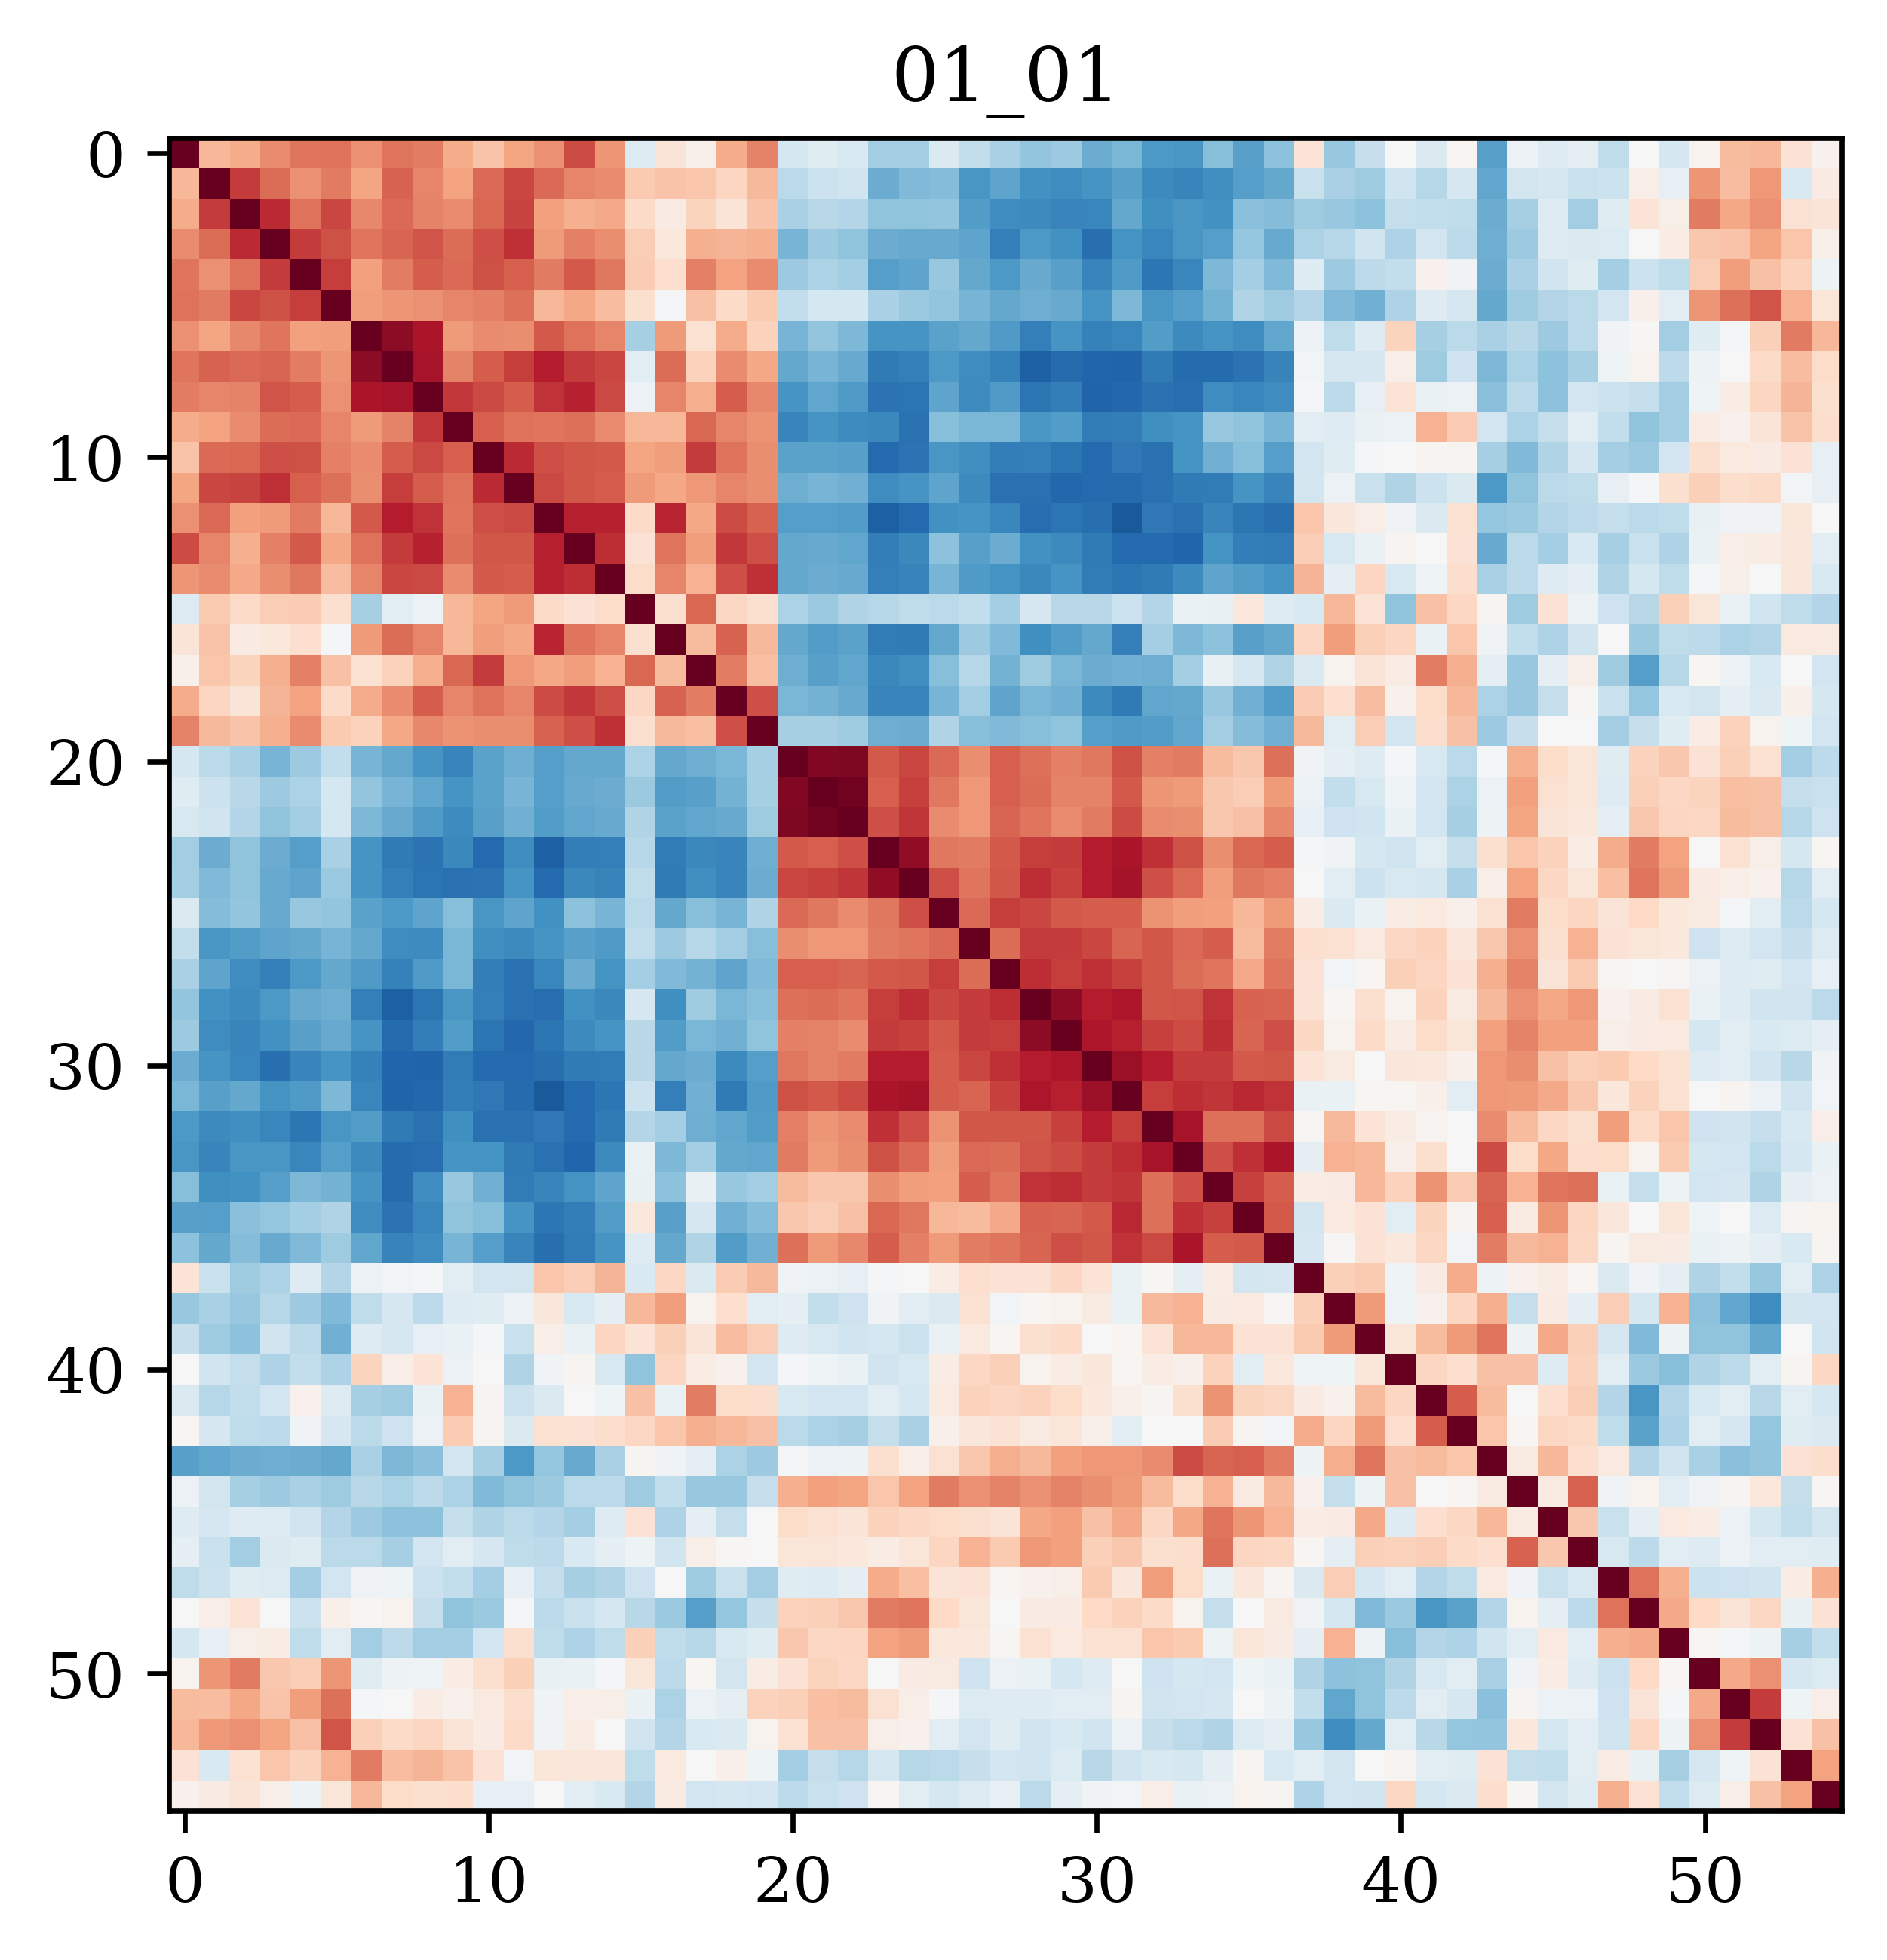

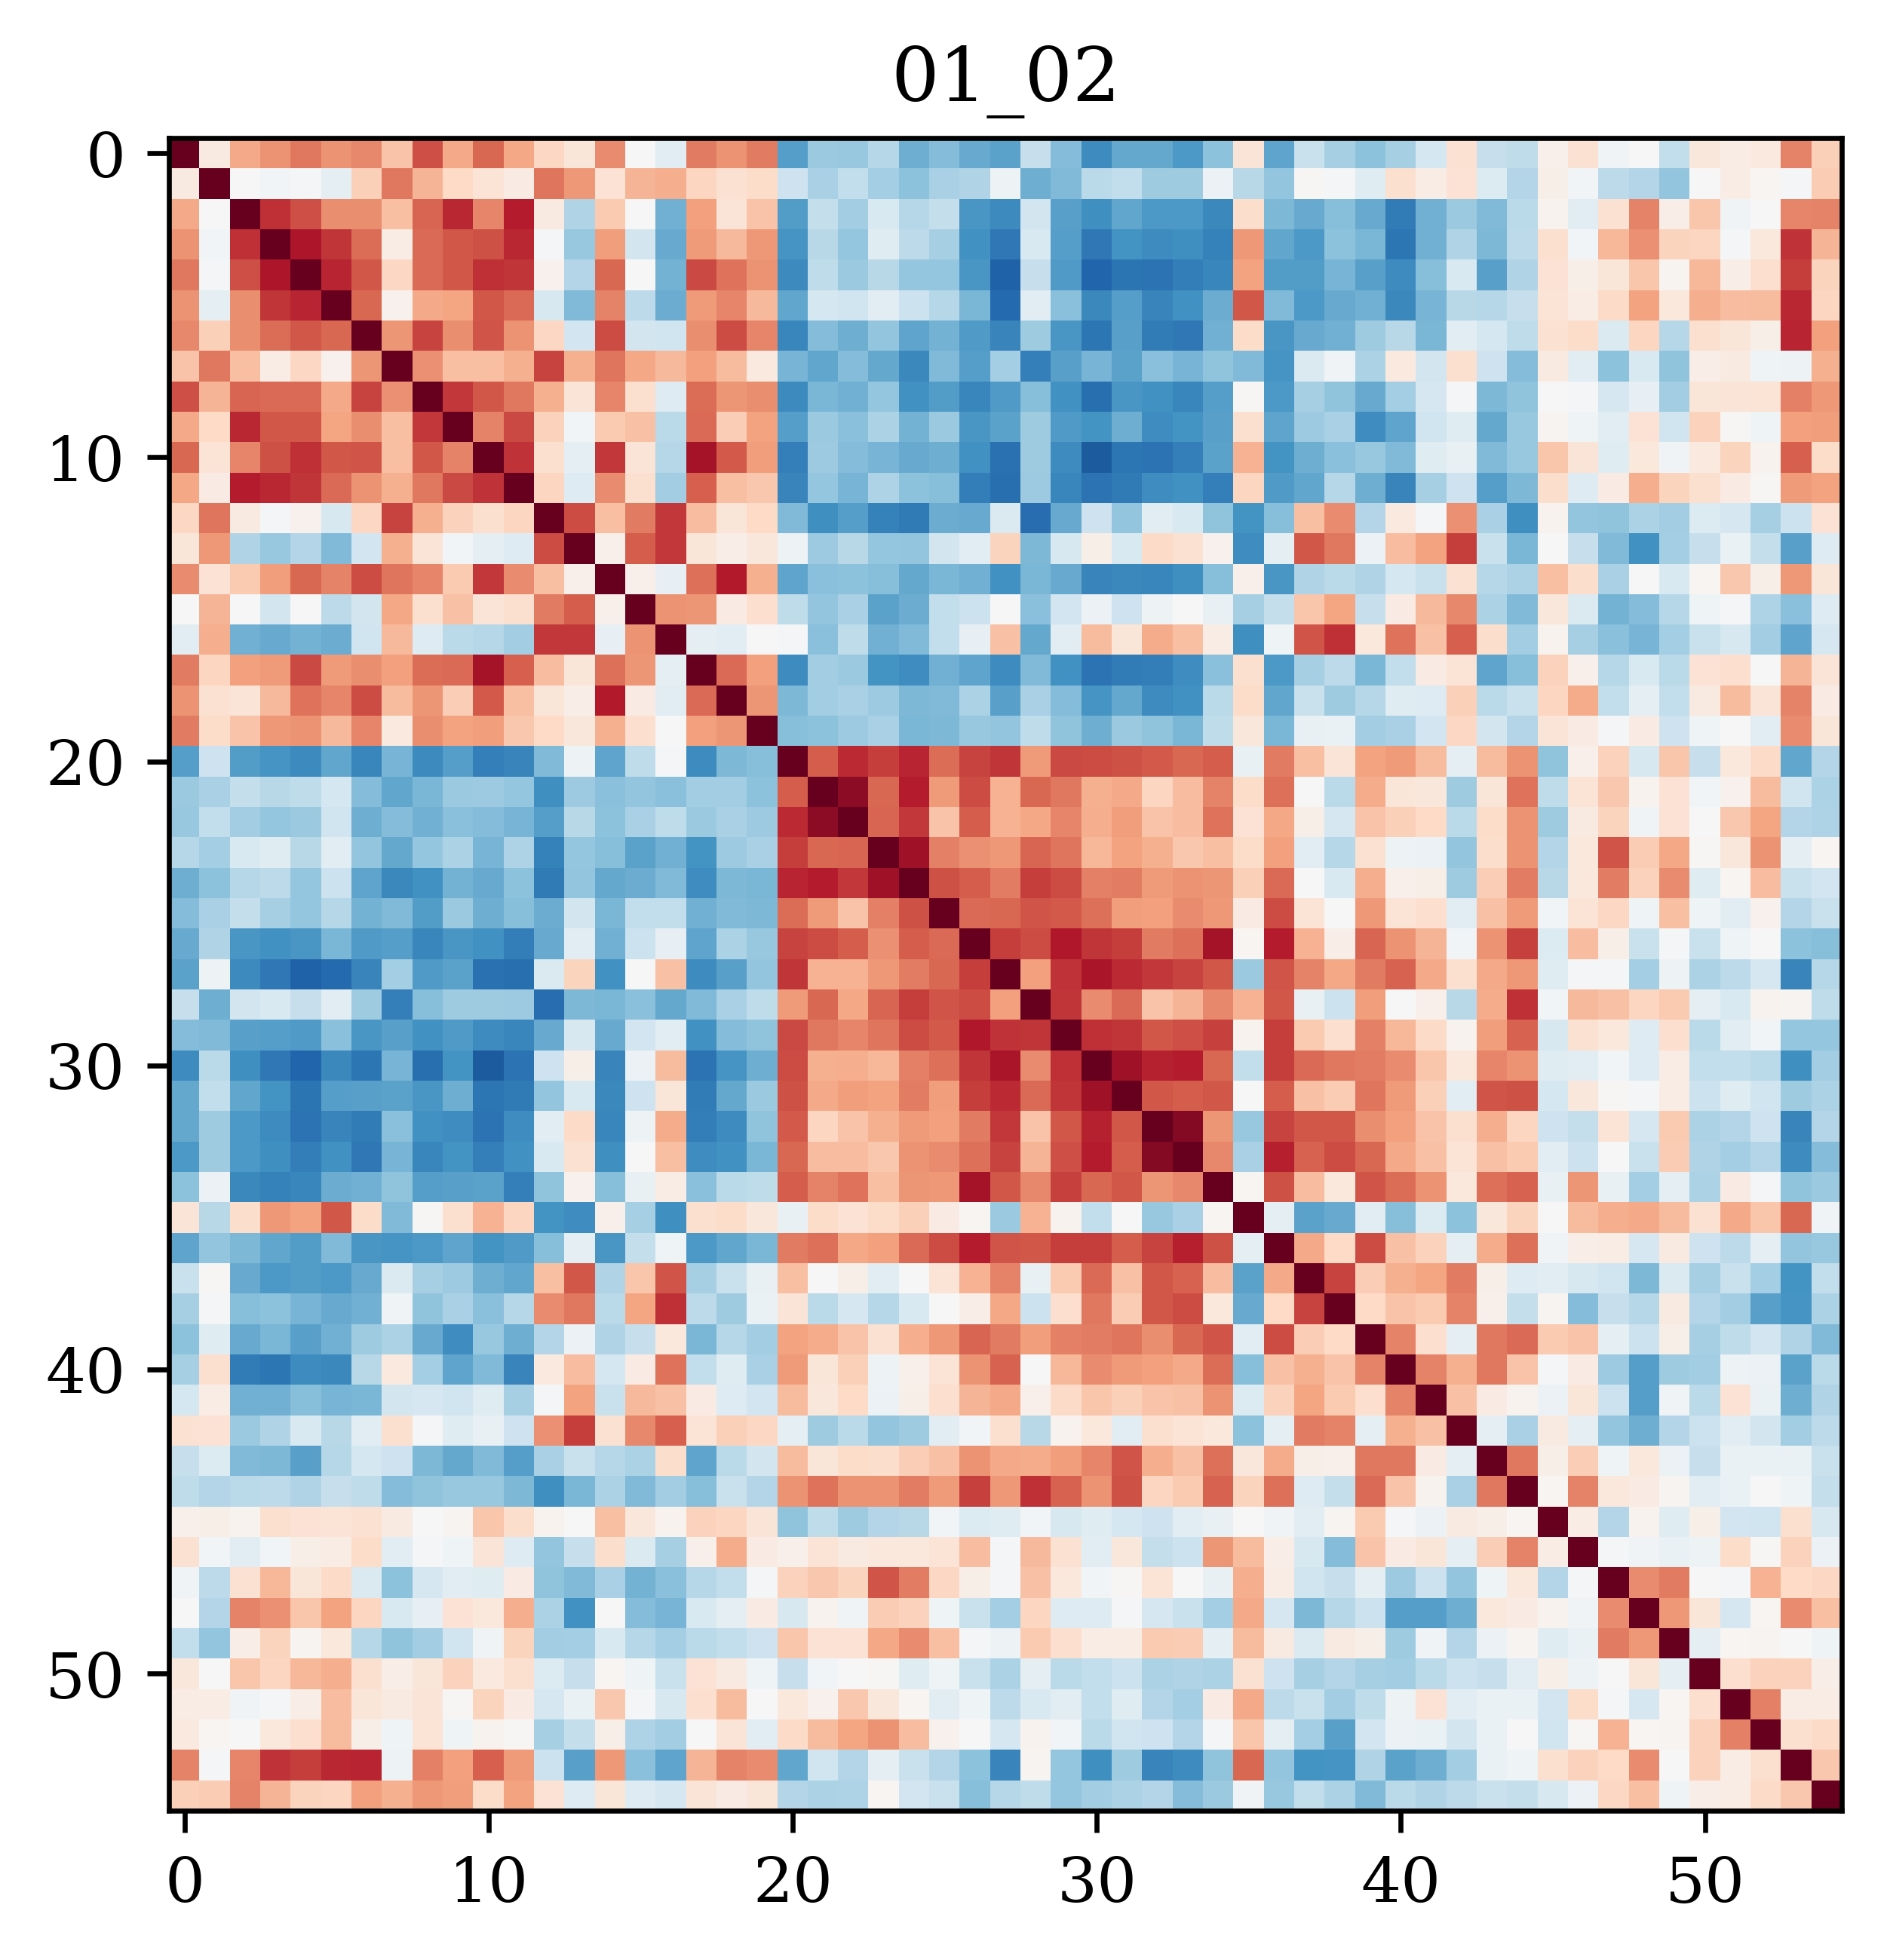

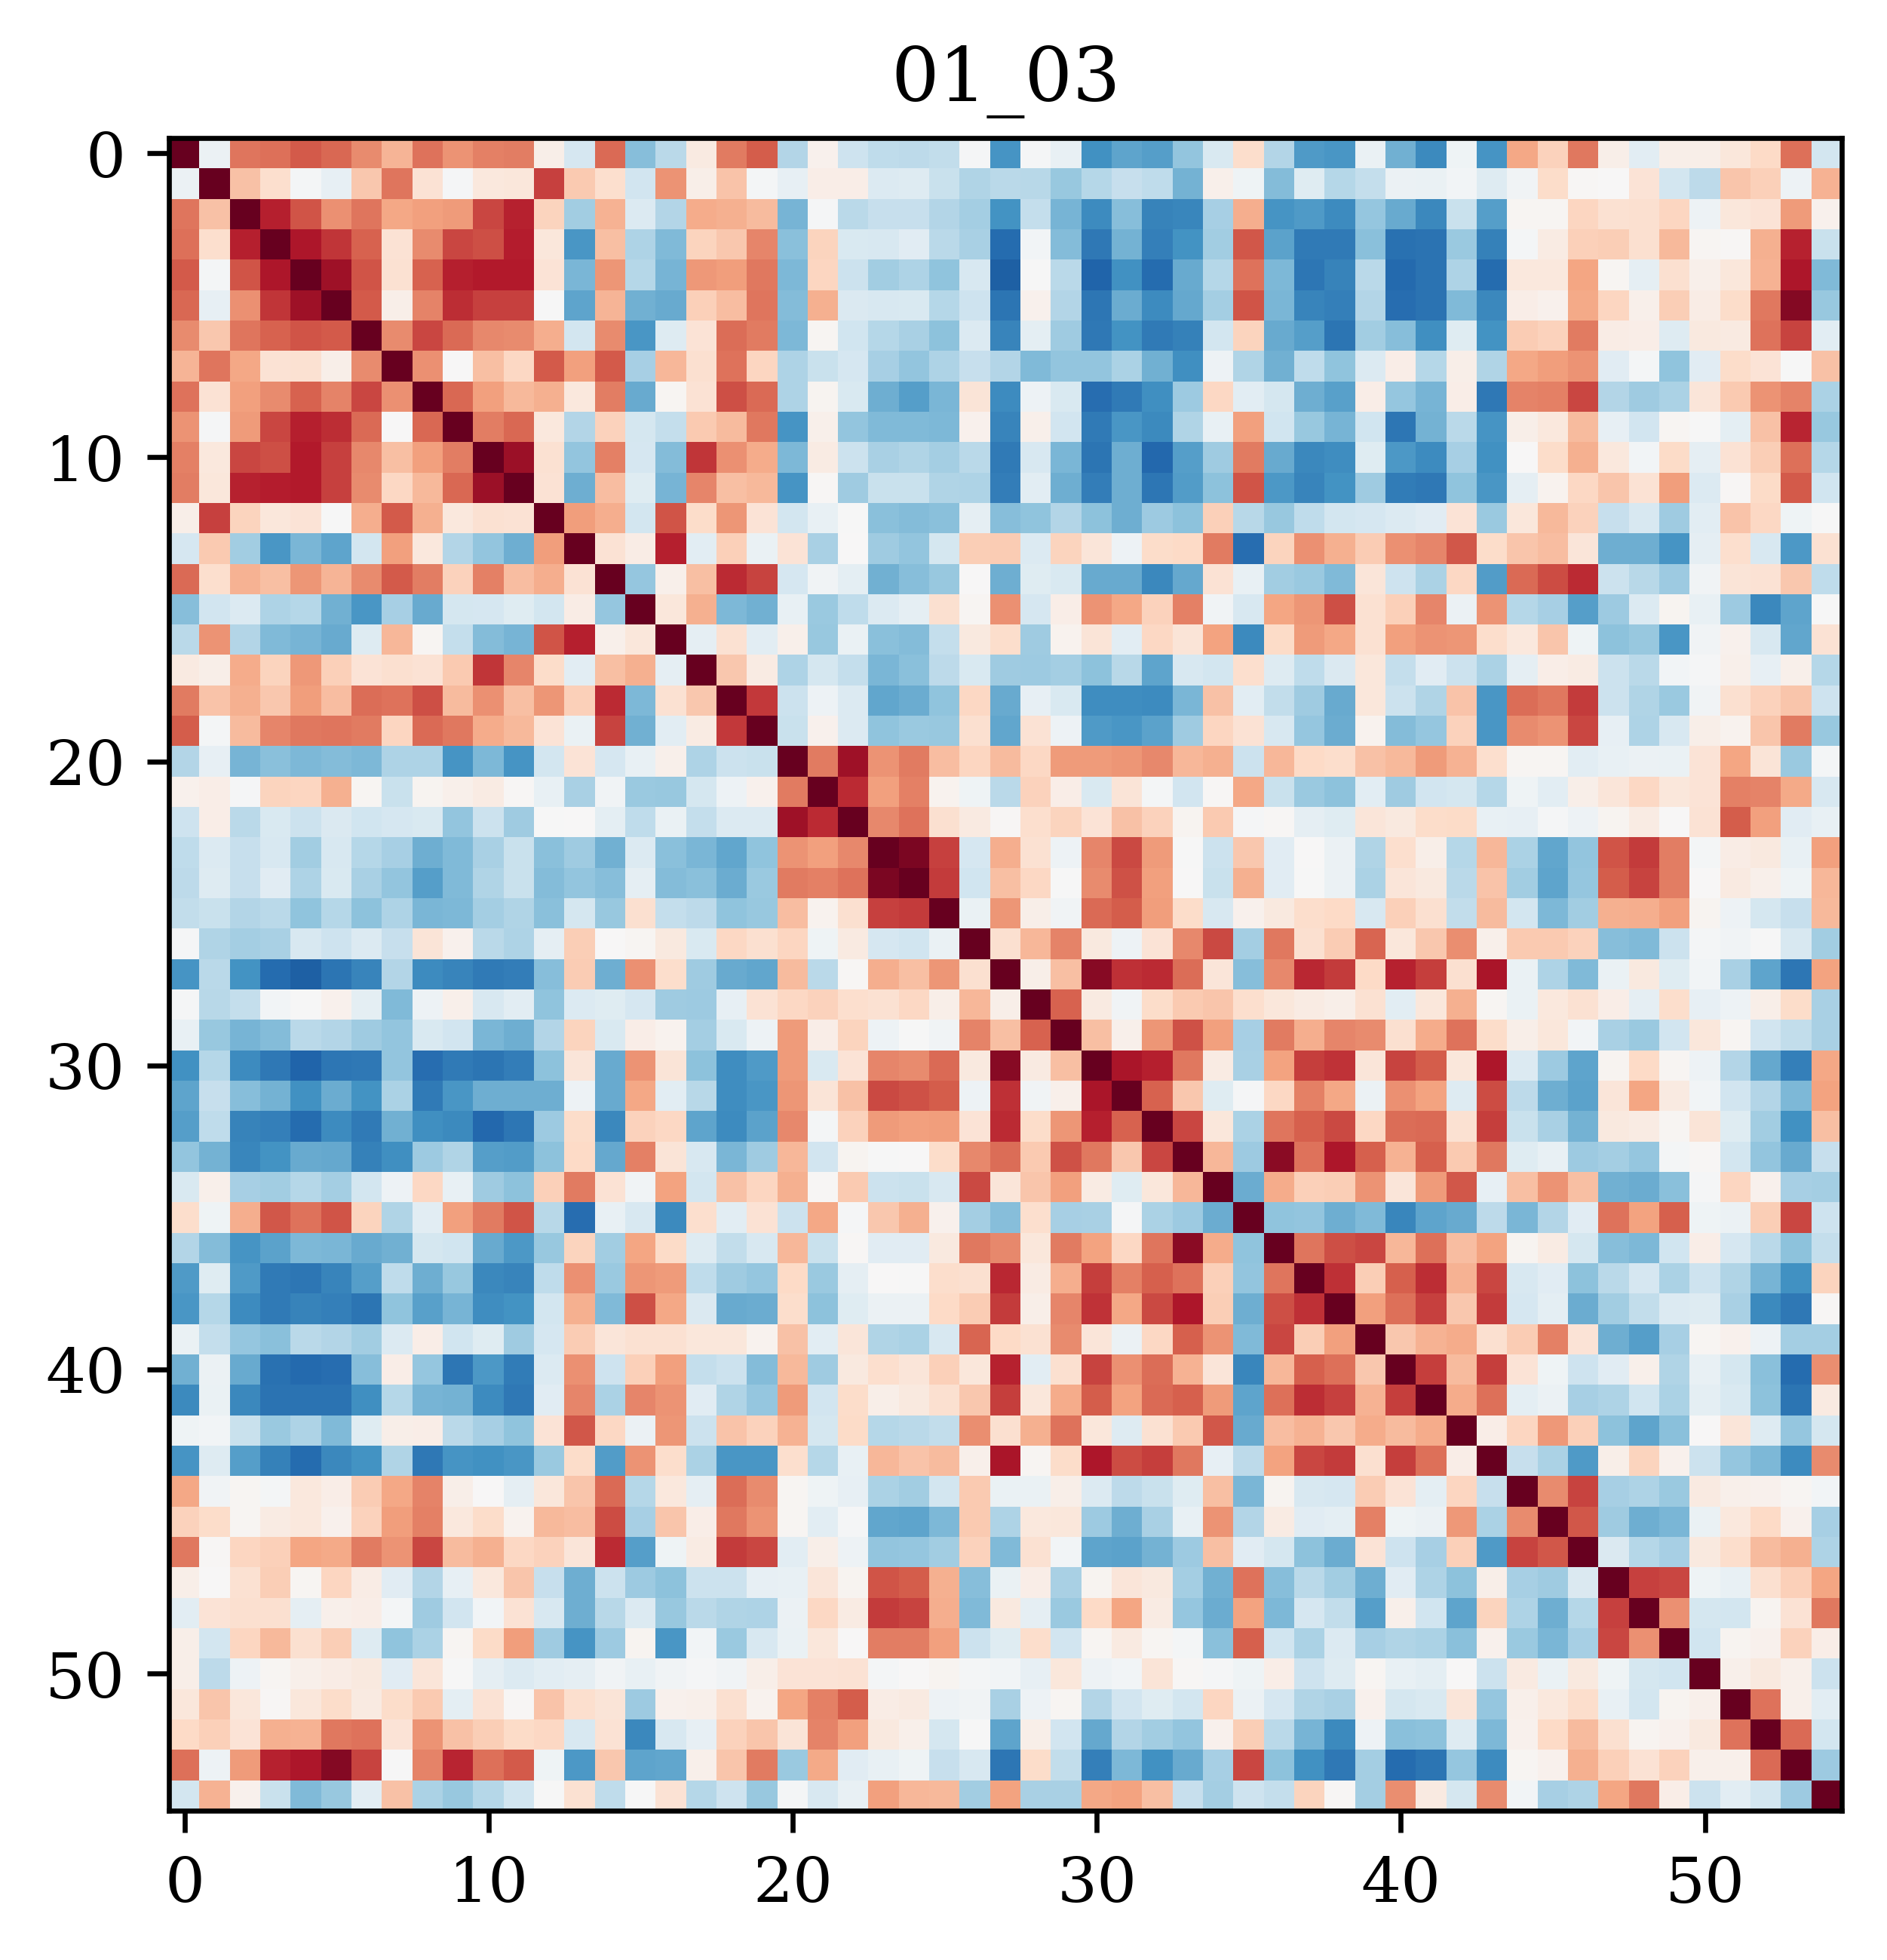

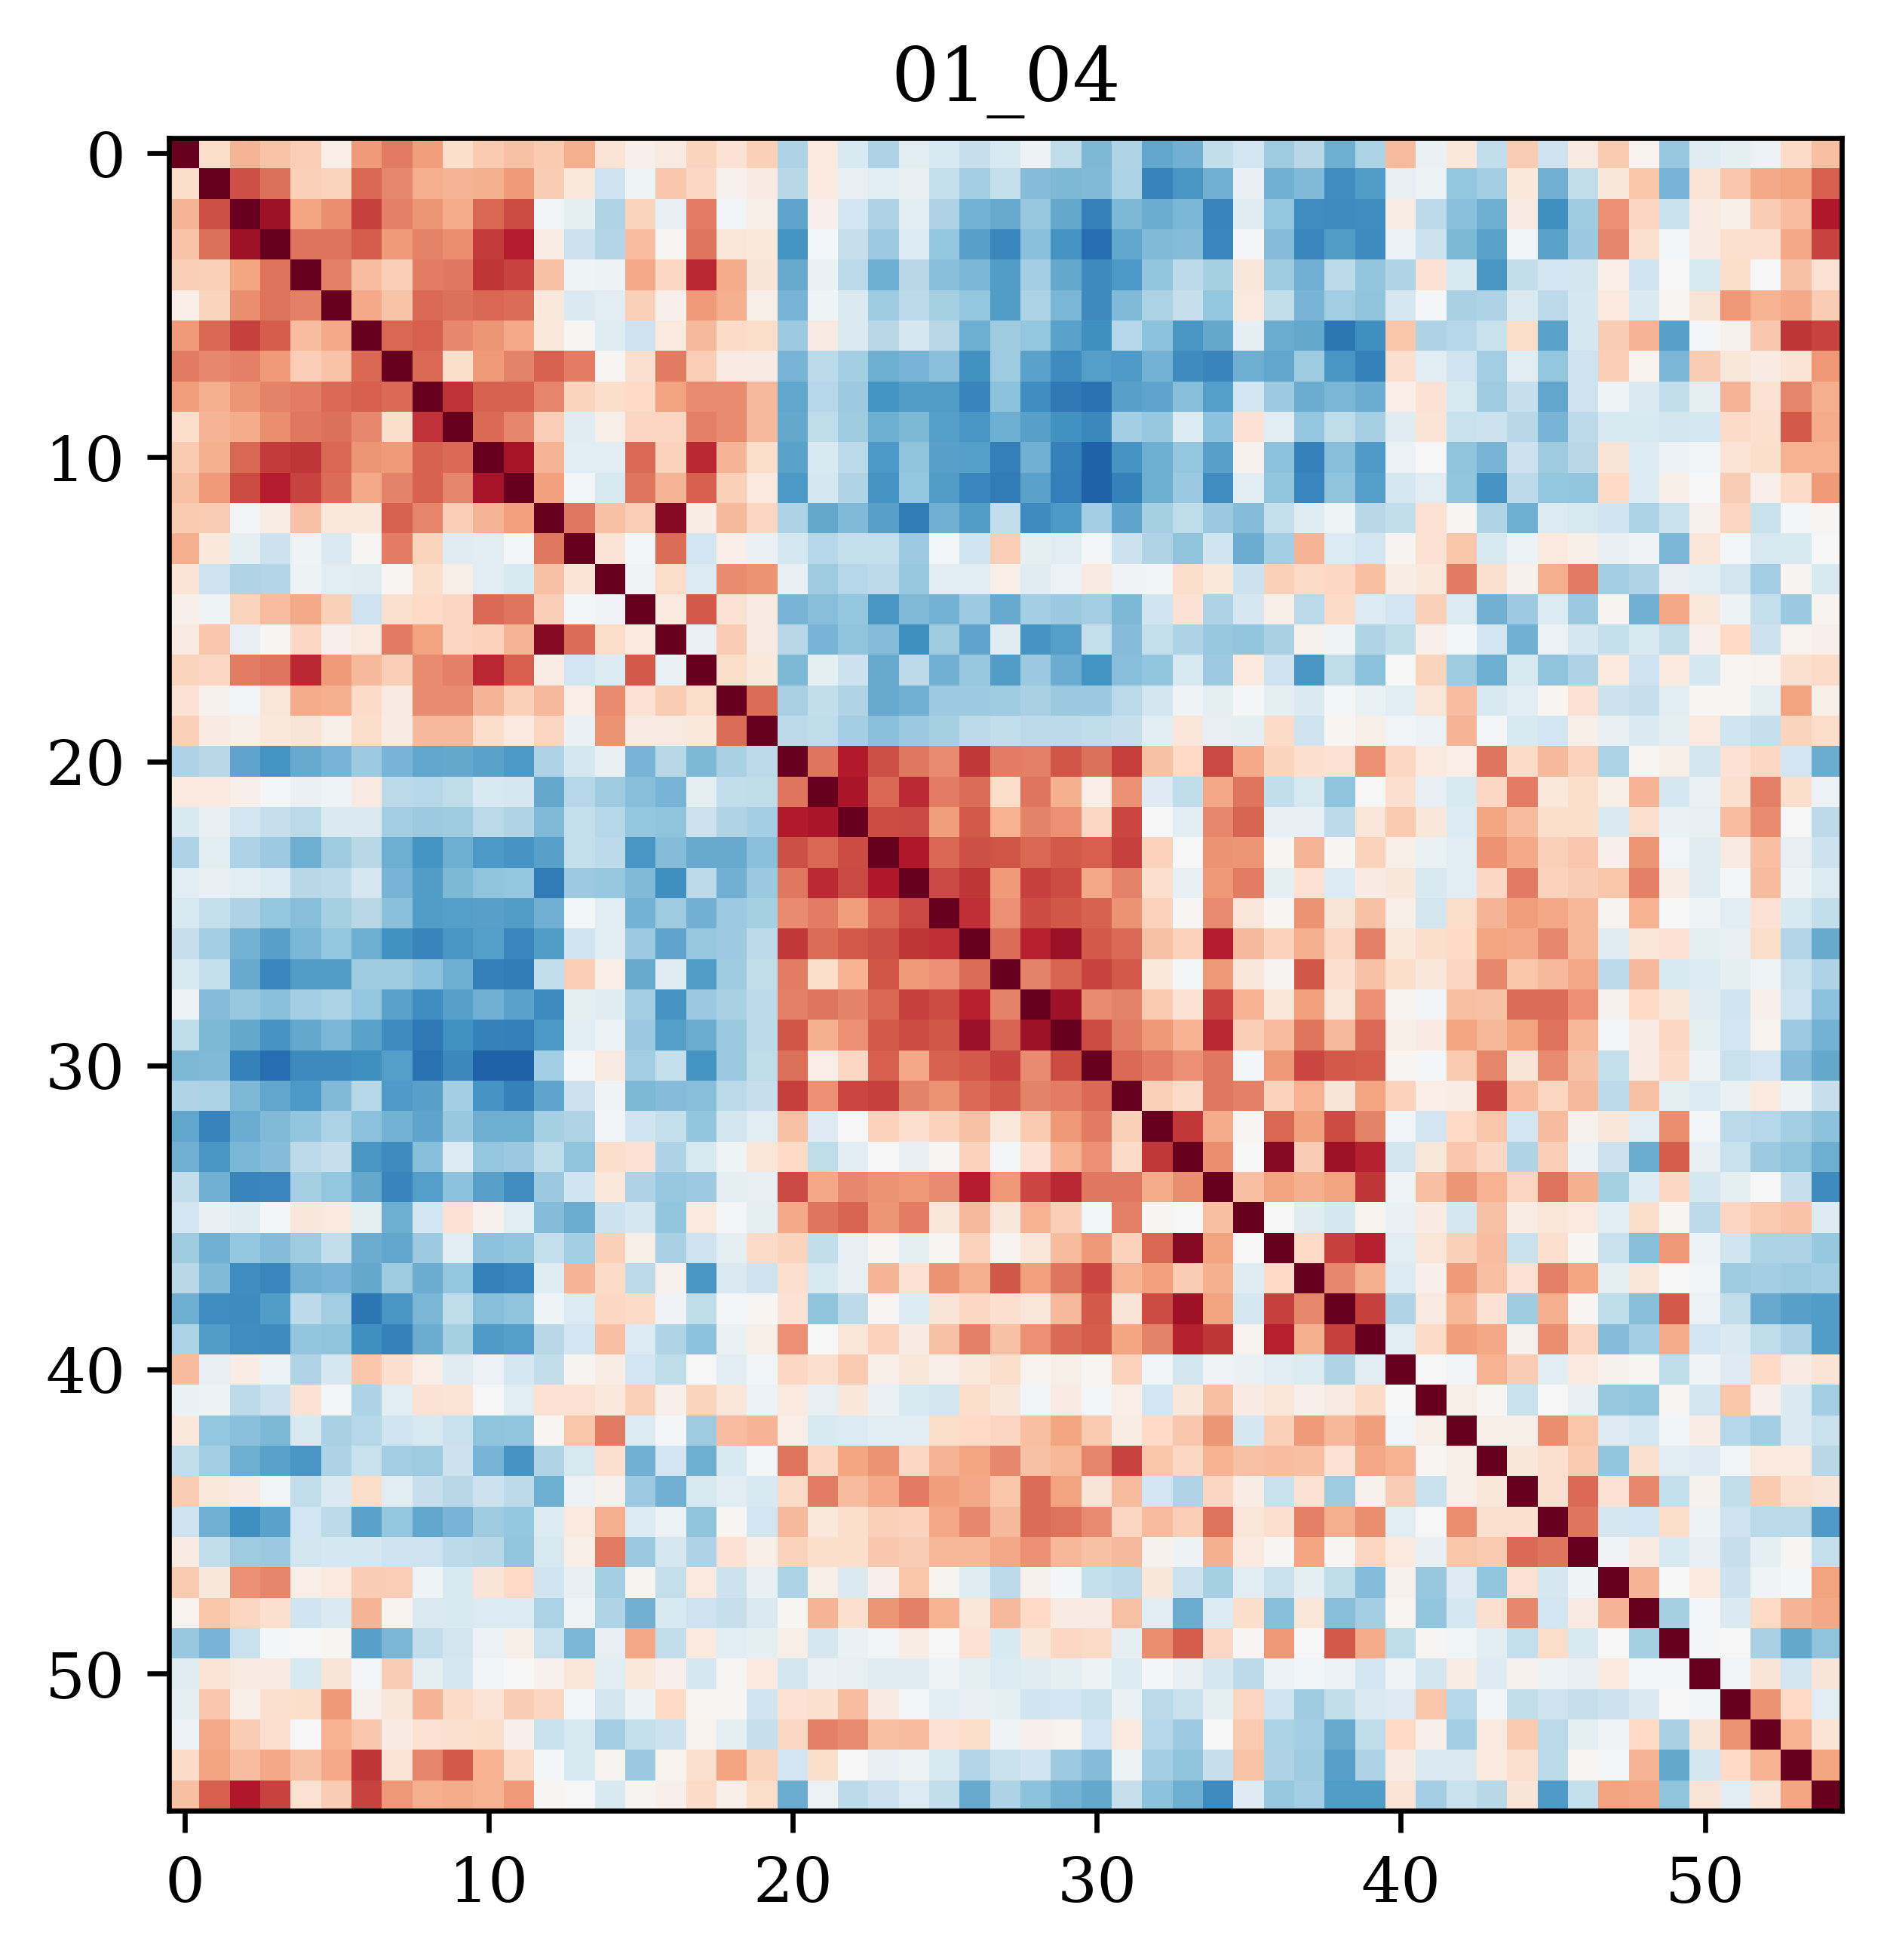

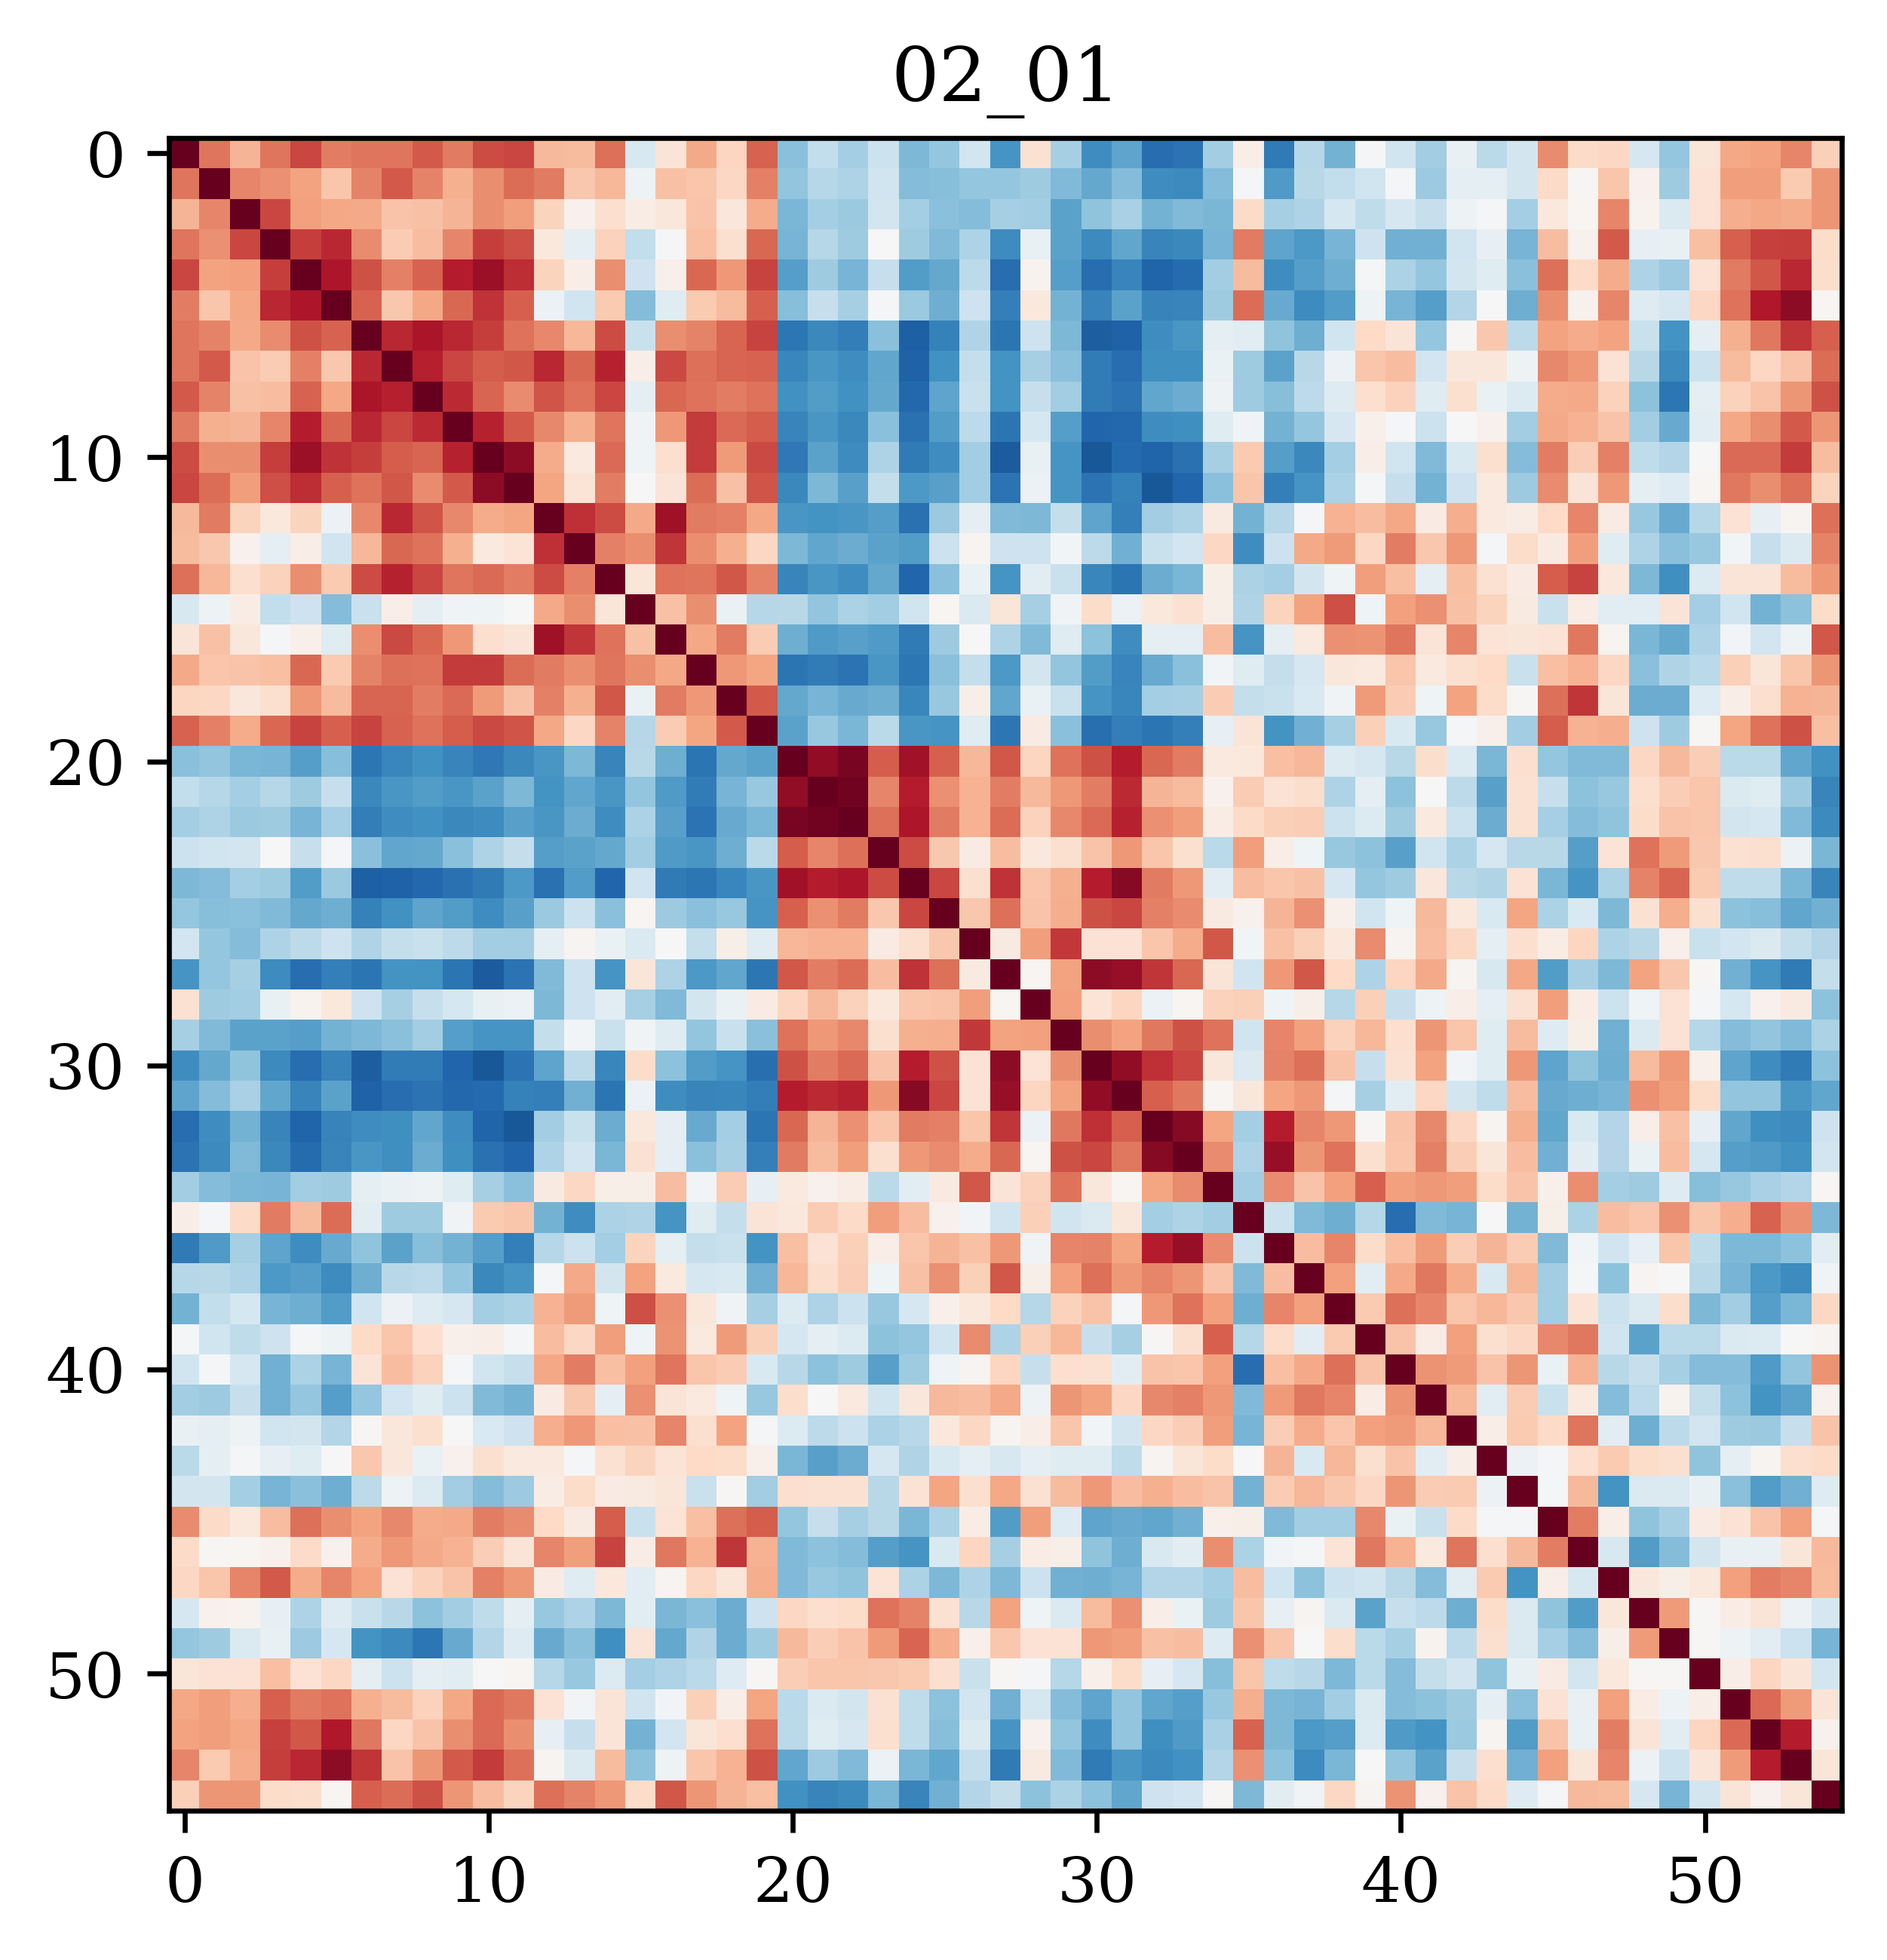

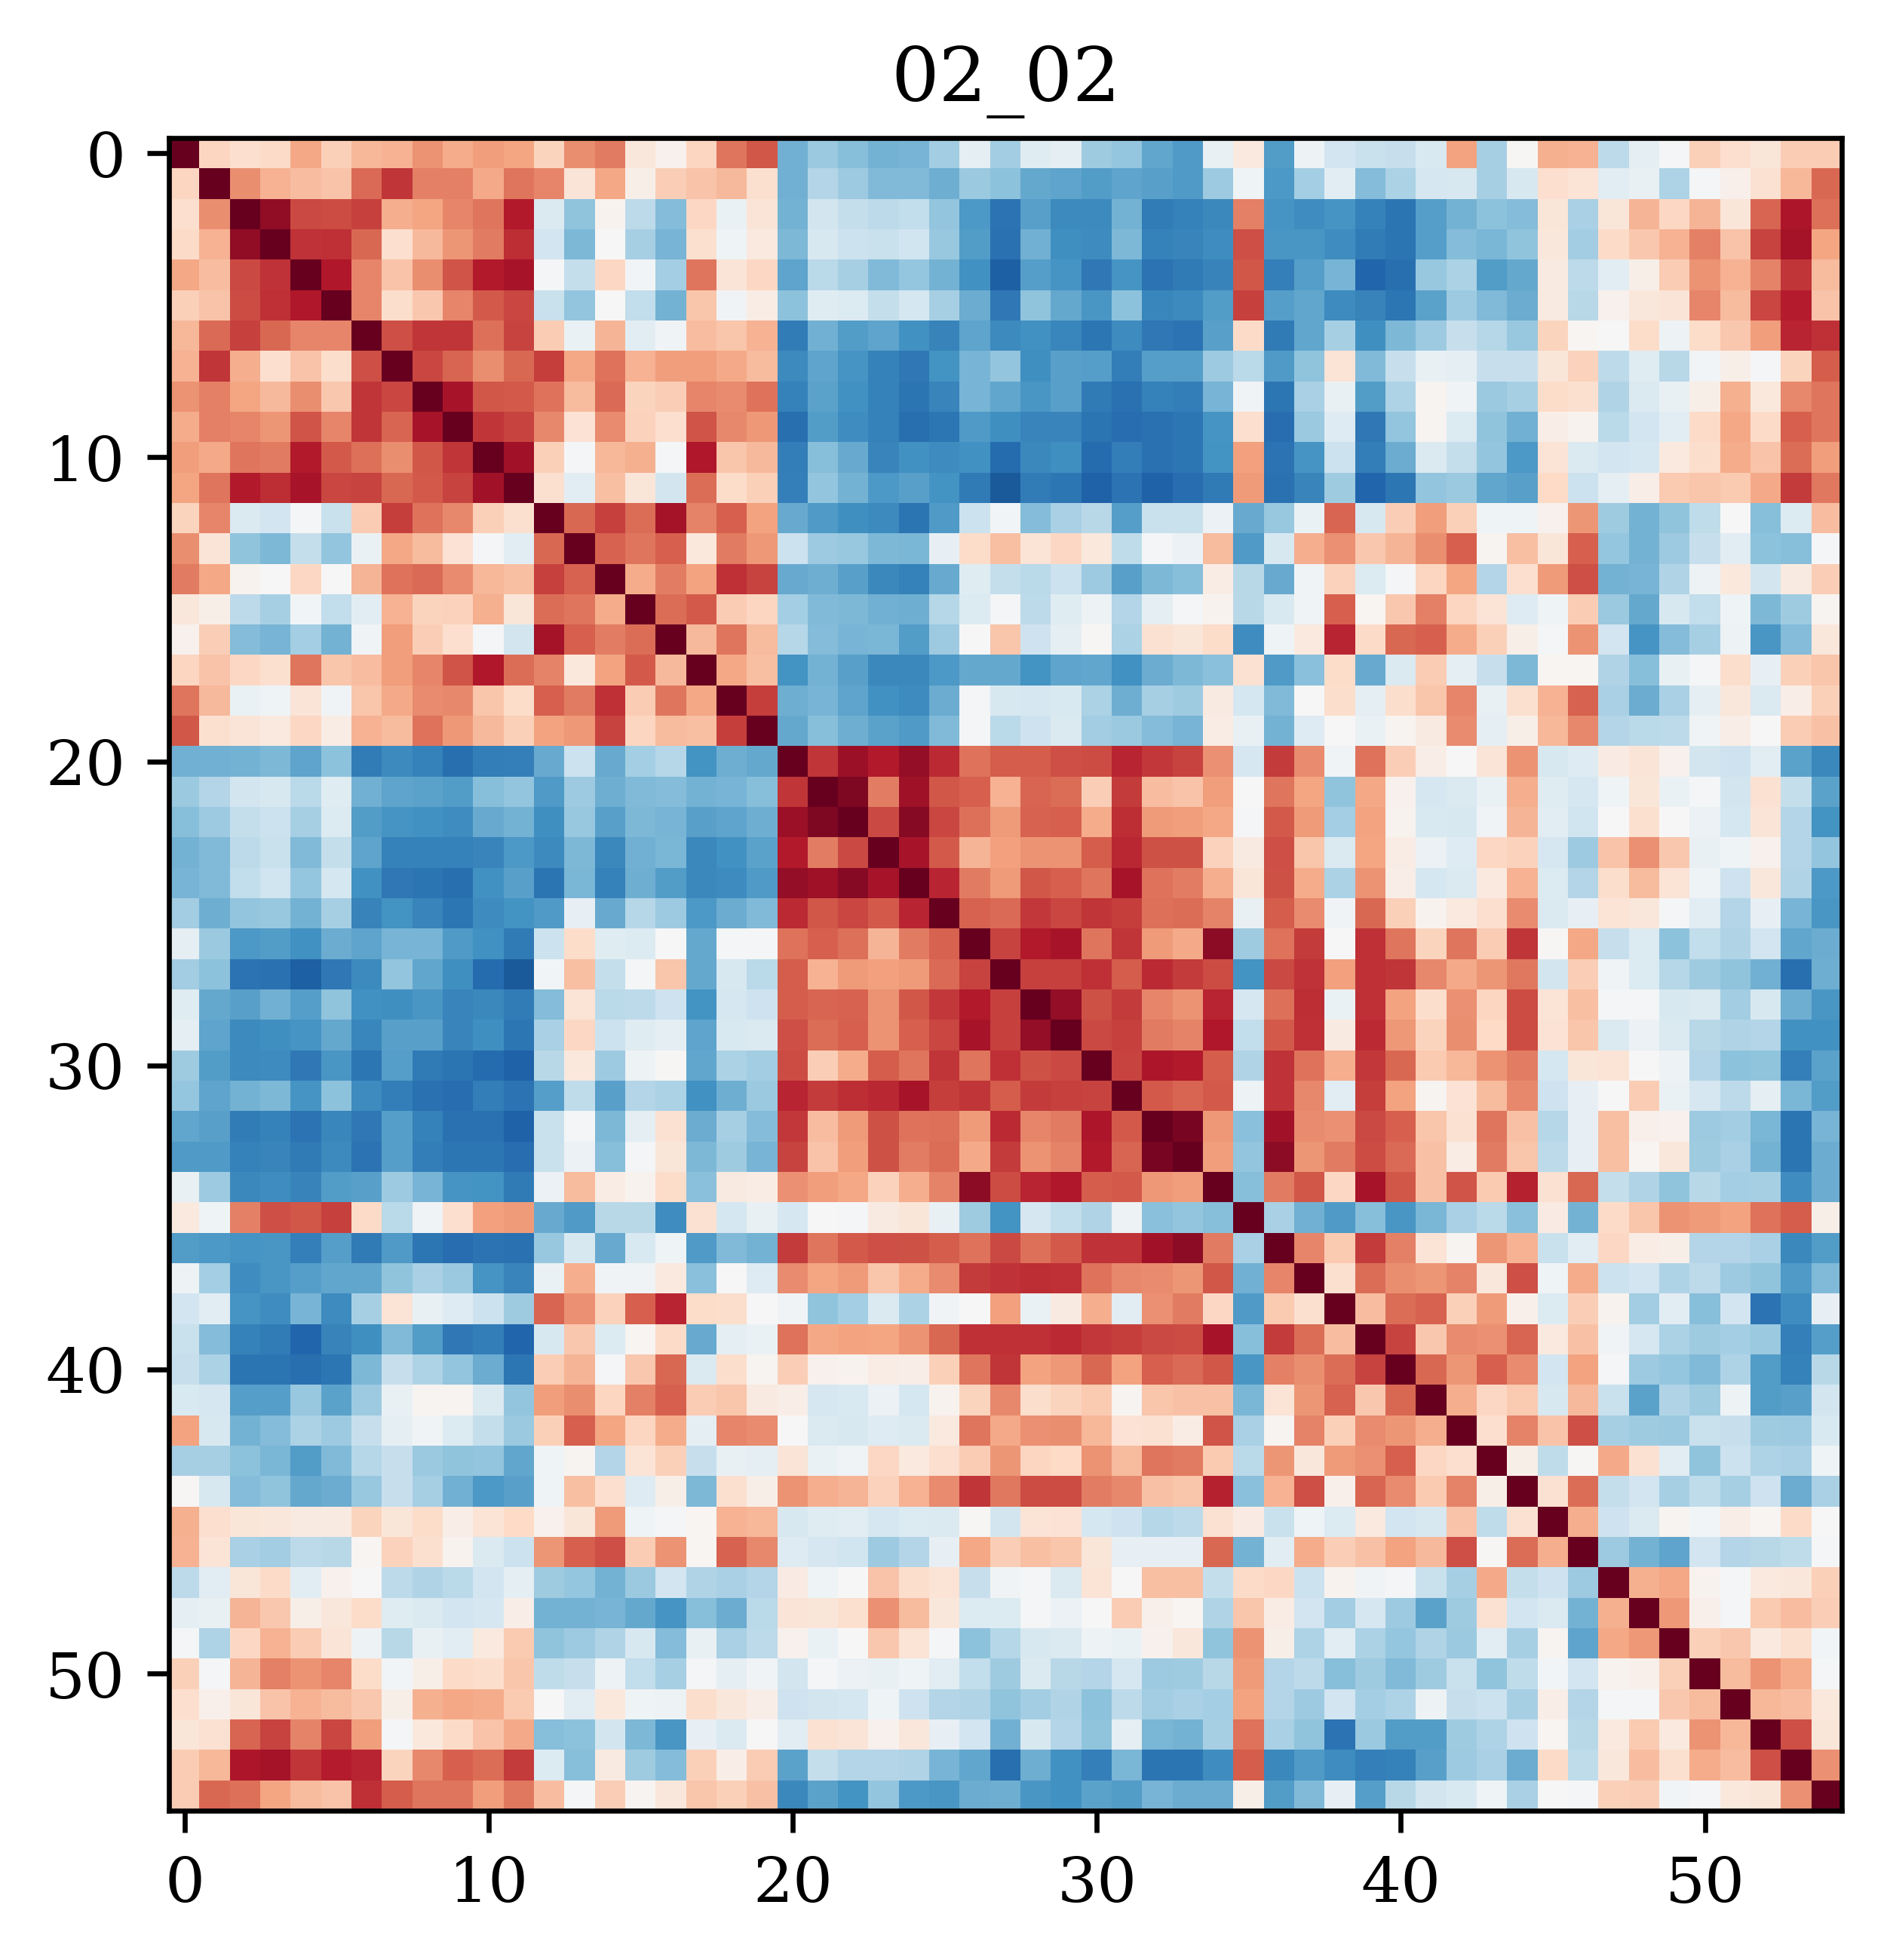

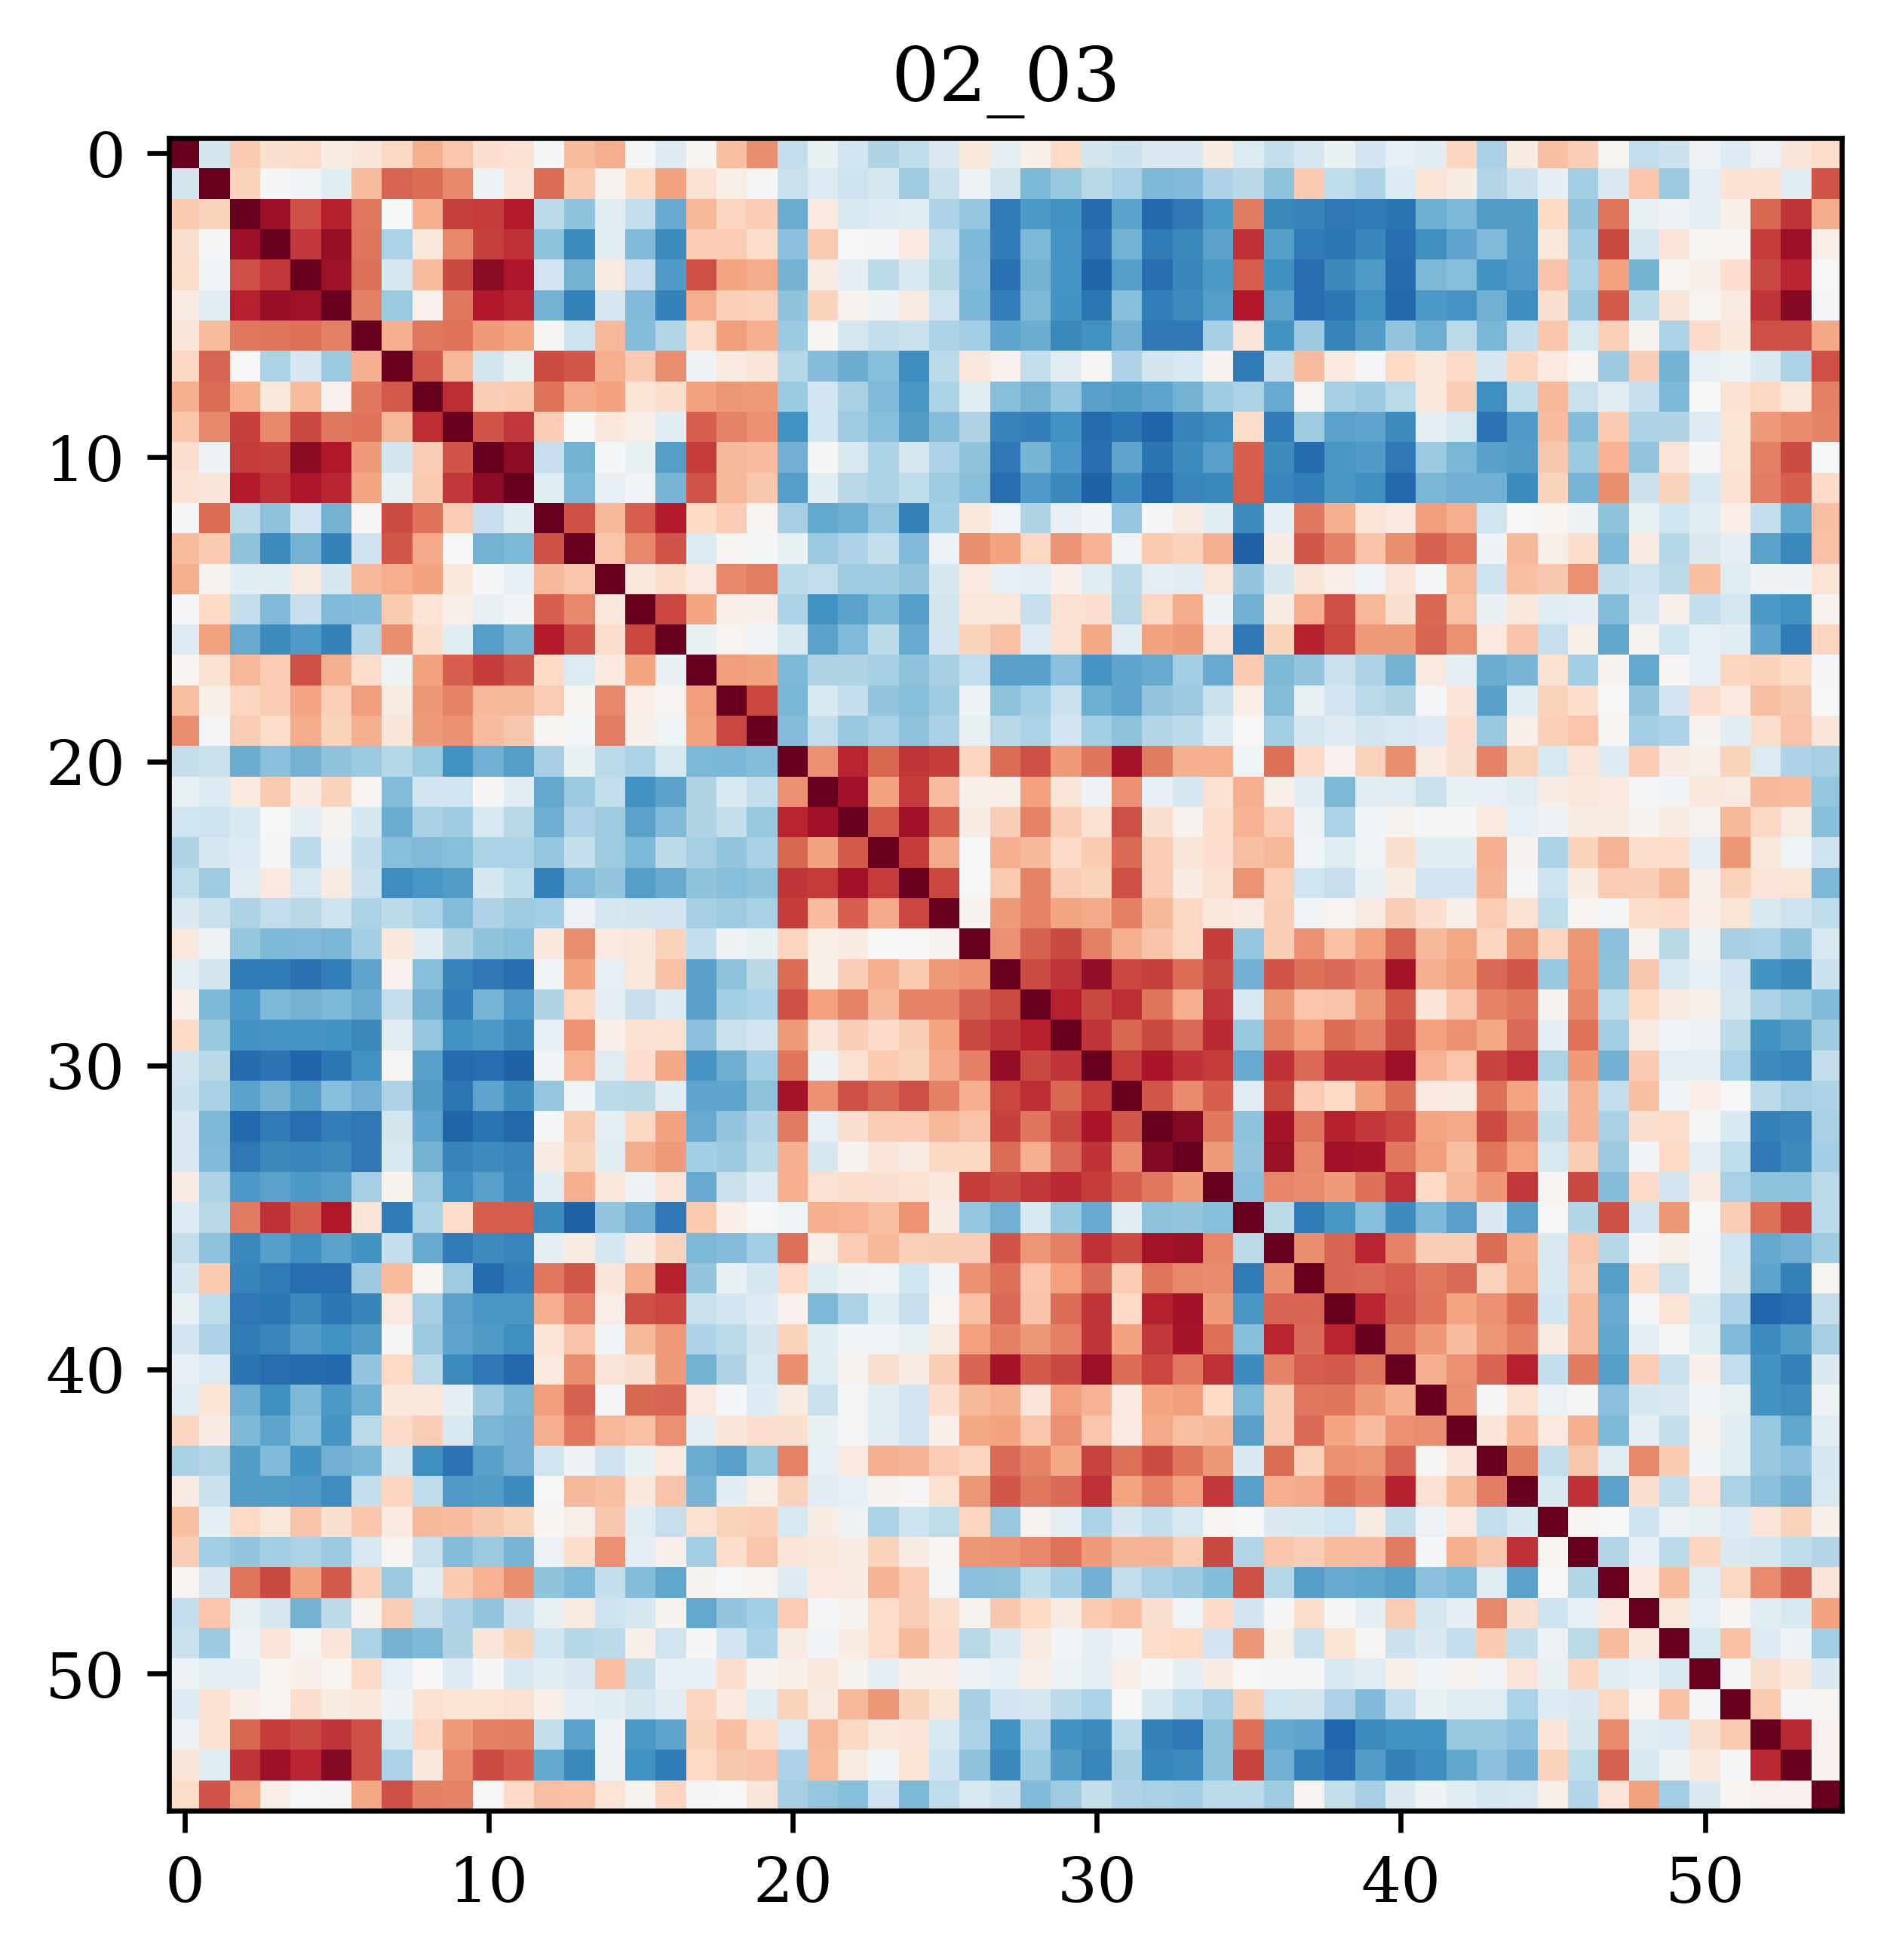

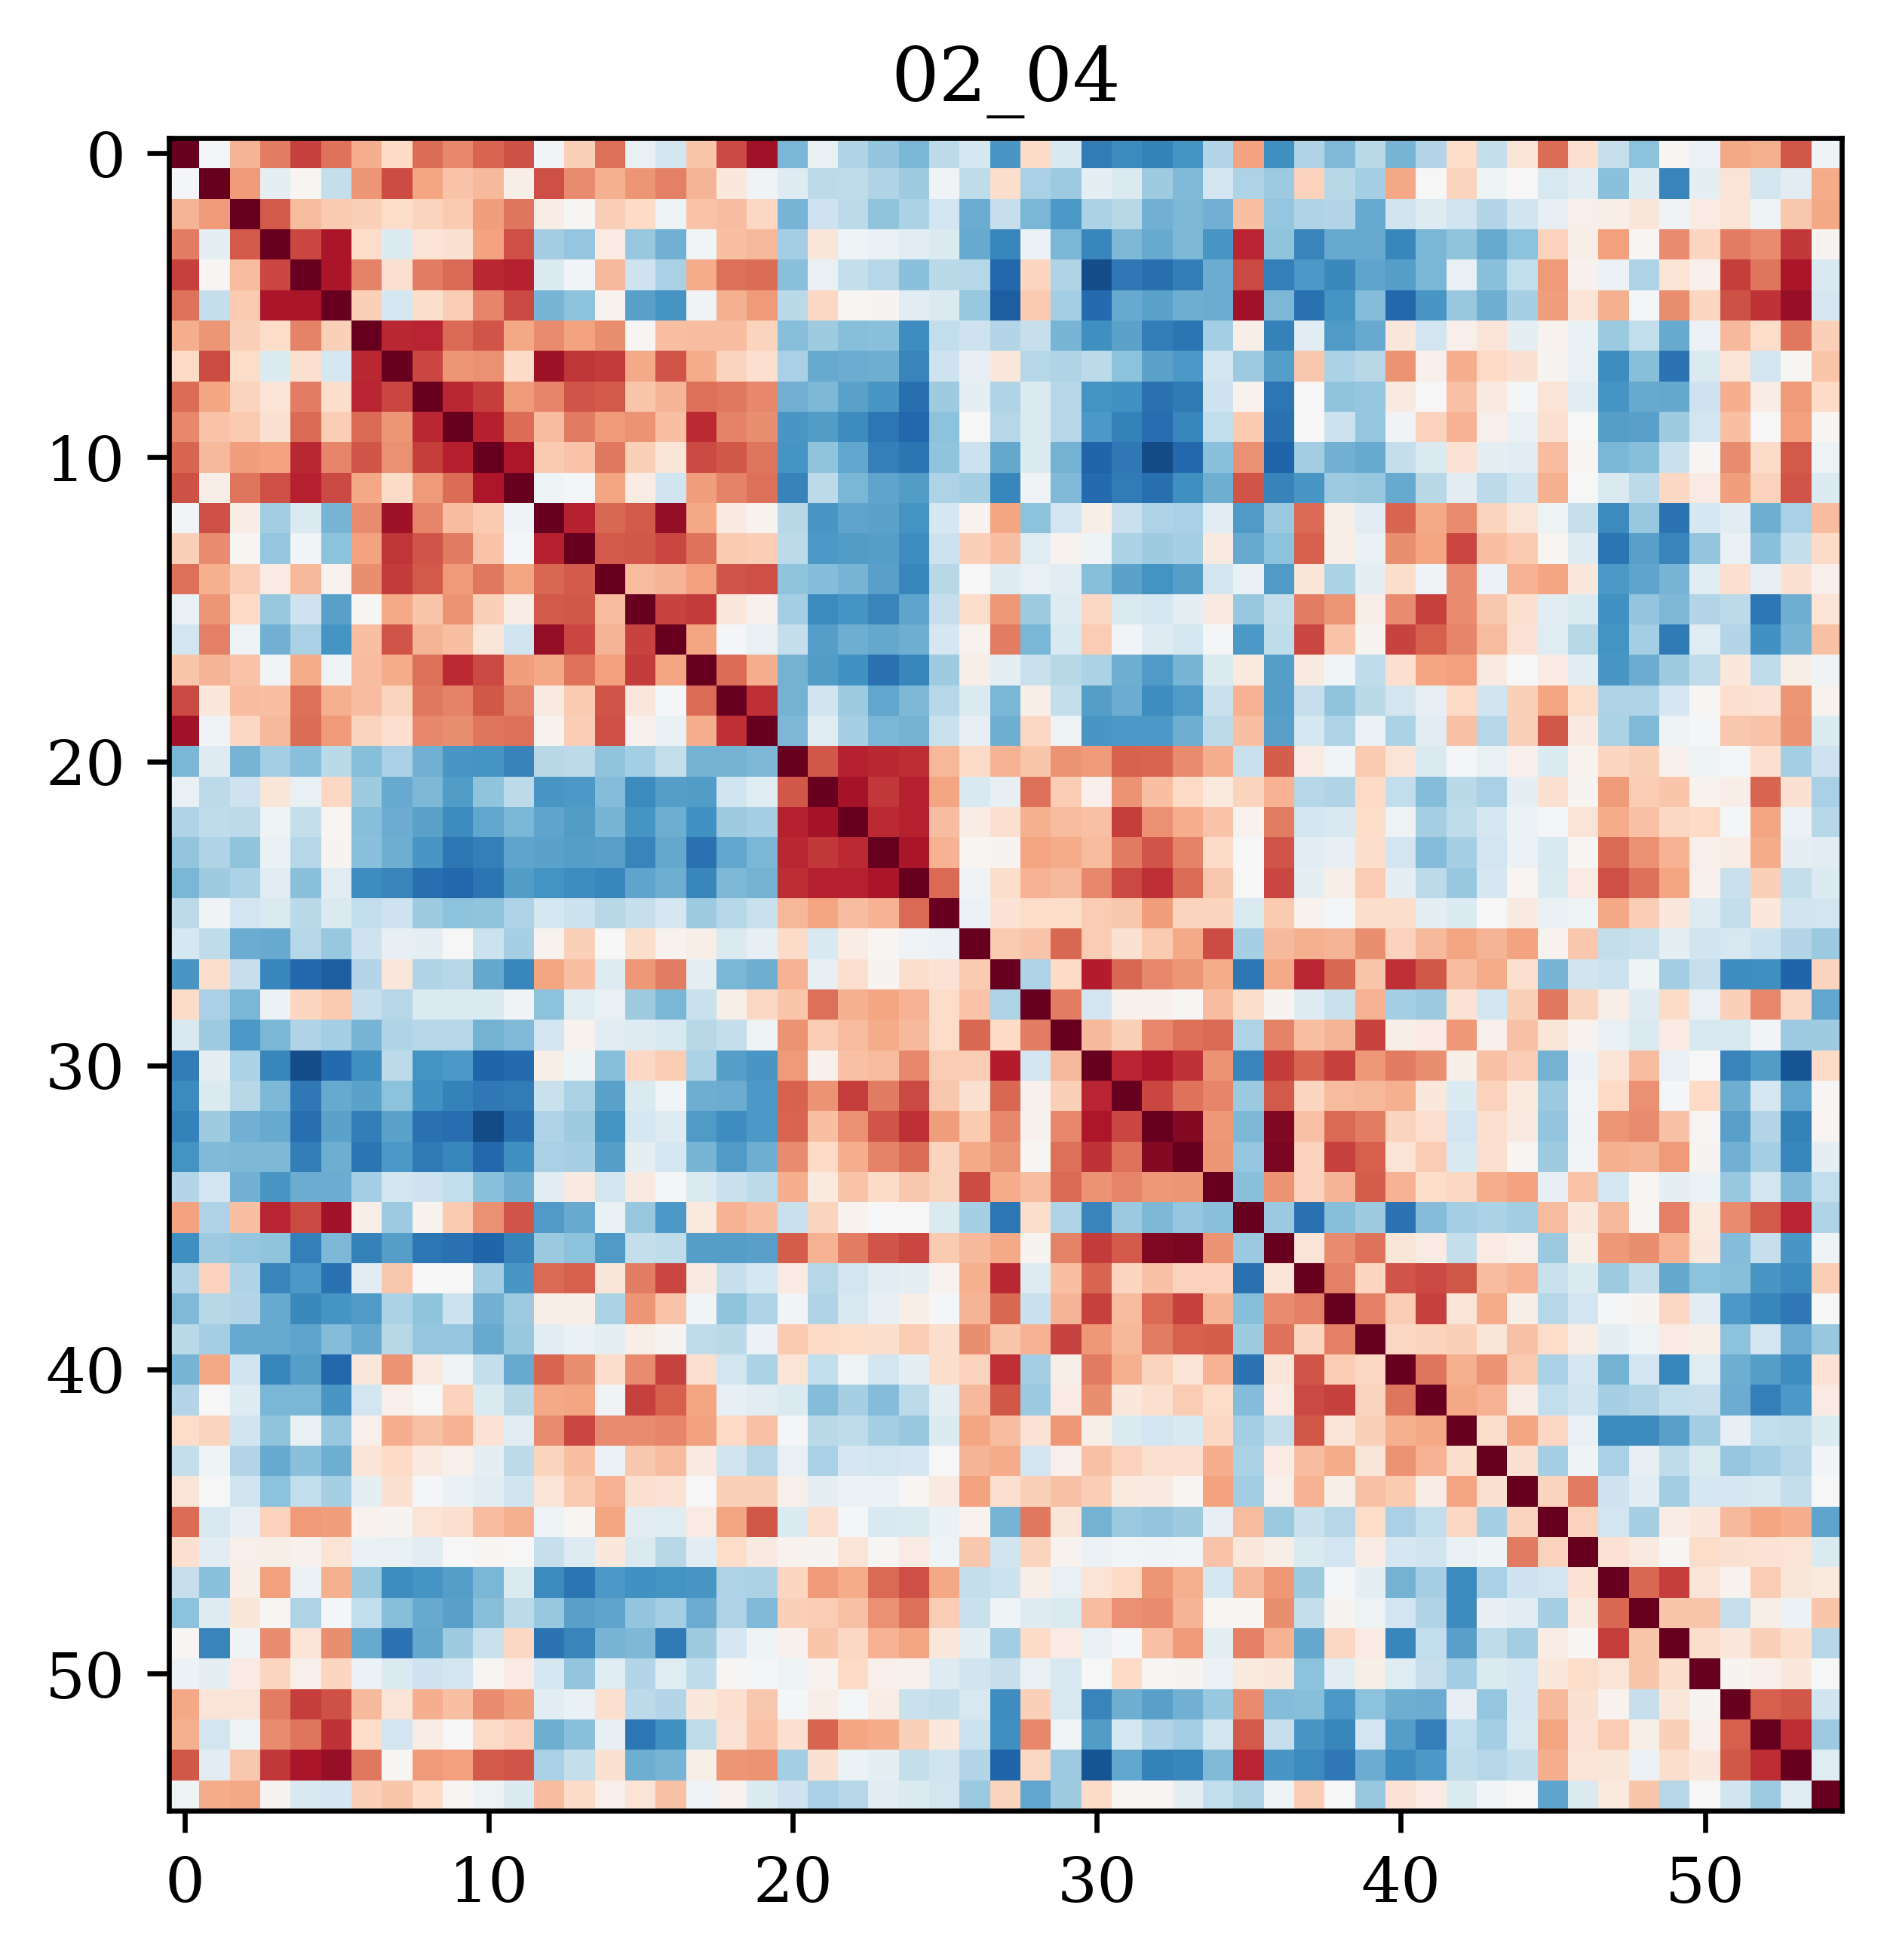

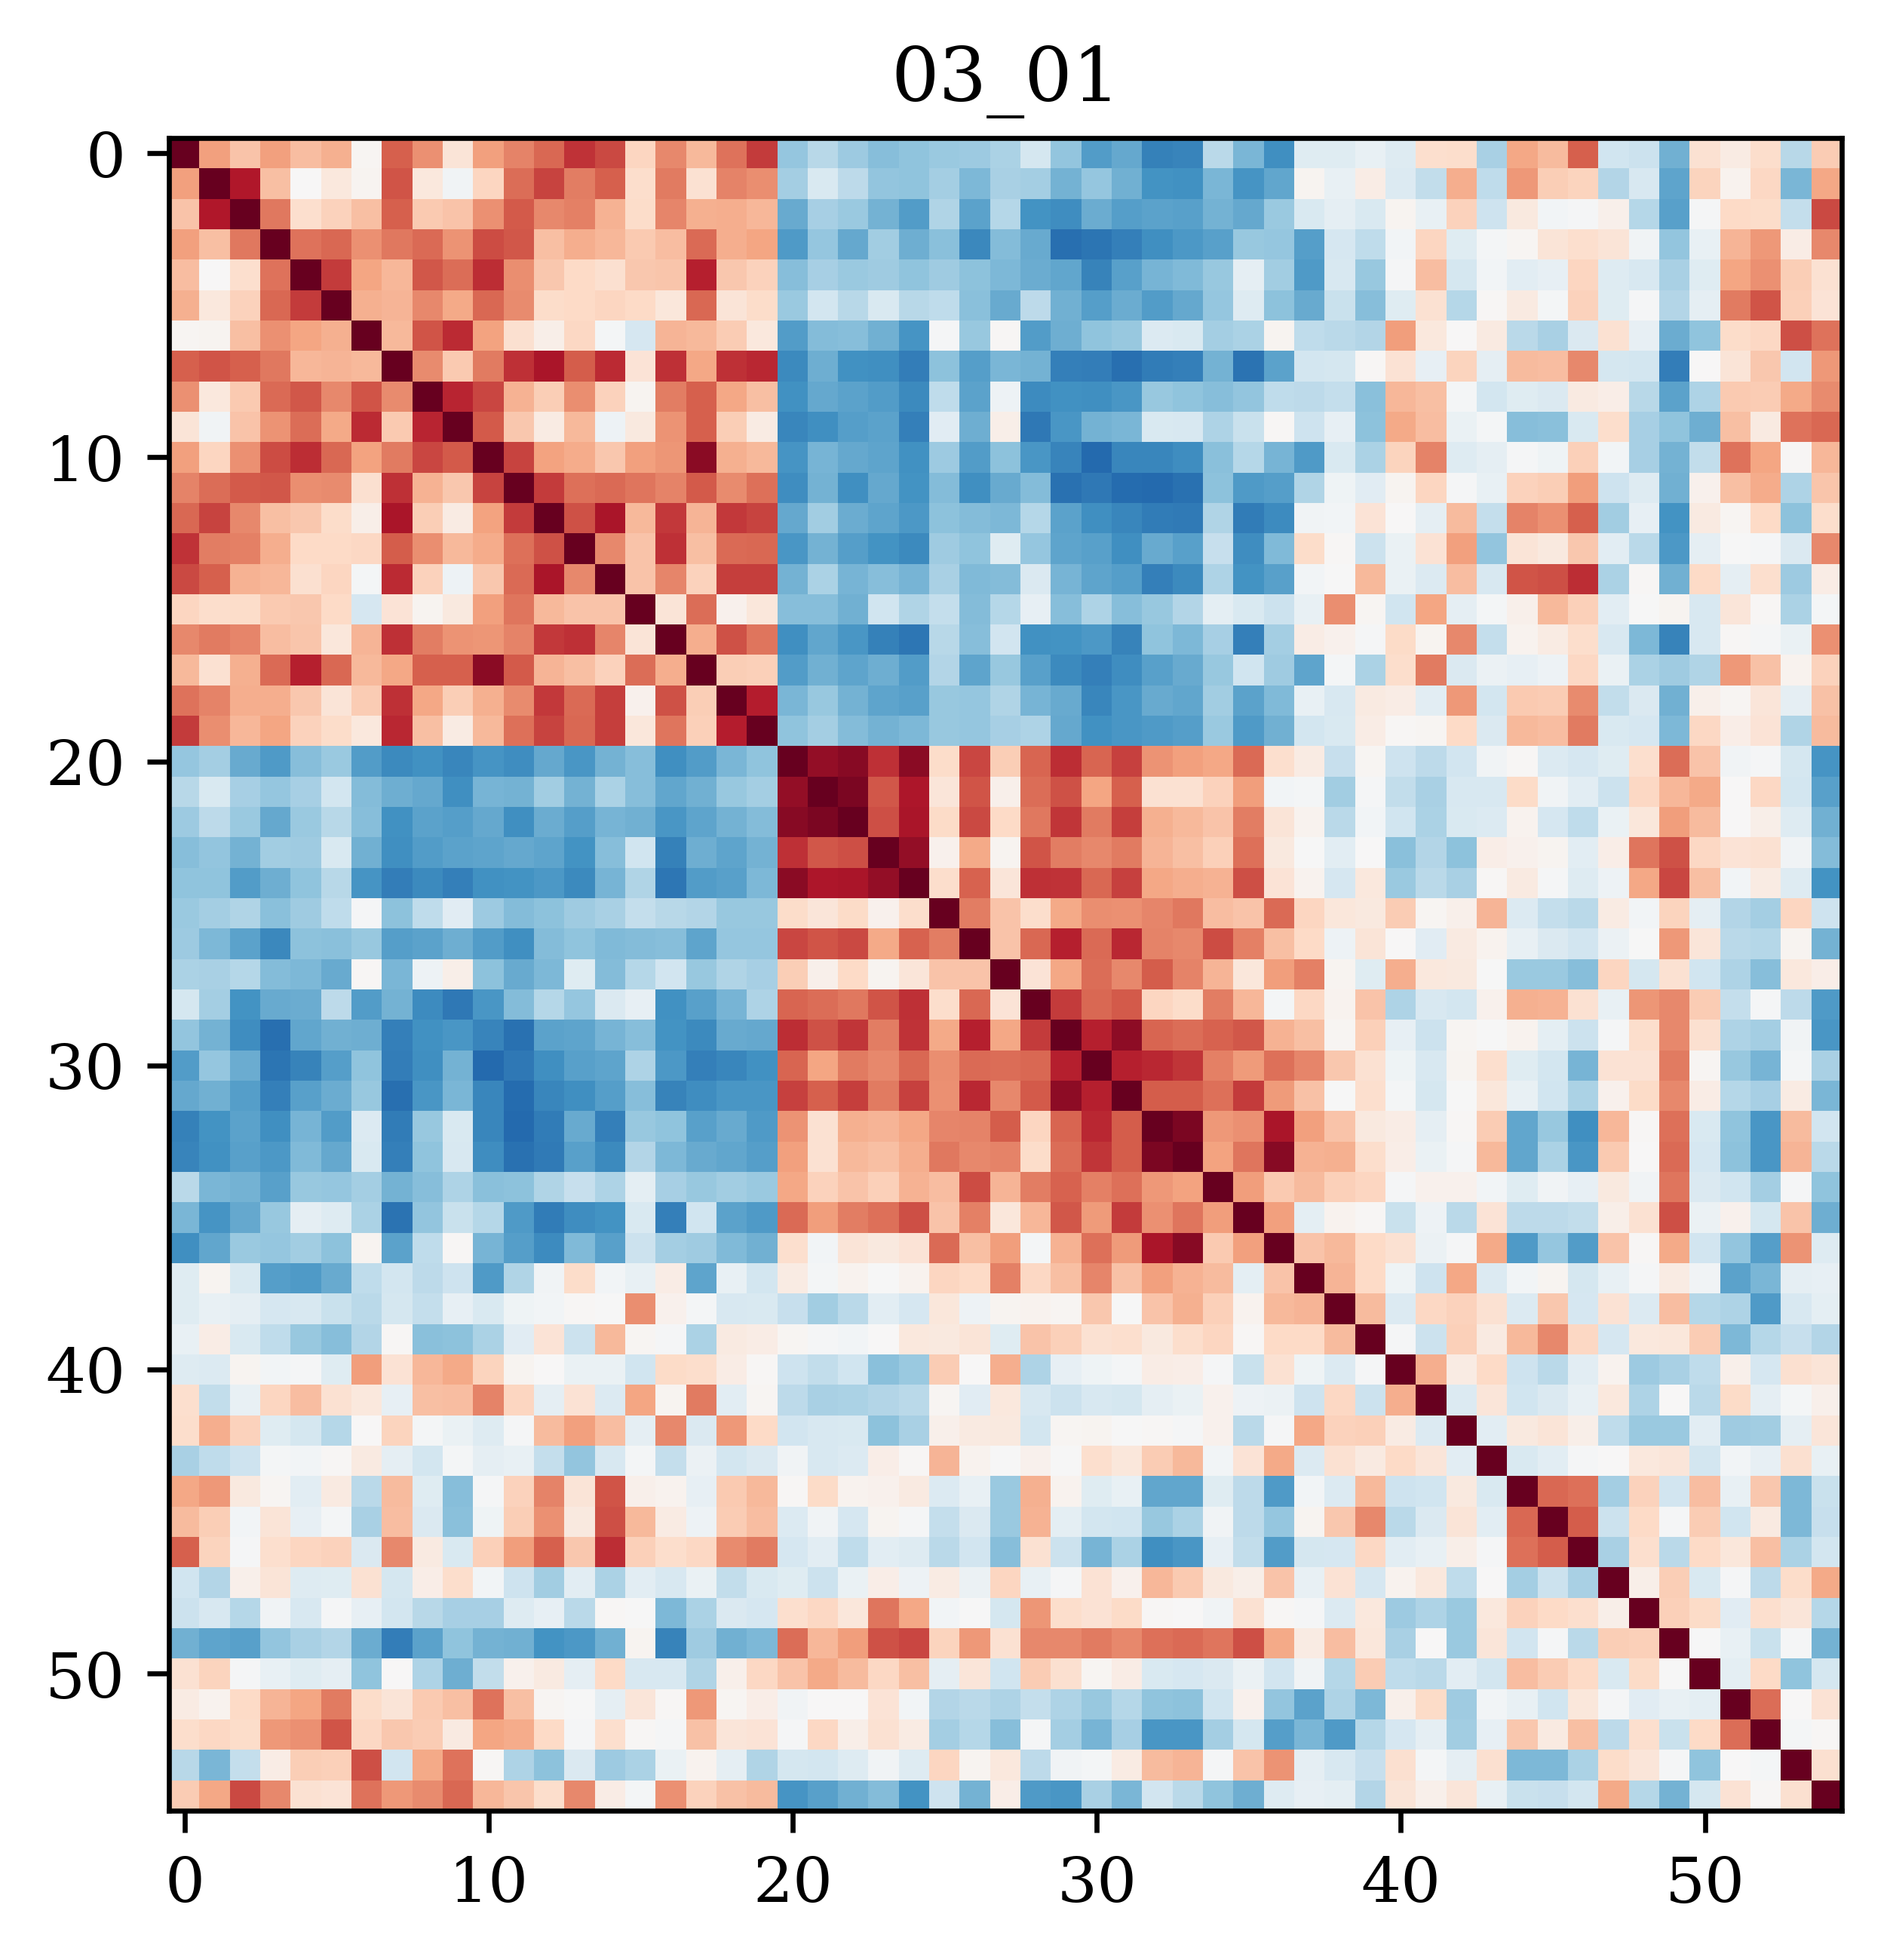

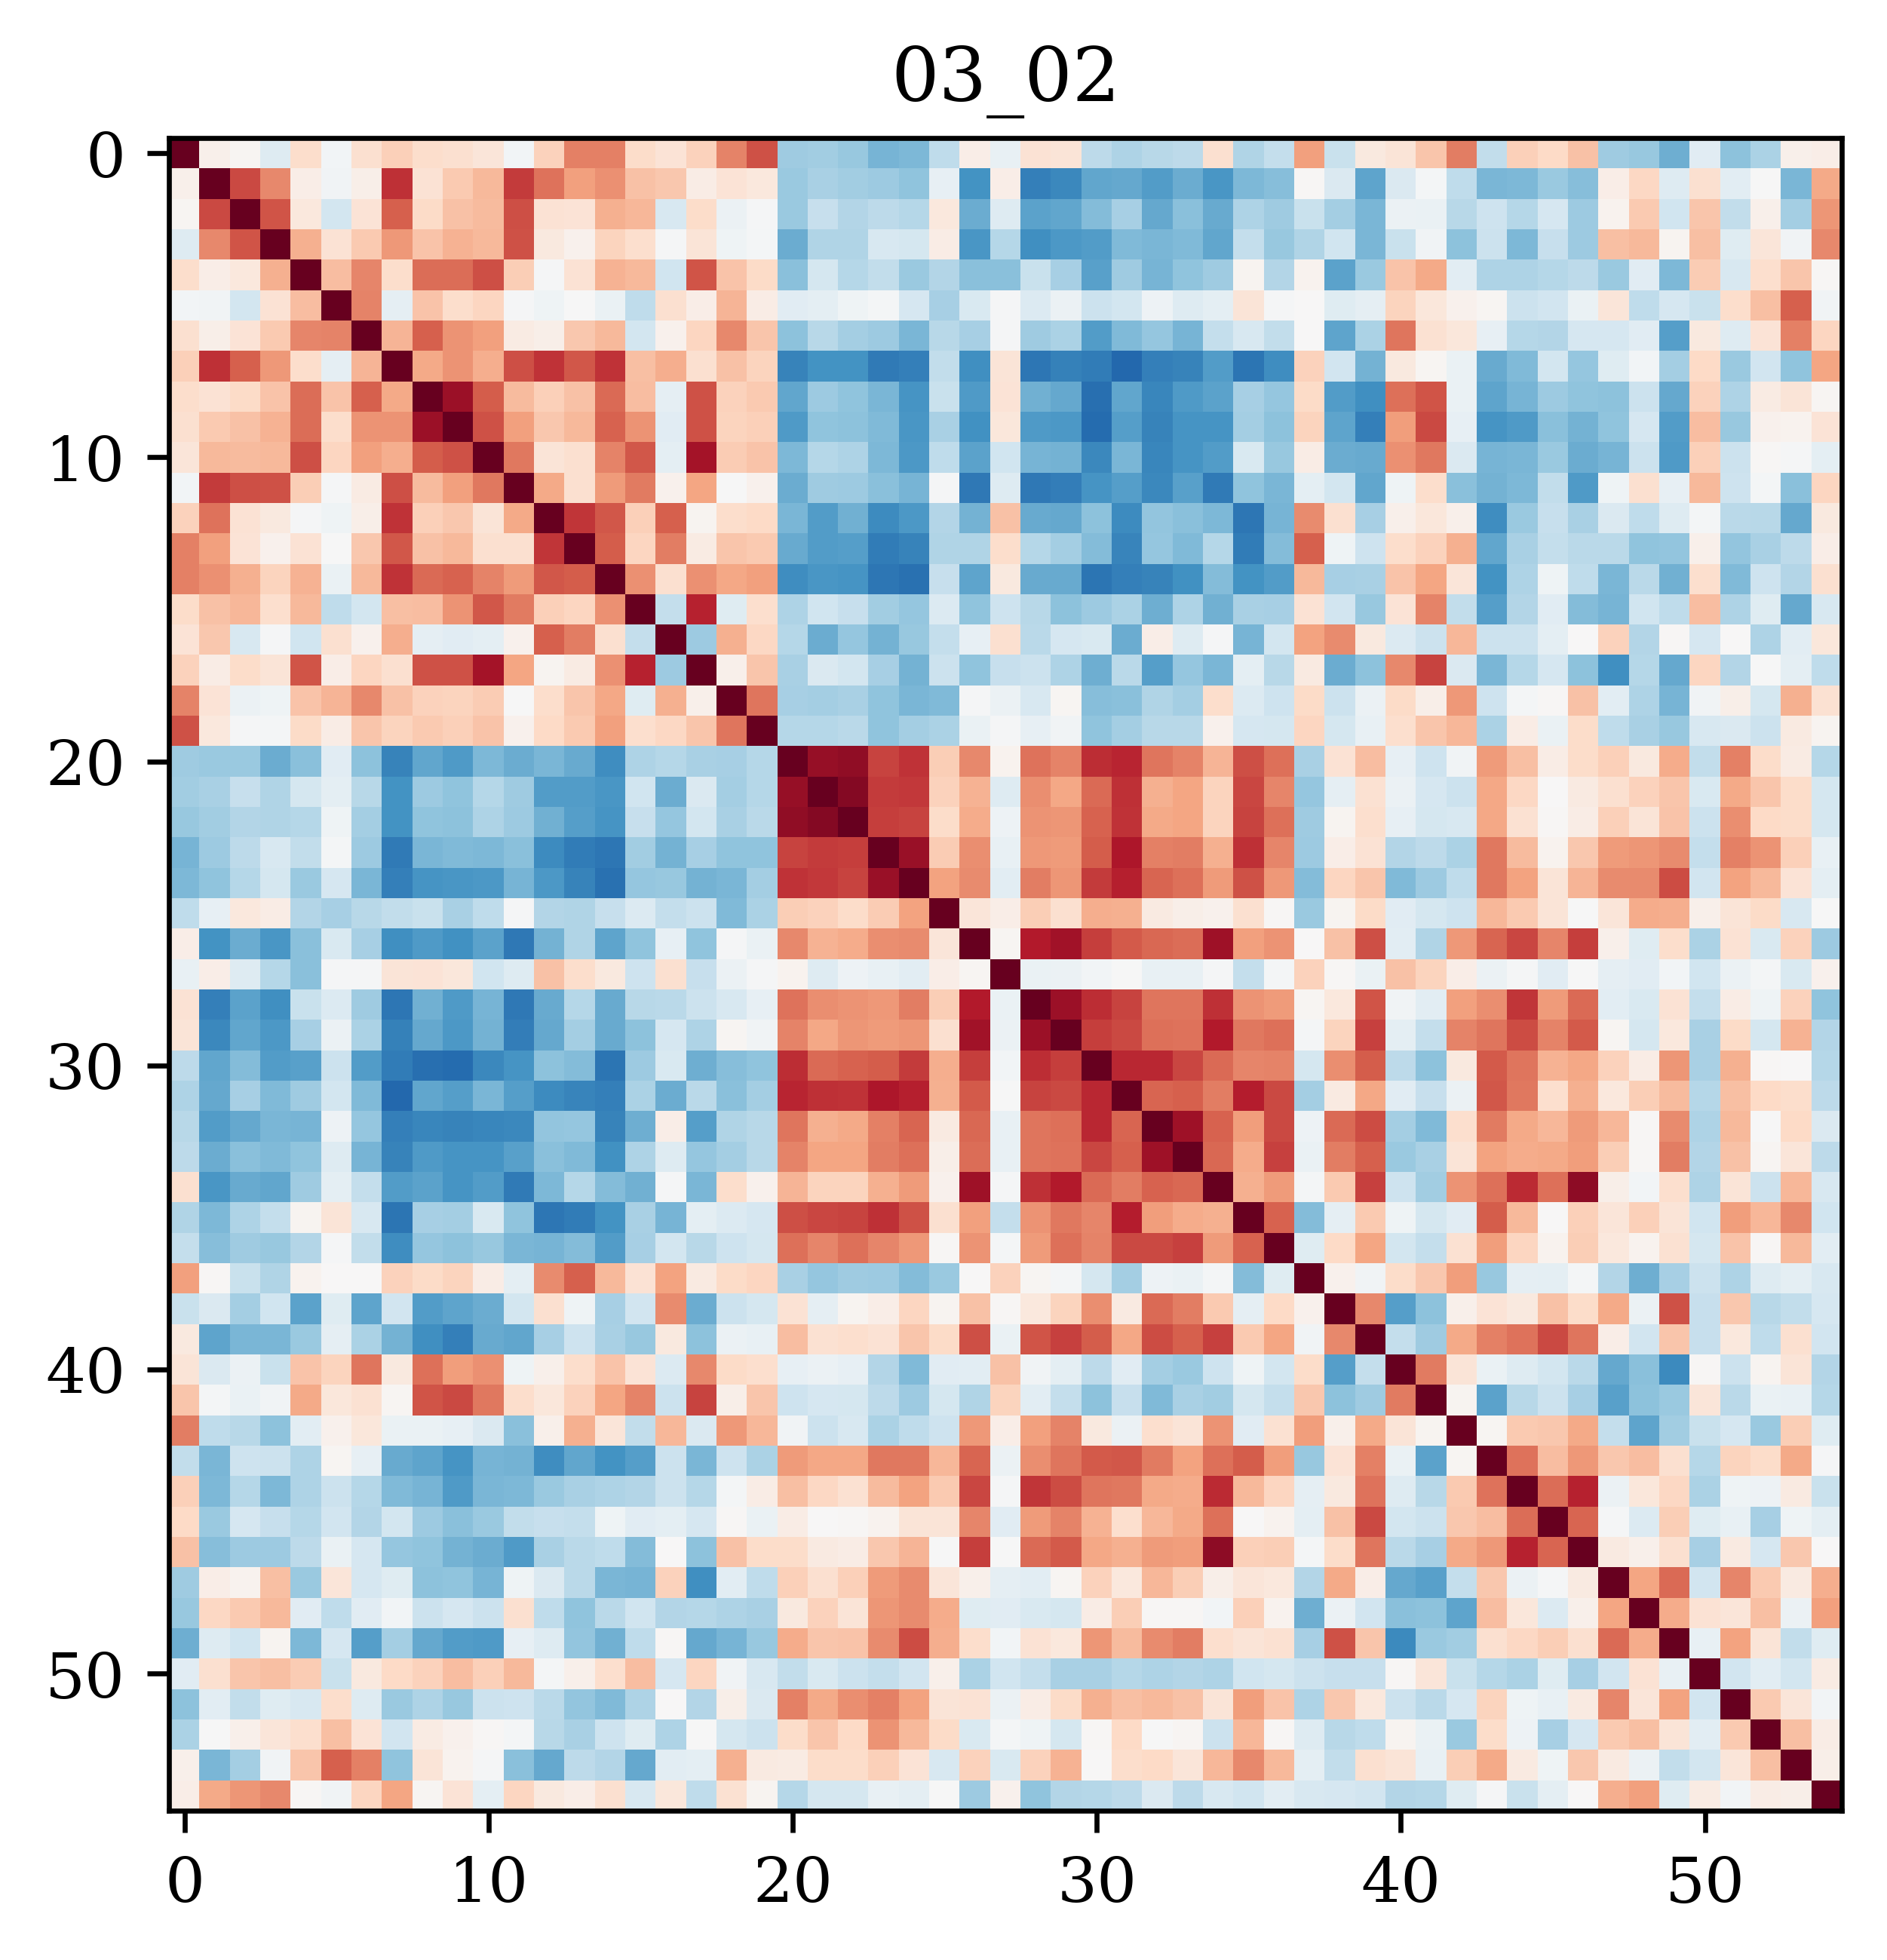

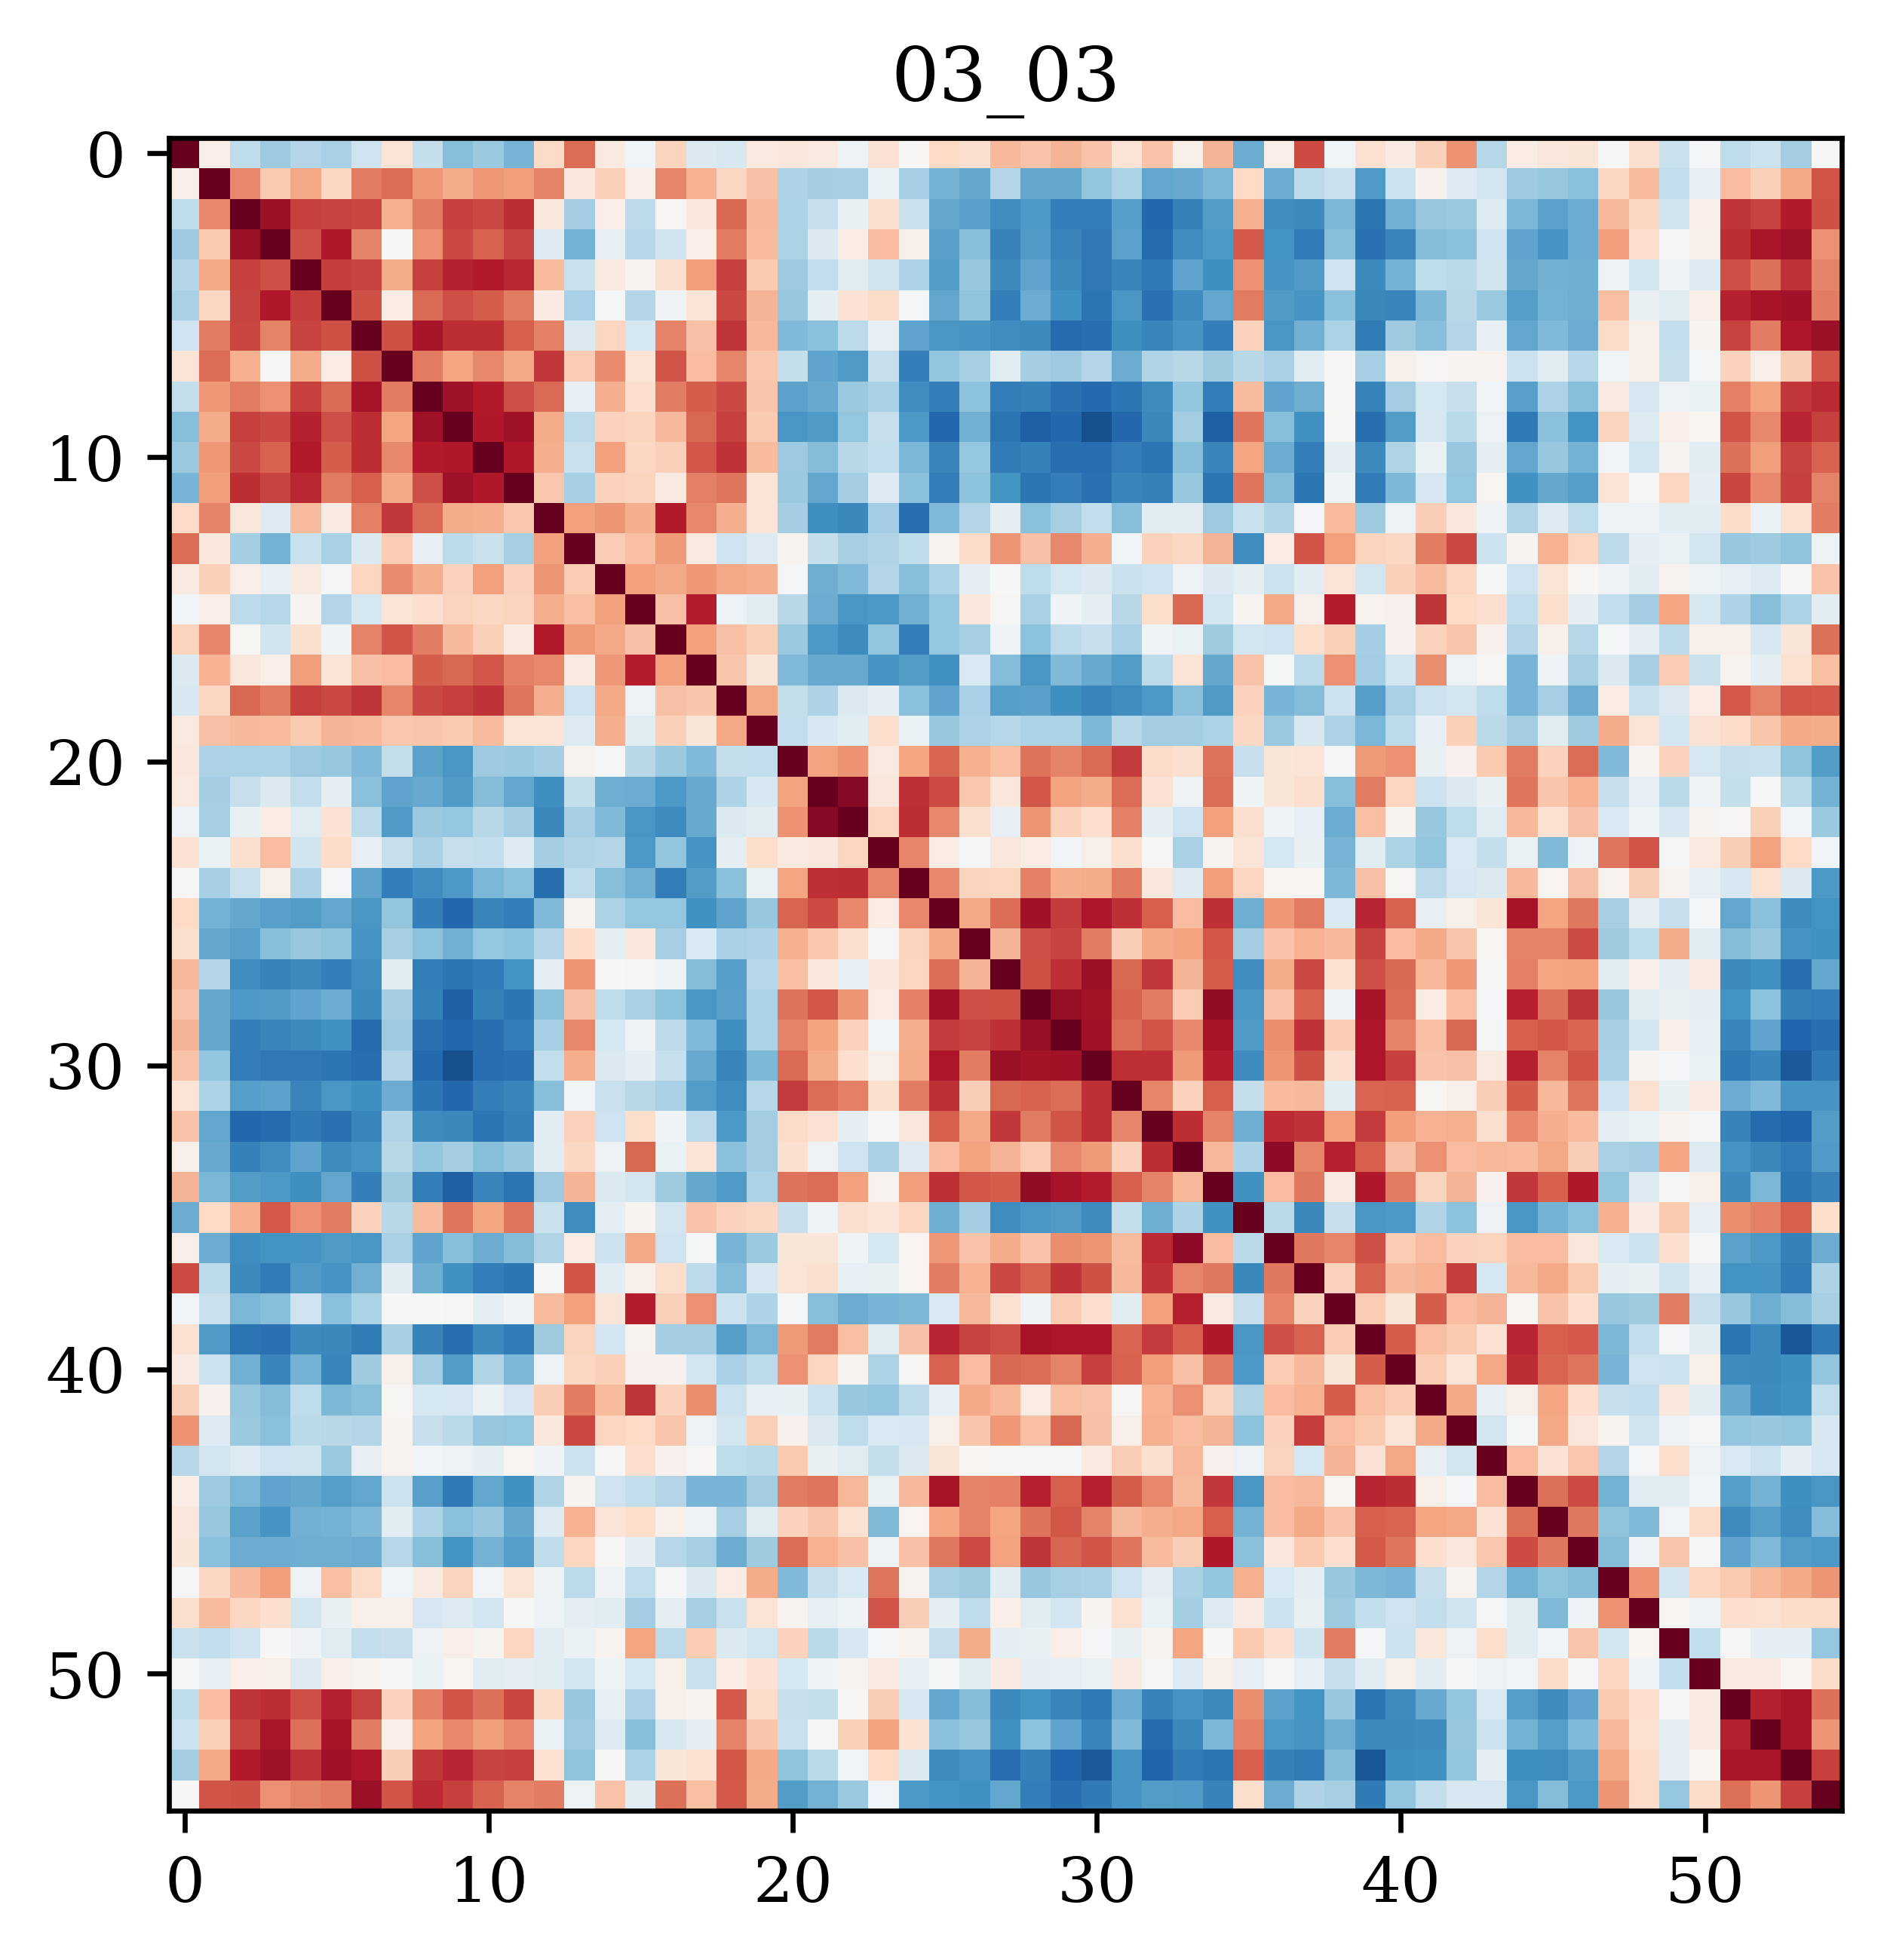

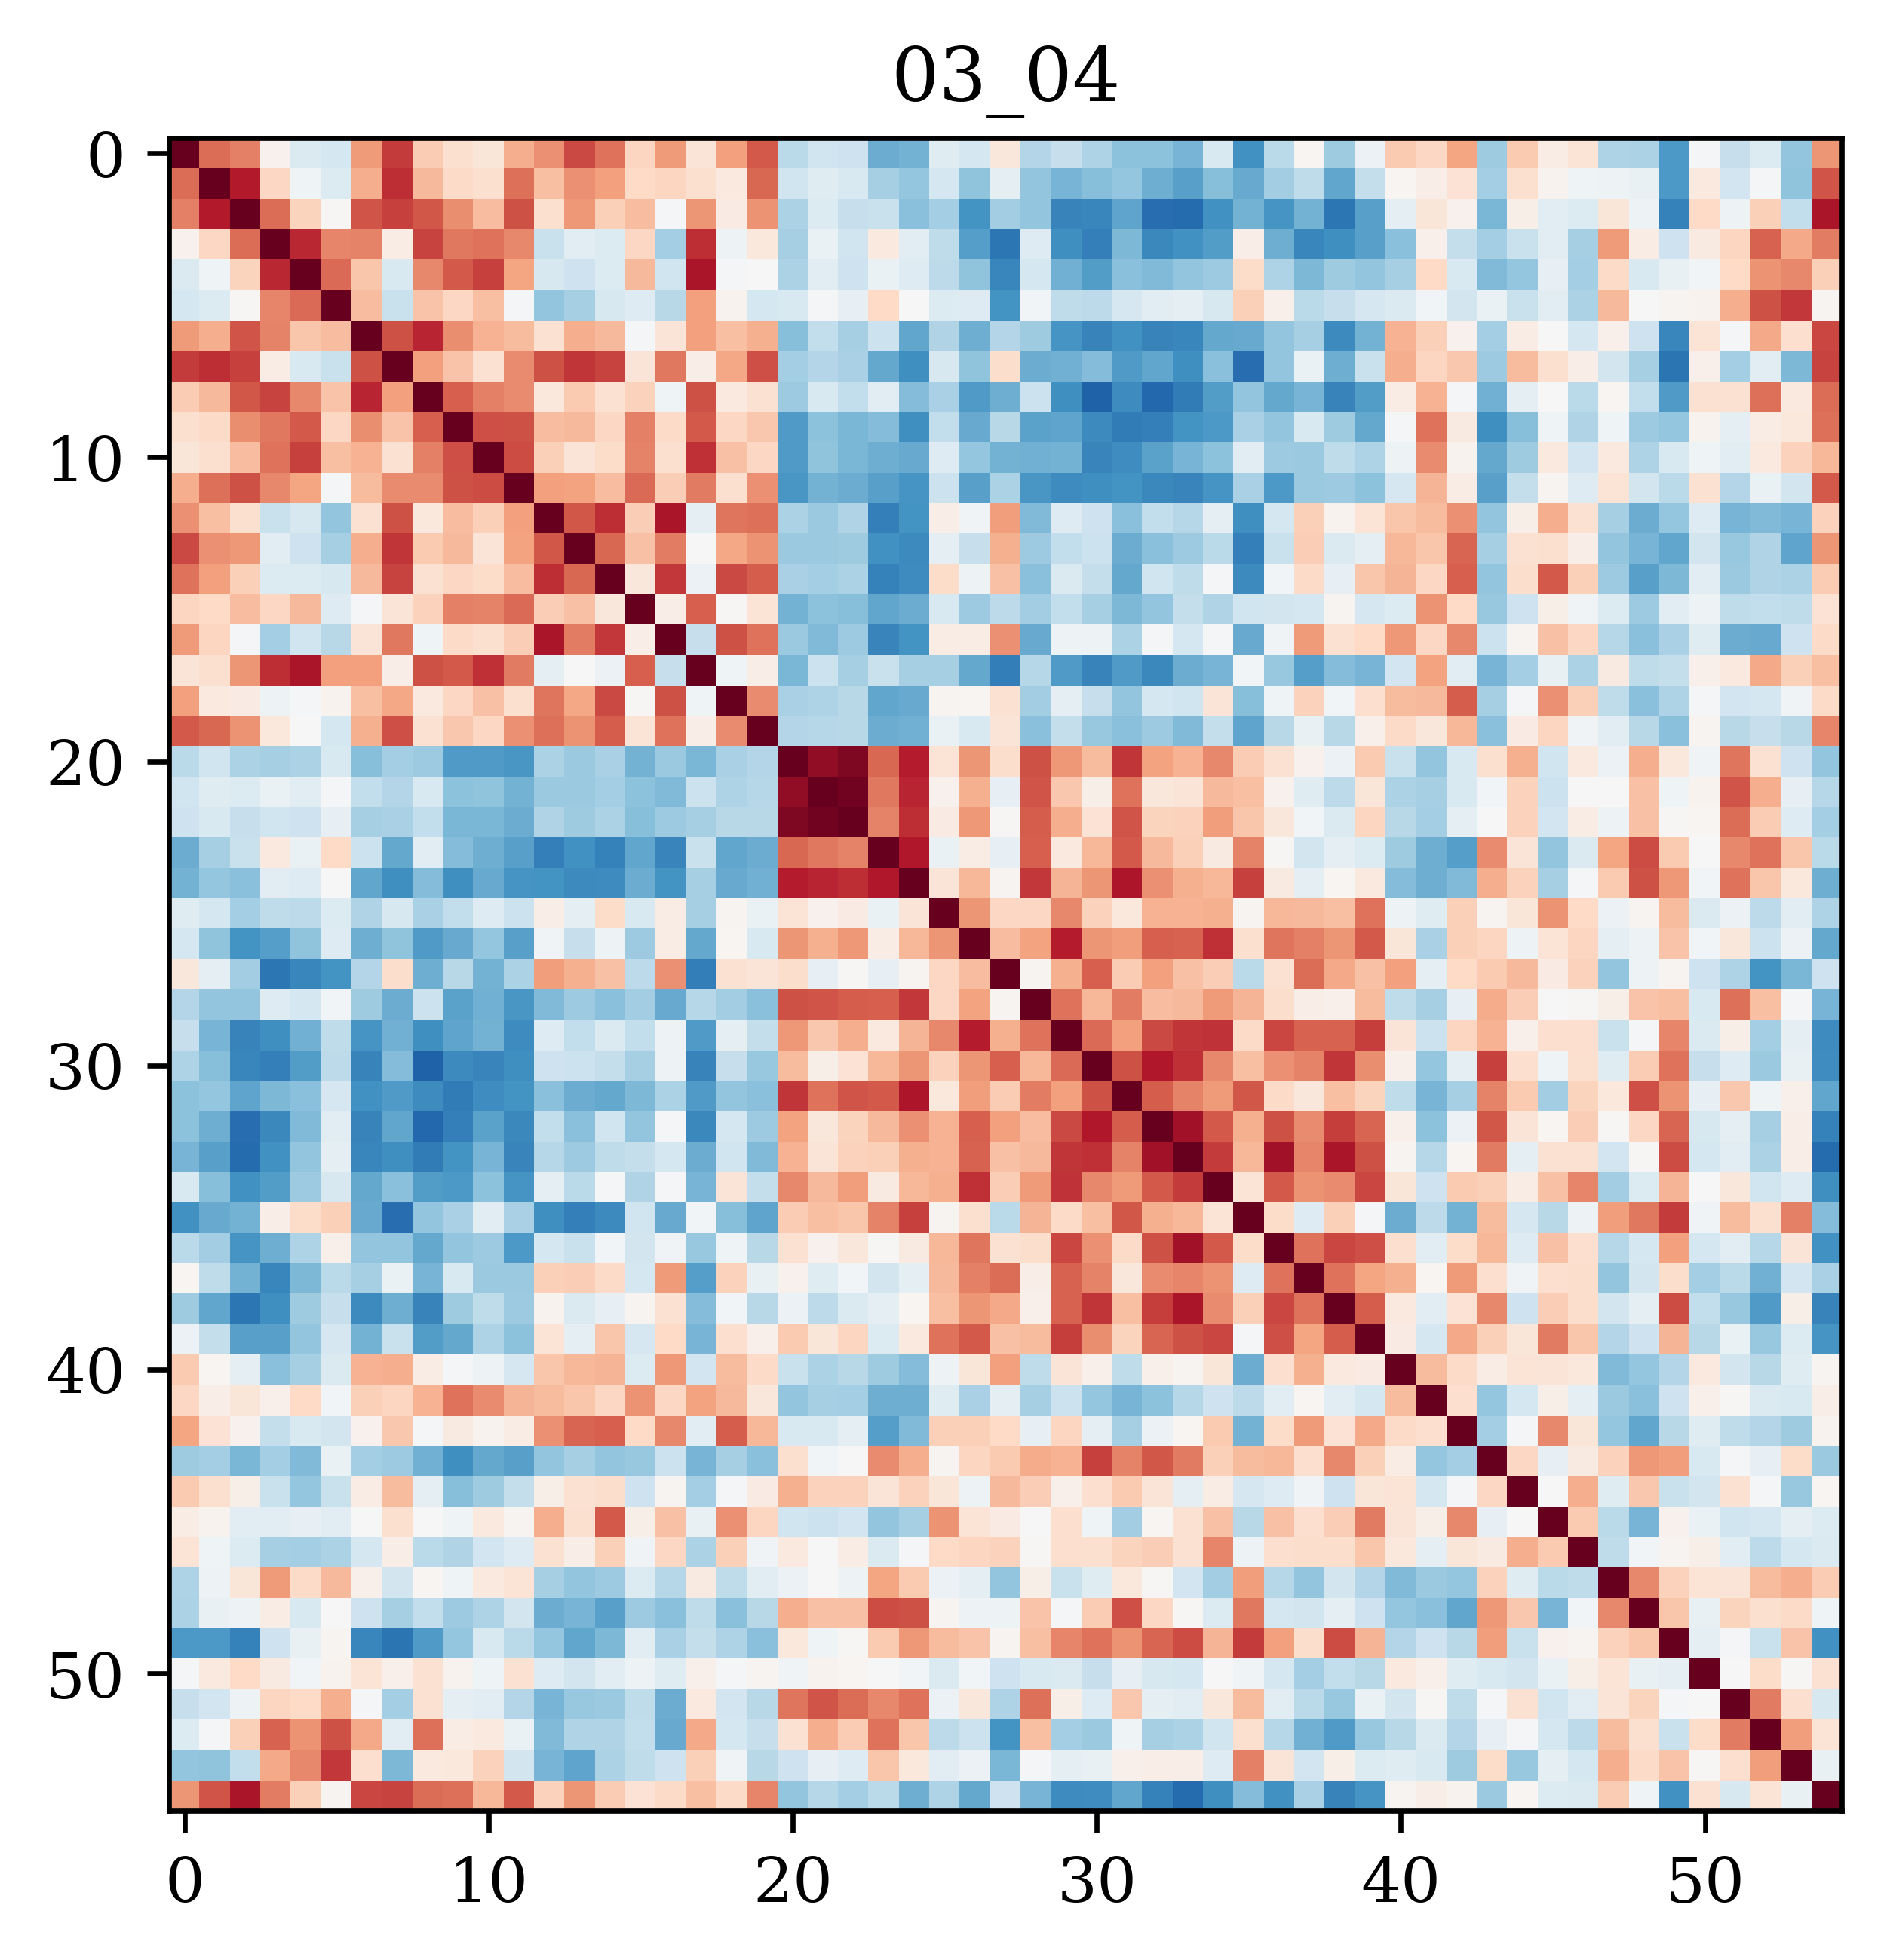

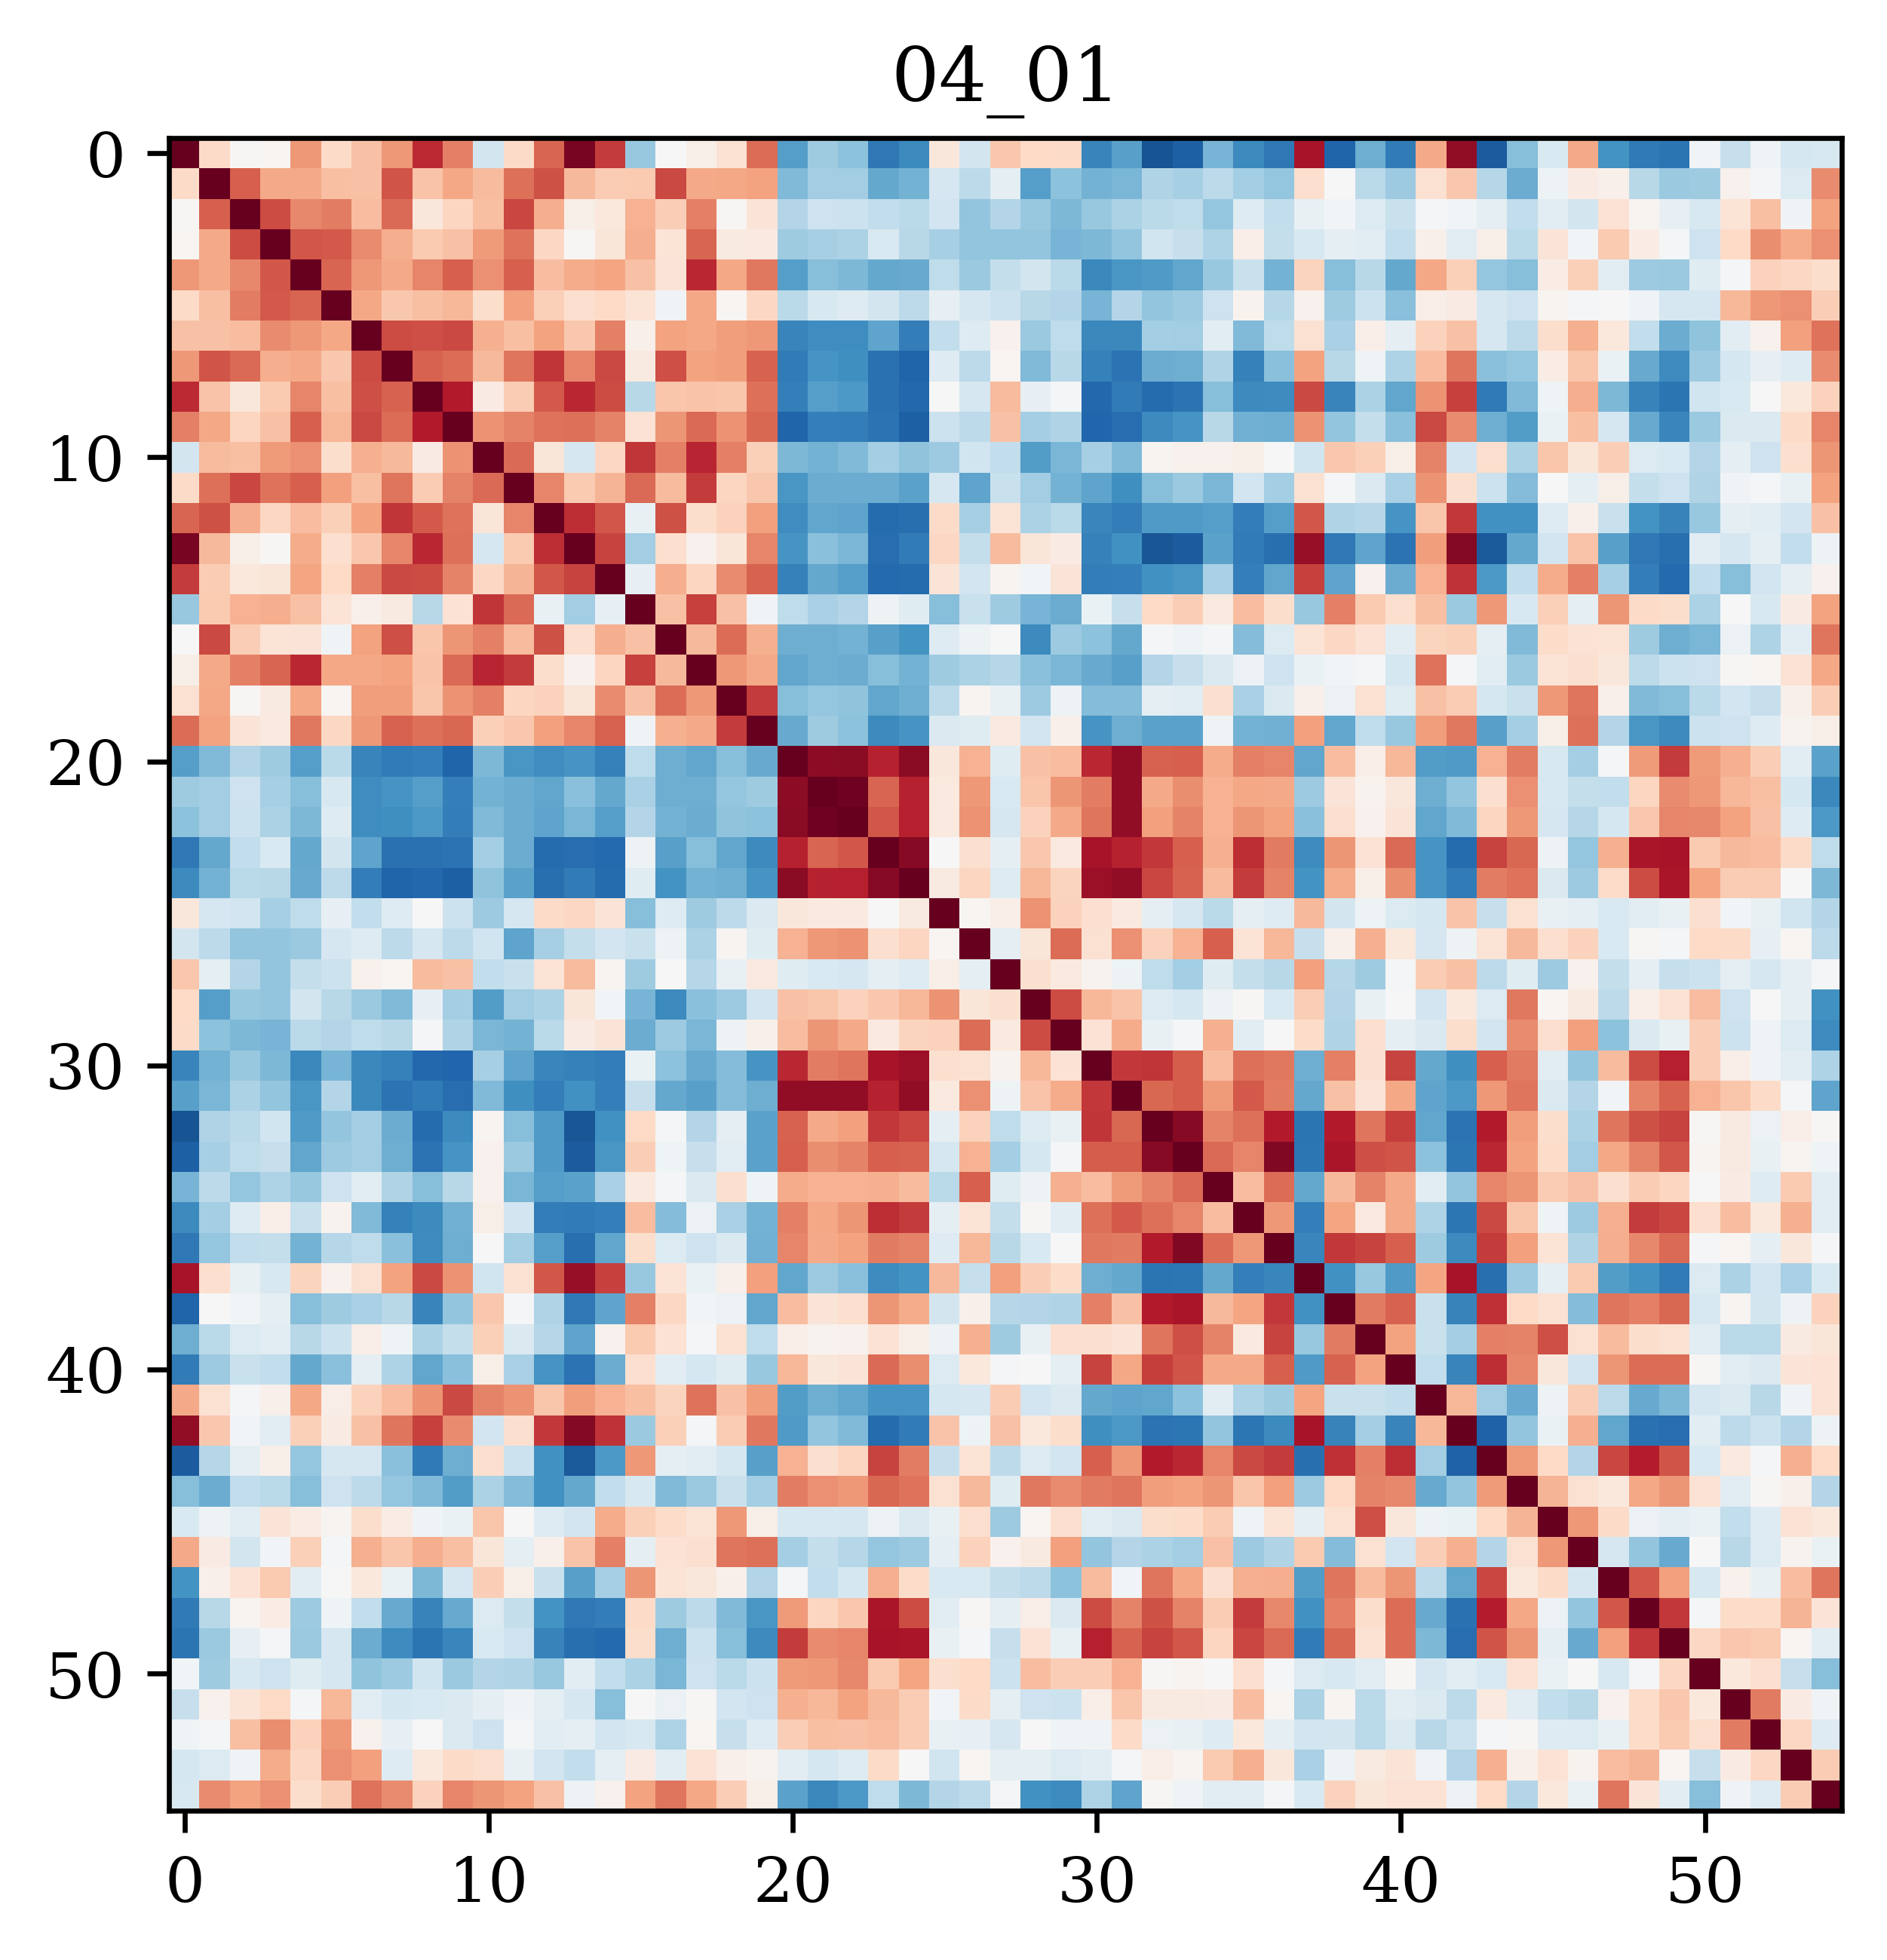

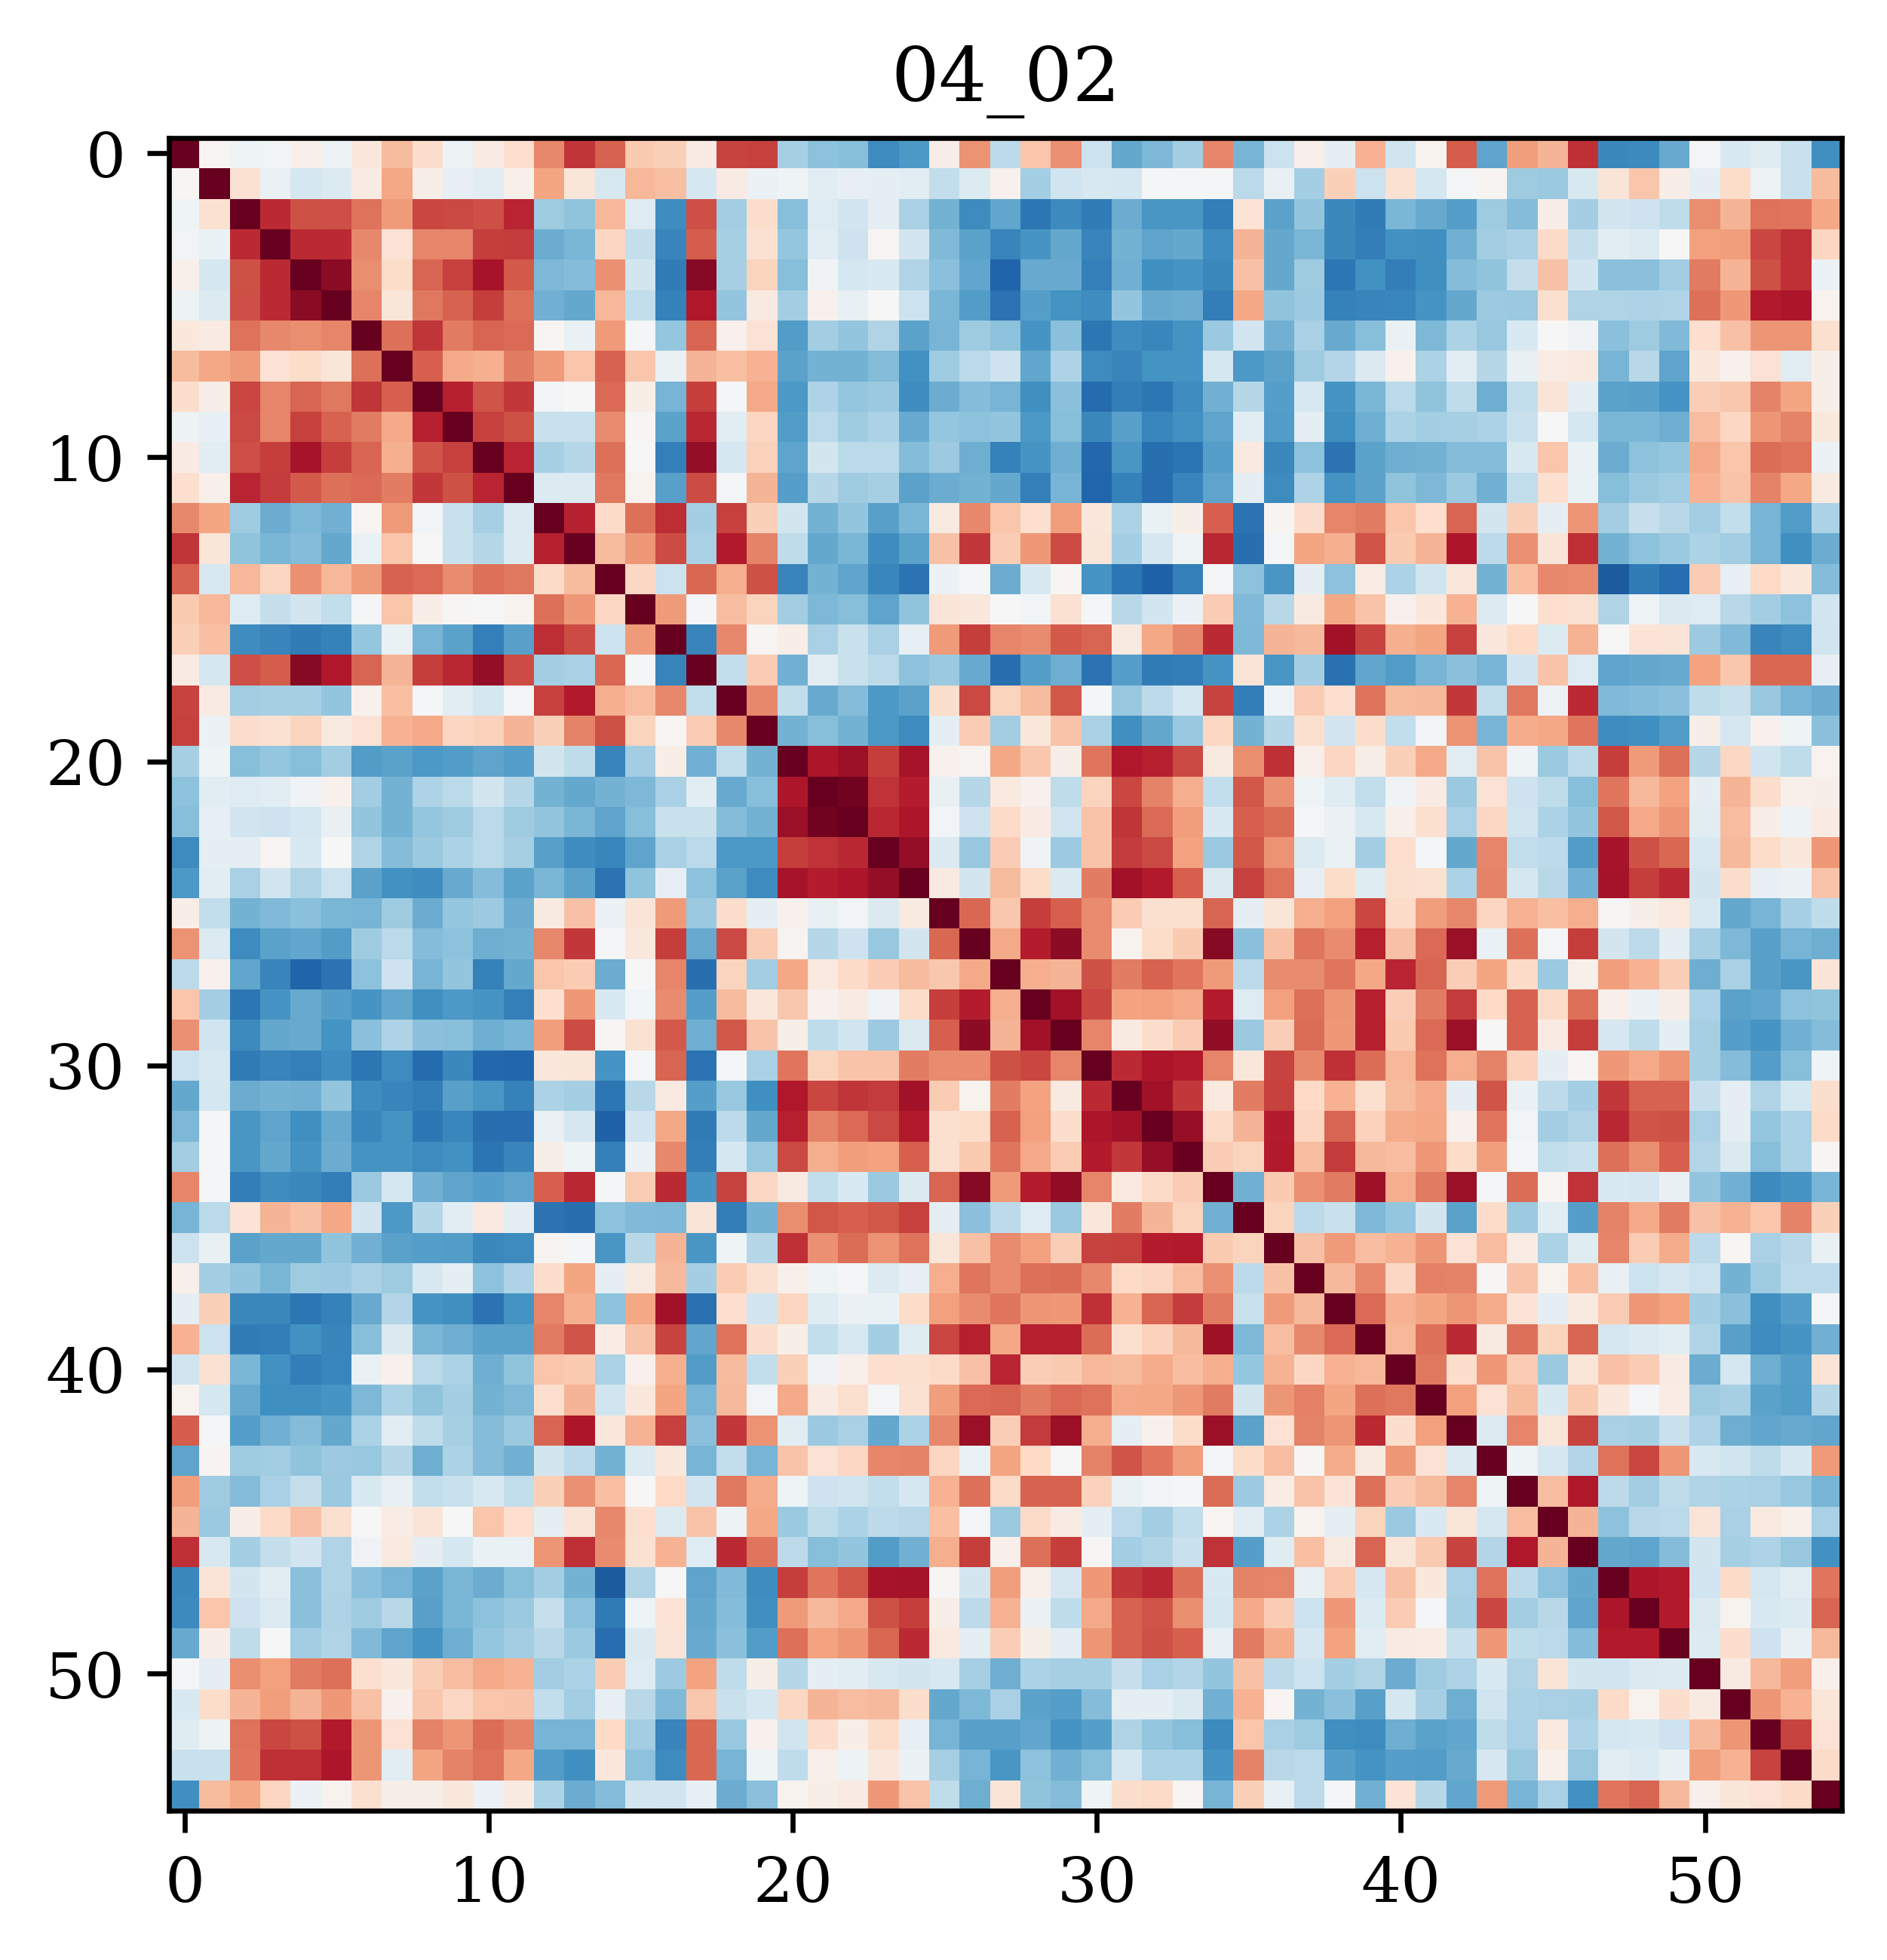

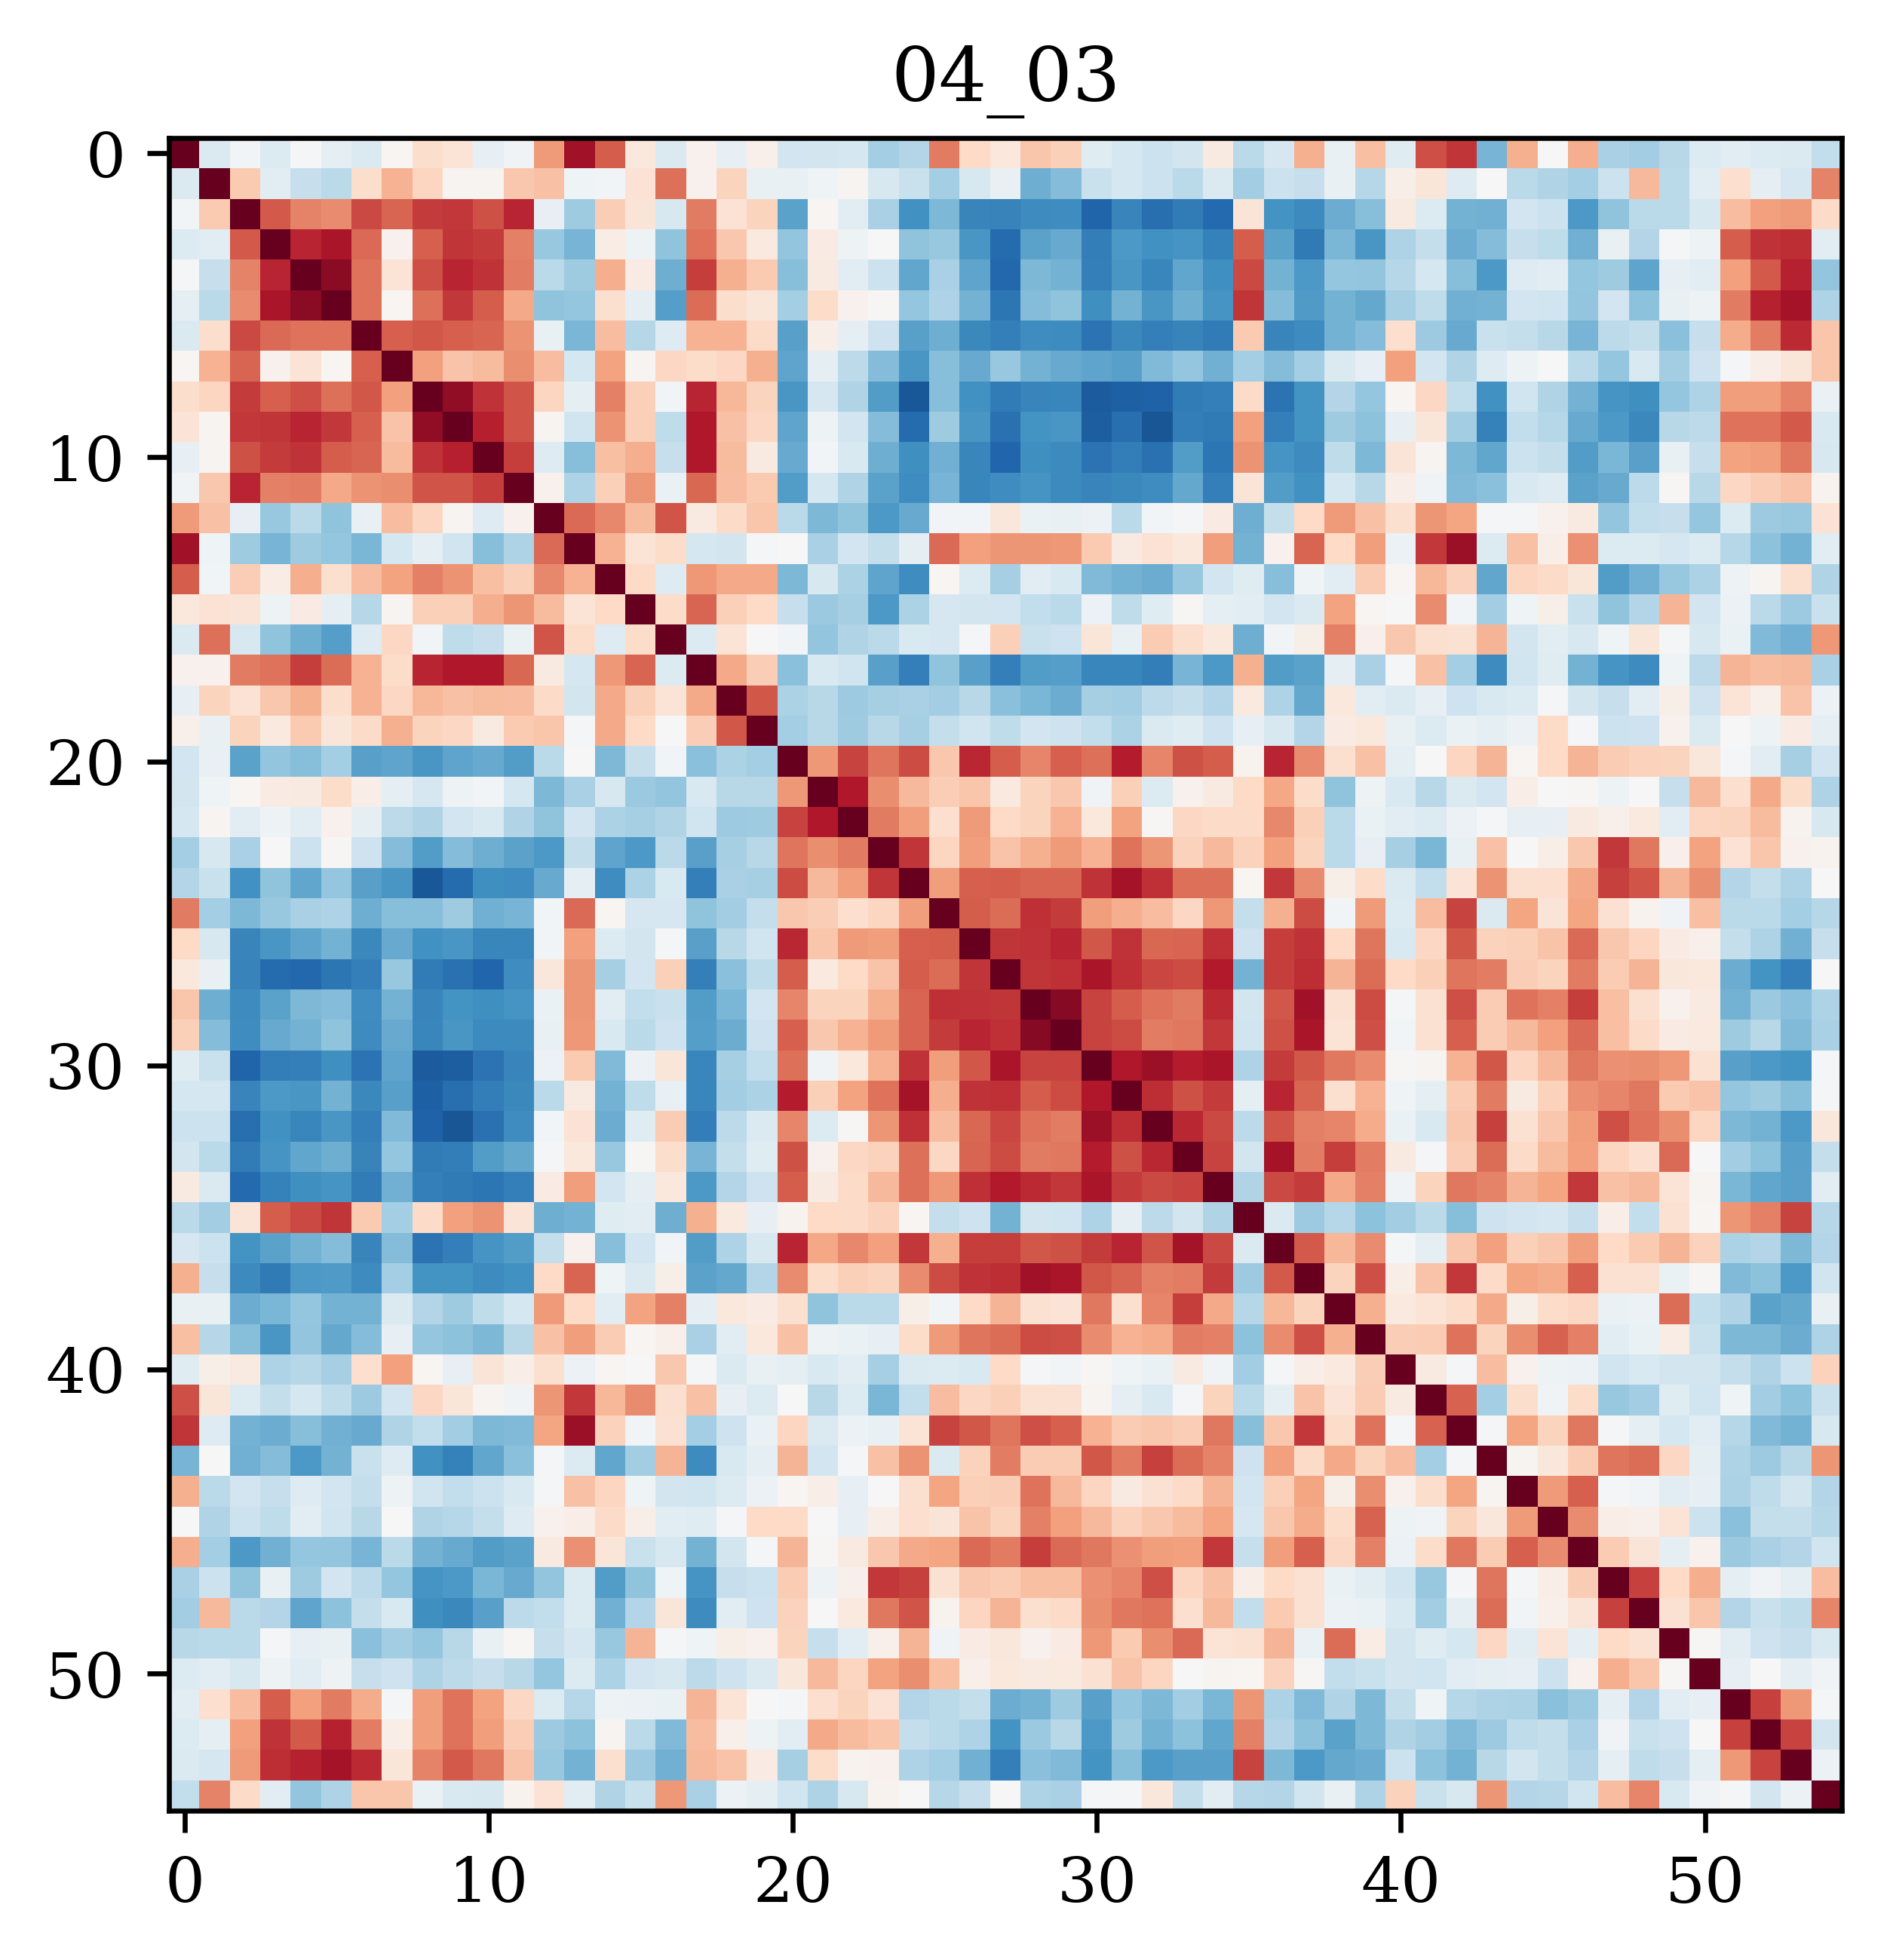

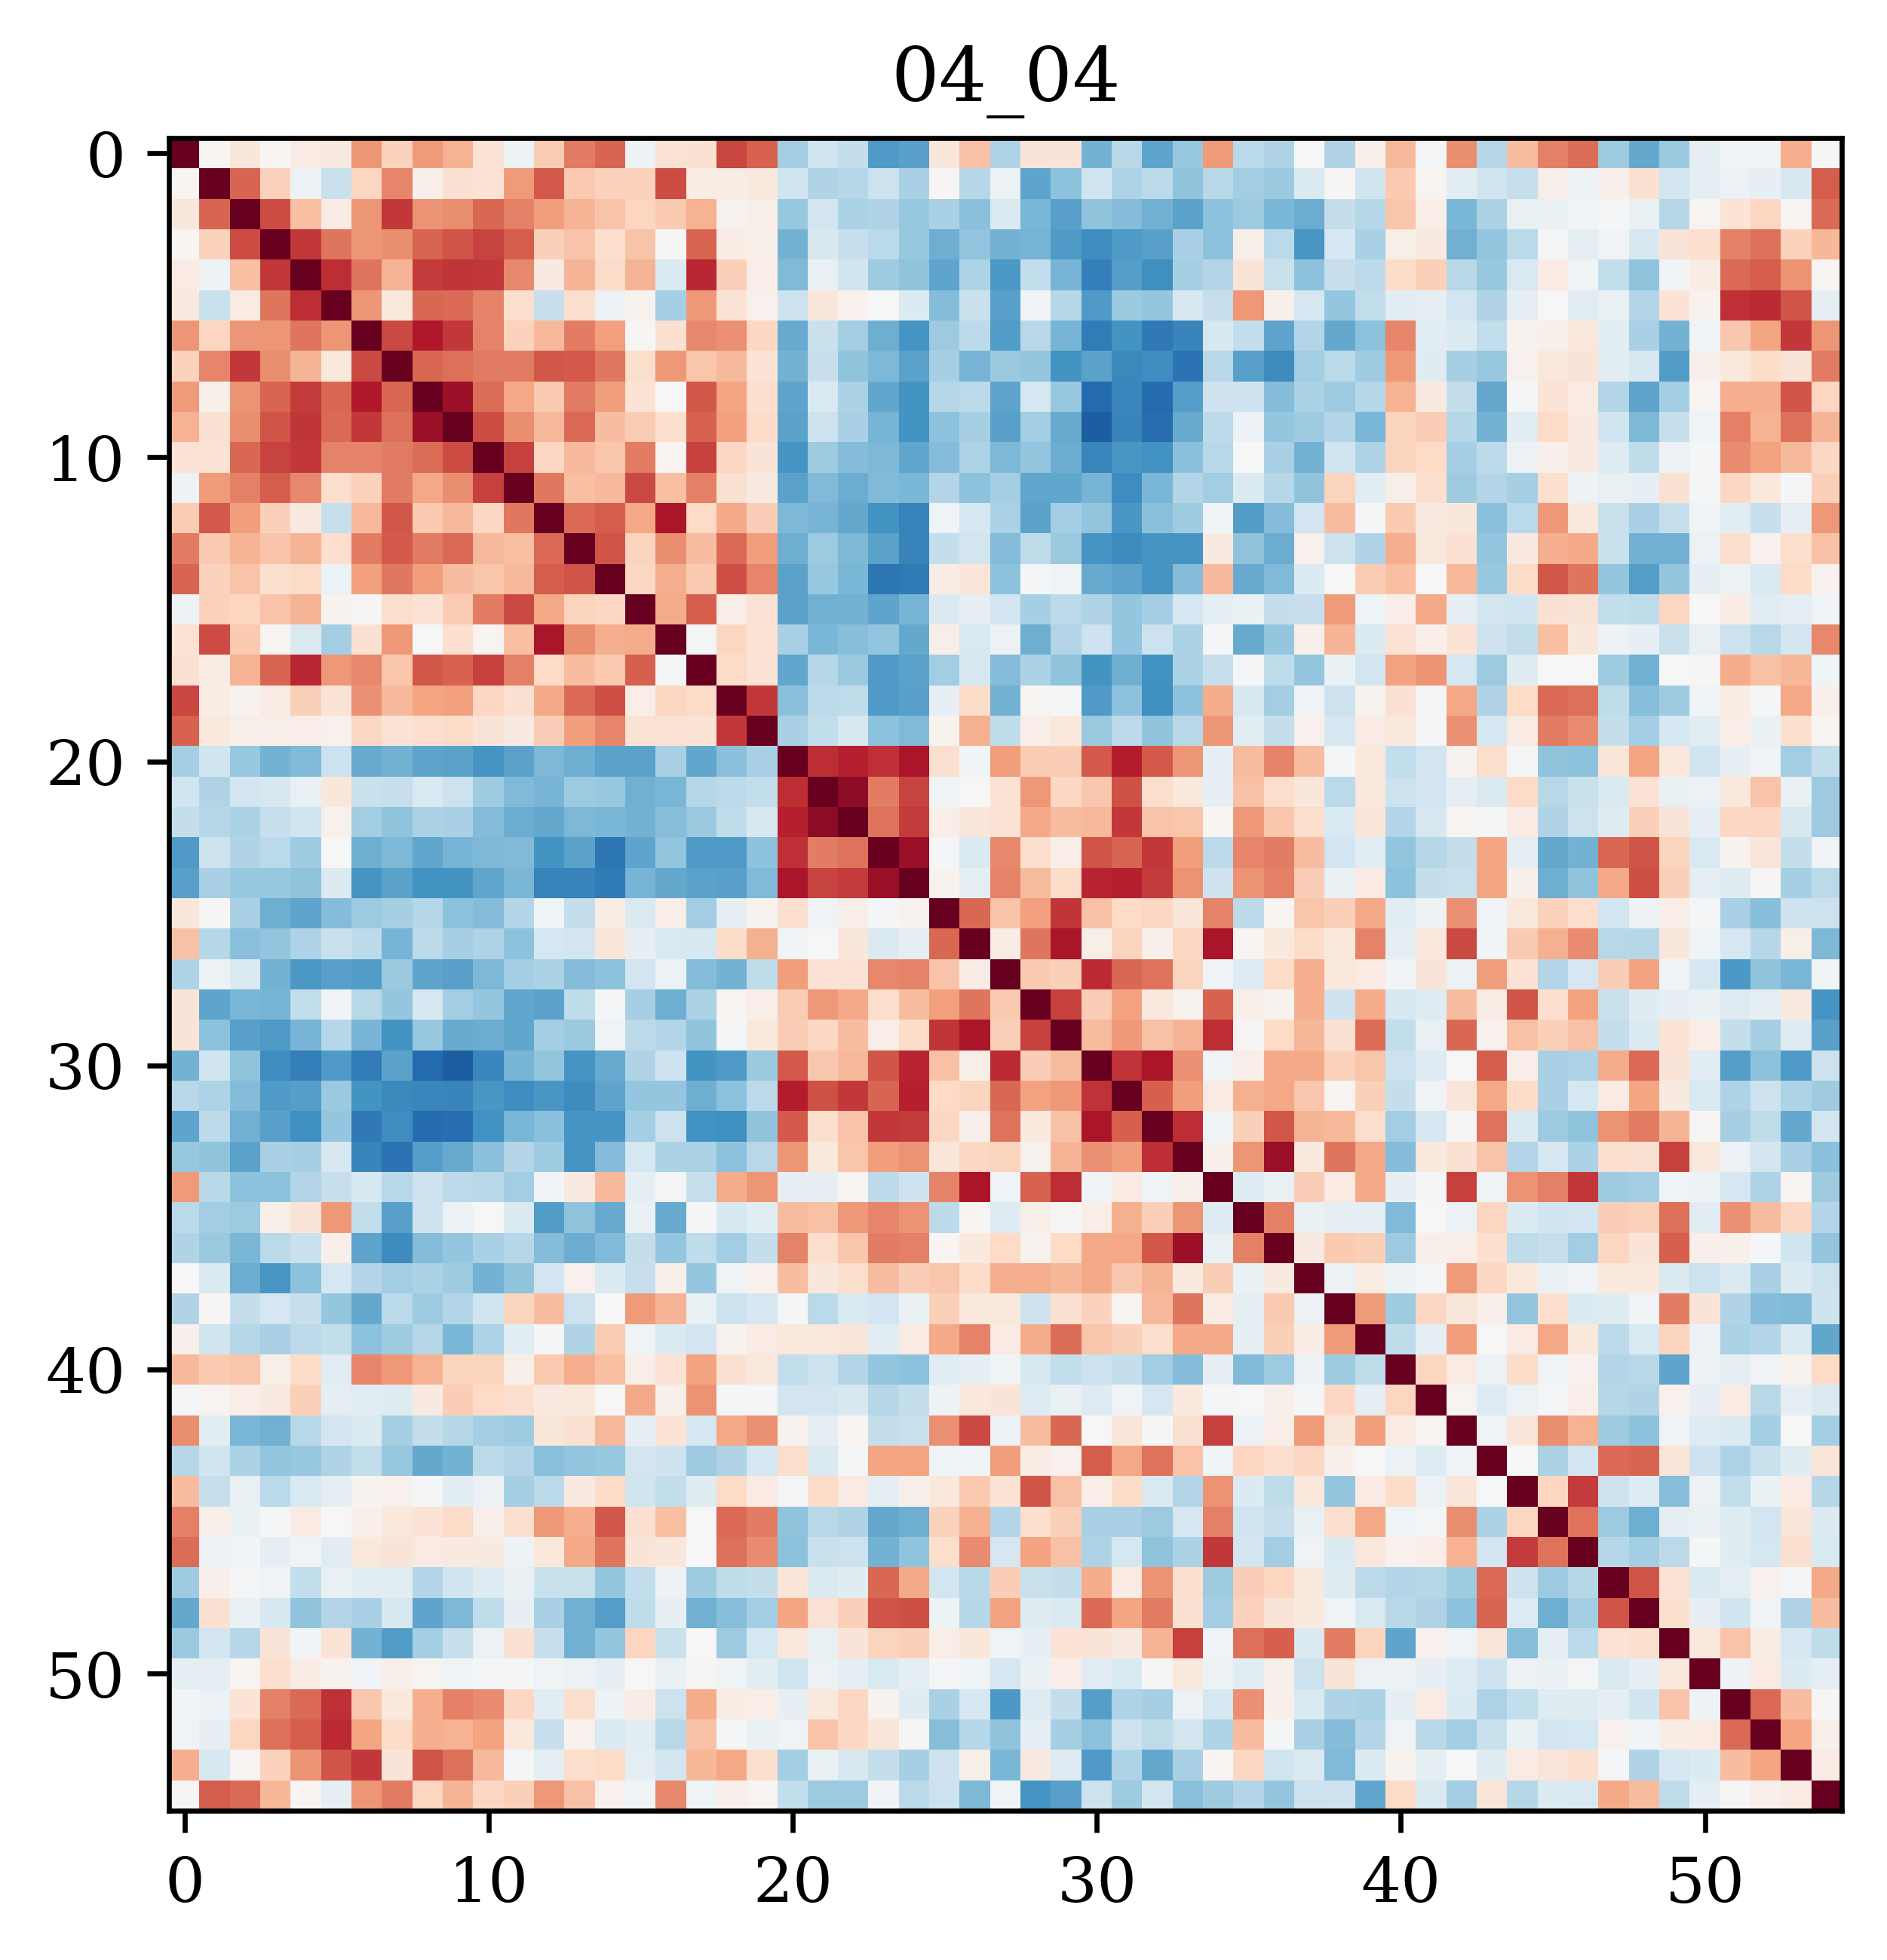

In [7]:
# order all cov mtx's by mouse 01_01 cluster - see if they are similar
for k, v in mouse_cov.items():
    plt.figure()
    plt.imshow(
        v[g.dendrogram_row.reordered_ind][:, g.dendrogram_col.reordered_ind],
        vmin=-1,
        vmax=1,
        cmap="RdBu_r",
    )
    plt.title(k)

In [8]:
from scipy.spatial.distance import squareform, pdist

In [10]:
squareform(((cov + cov.T) / 2) * (1 - np.eye(len(cov))))

array([-0.26780356, -0.16114146, -0.37528595, ...,  0.57515766,
        0.35604071,  0.03491143])

In [11]:
sq = valmap(lambda cov: squareform(((cov + cov.T) / 2) * (1 - np.eye(len(cov)))), mouse_cov)

In [12]:
all_cov = np.concatenate([x[None] for x in sq.values()], axis=0)

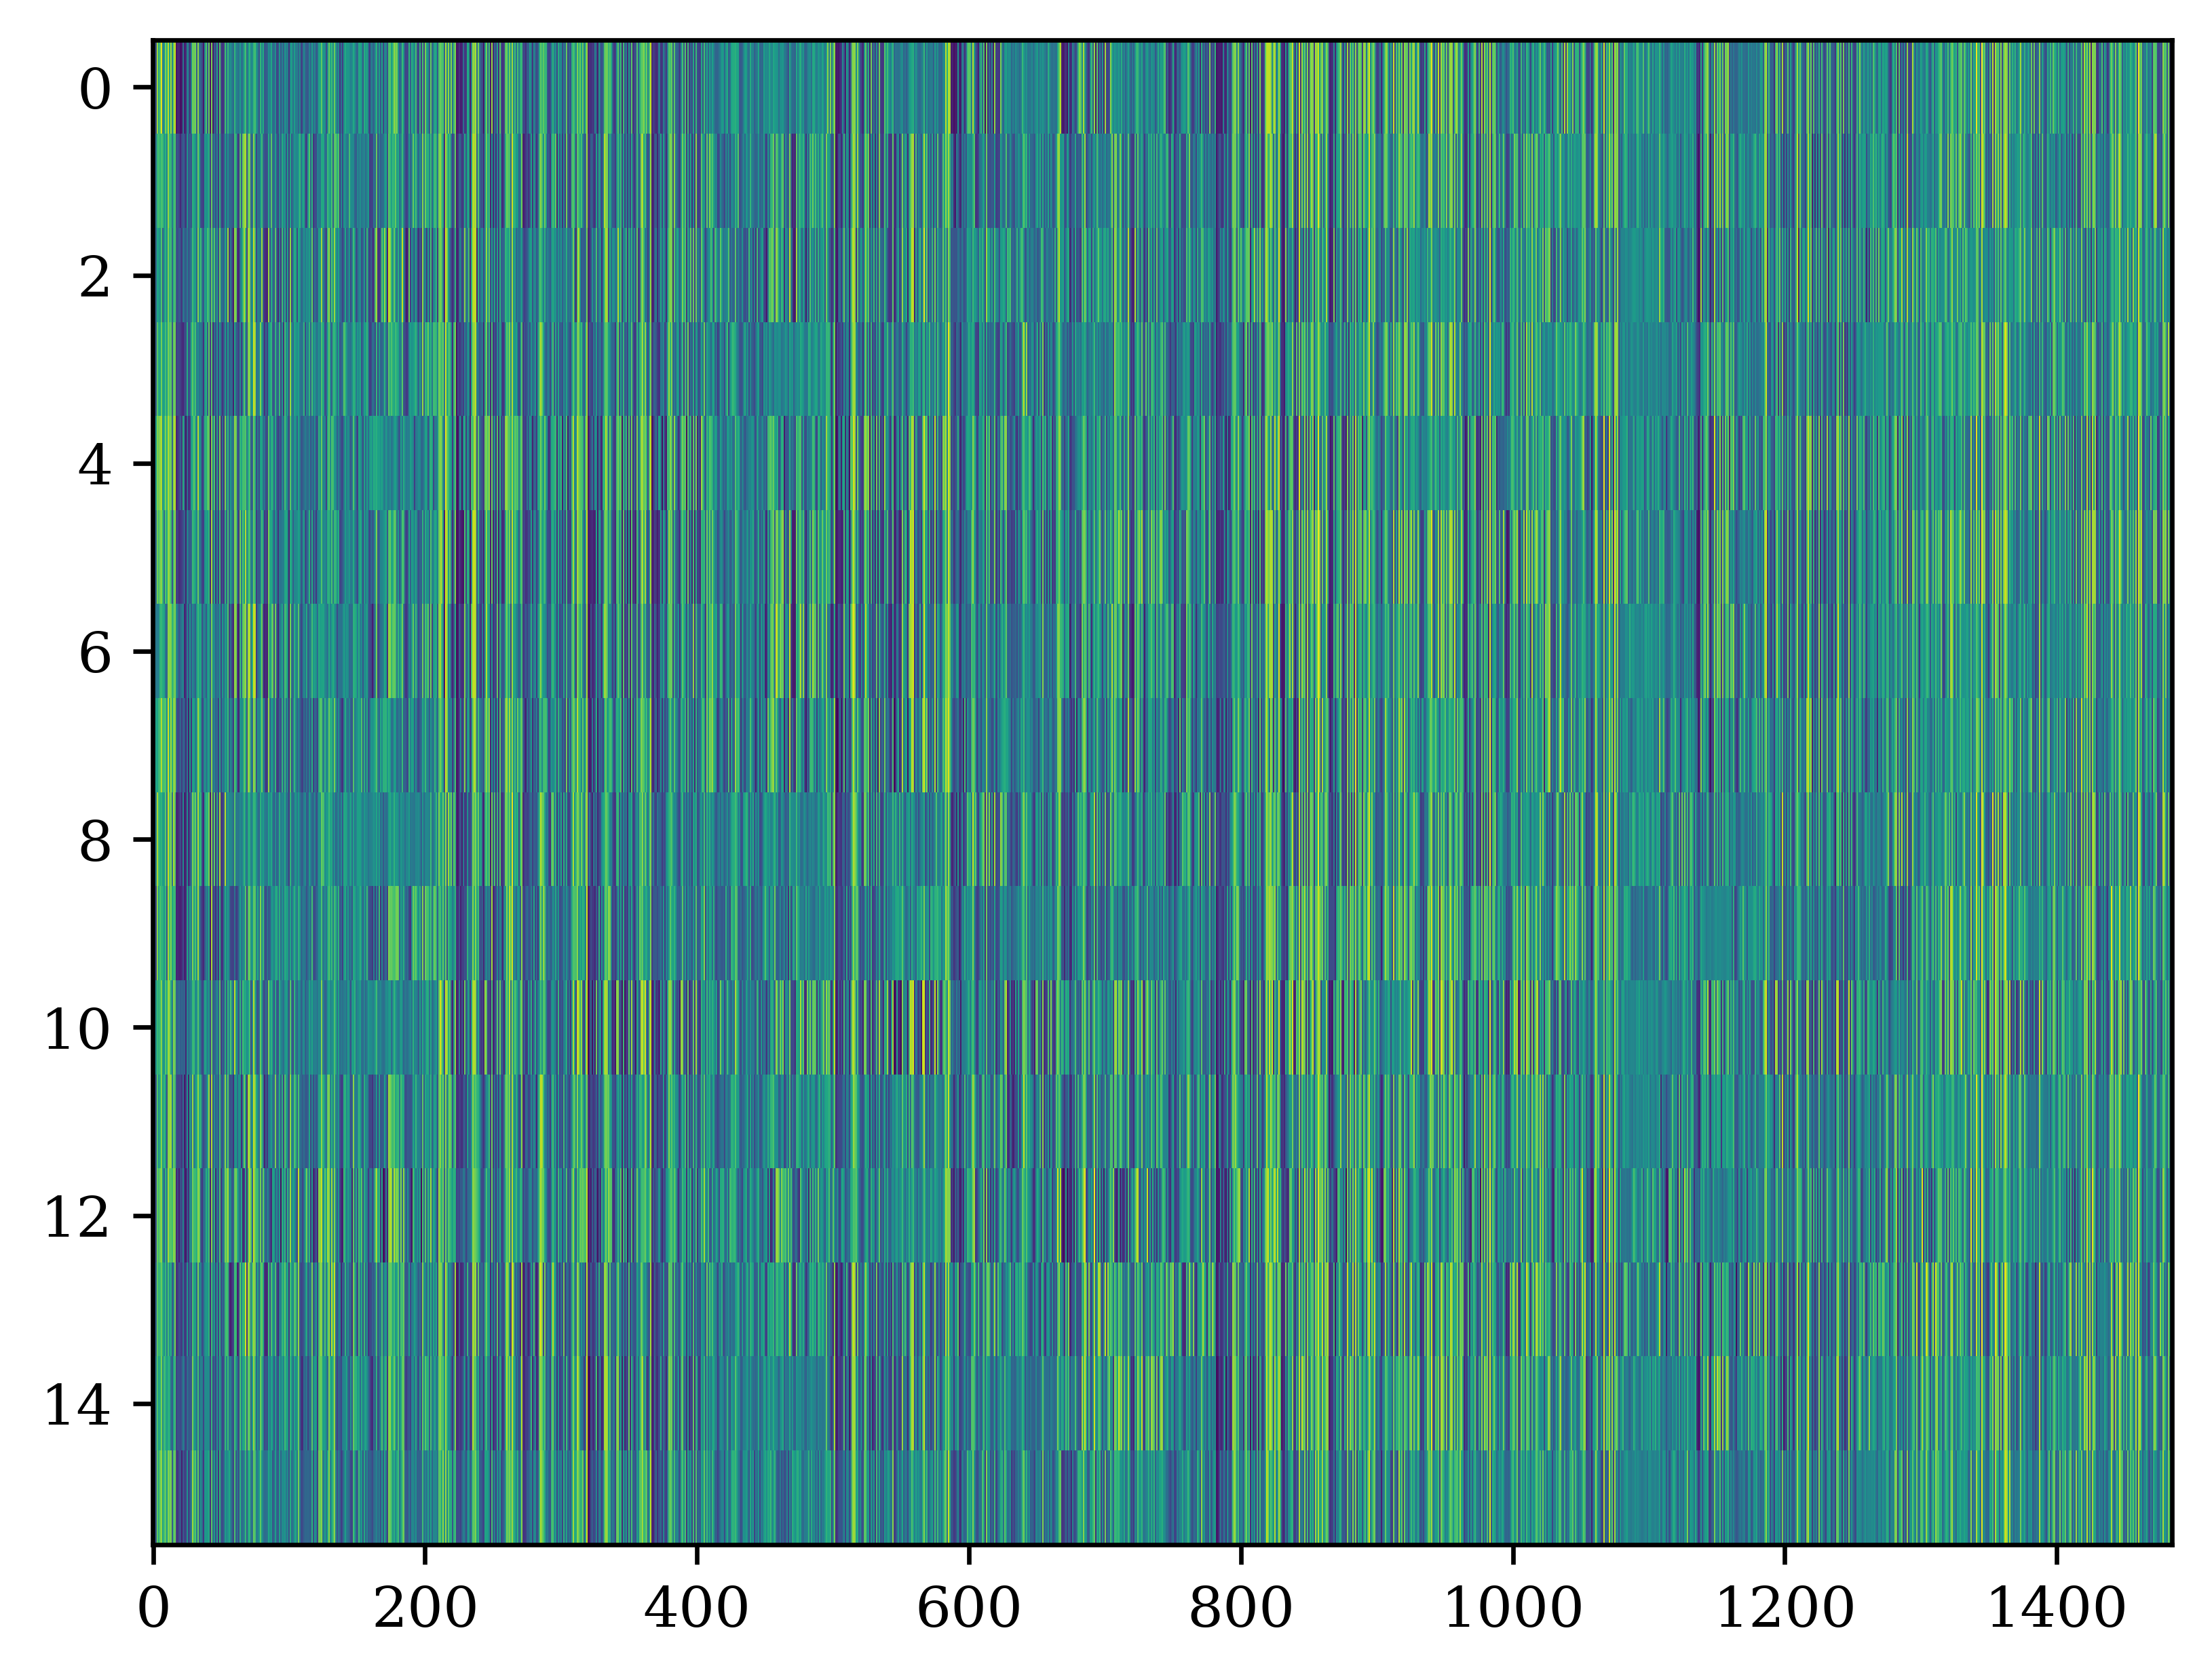

In [13]:
plt.imshow(all_cov, aspect='auto', interpolation='none')

In [14]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA(n_components=6)
out = pca.fit_transform(all_cov)

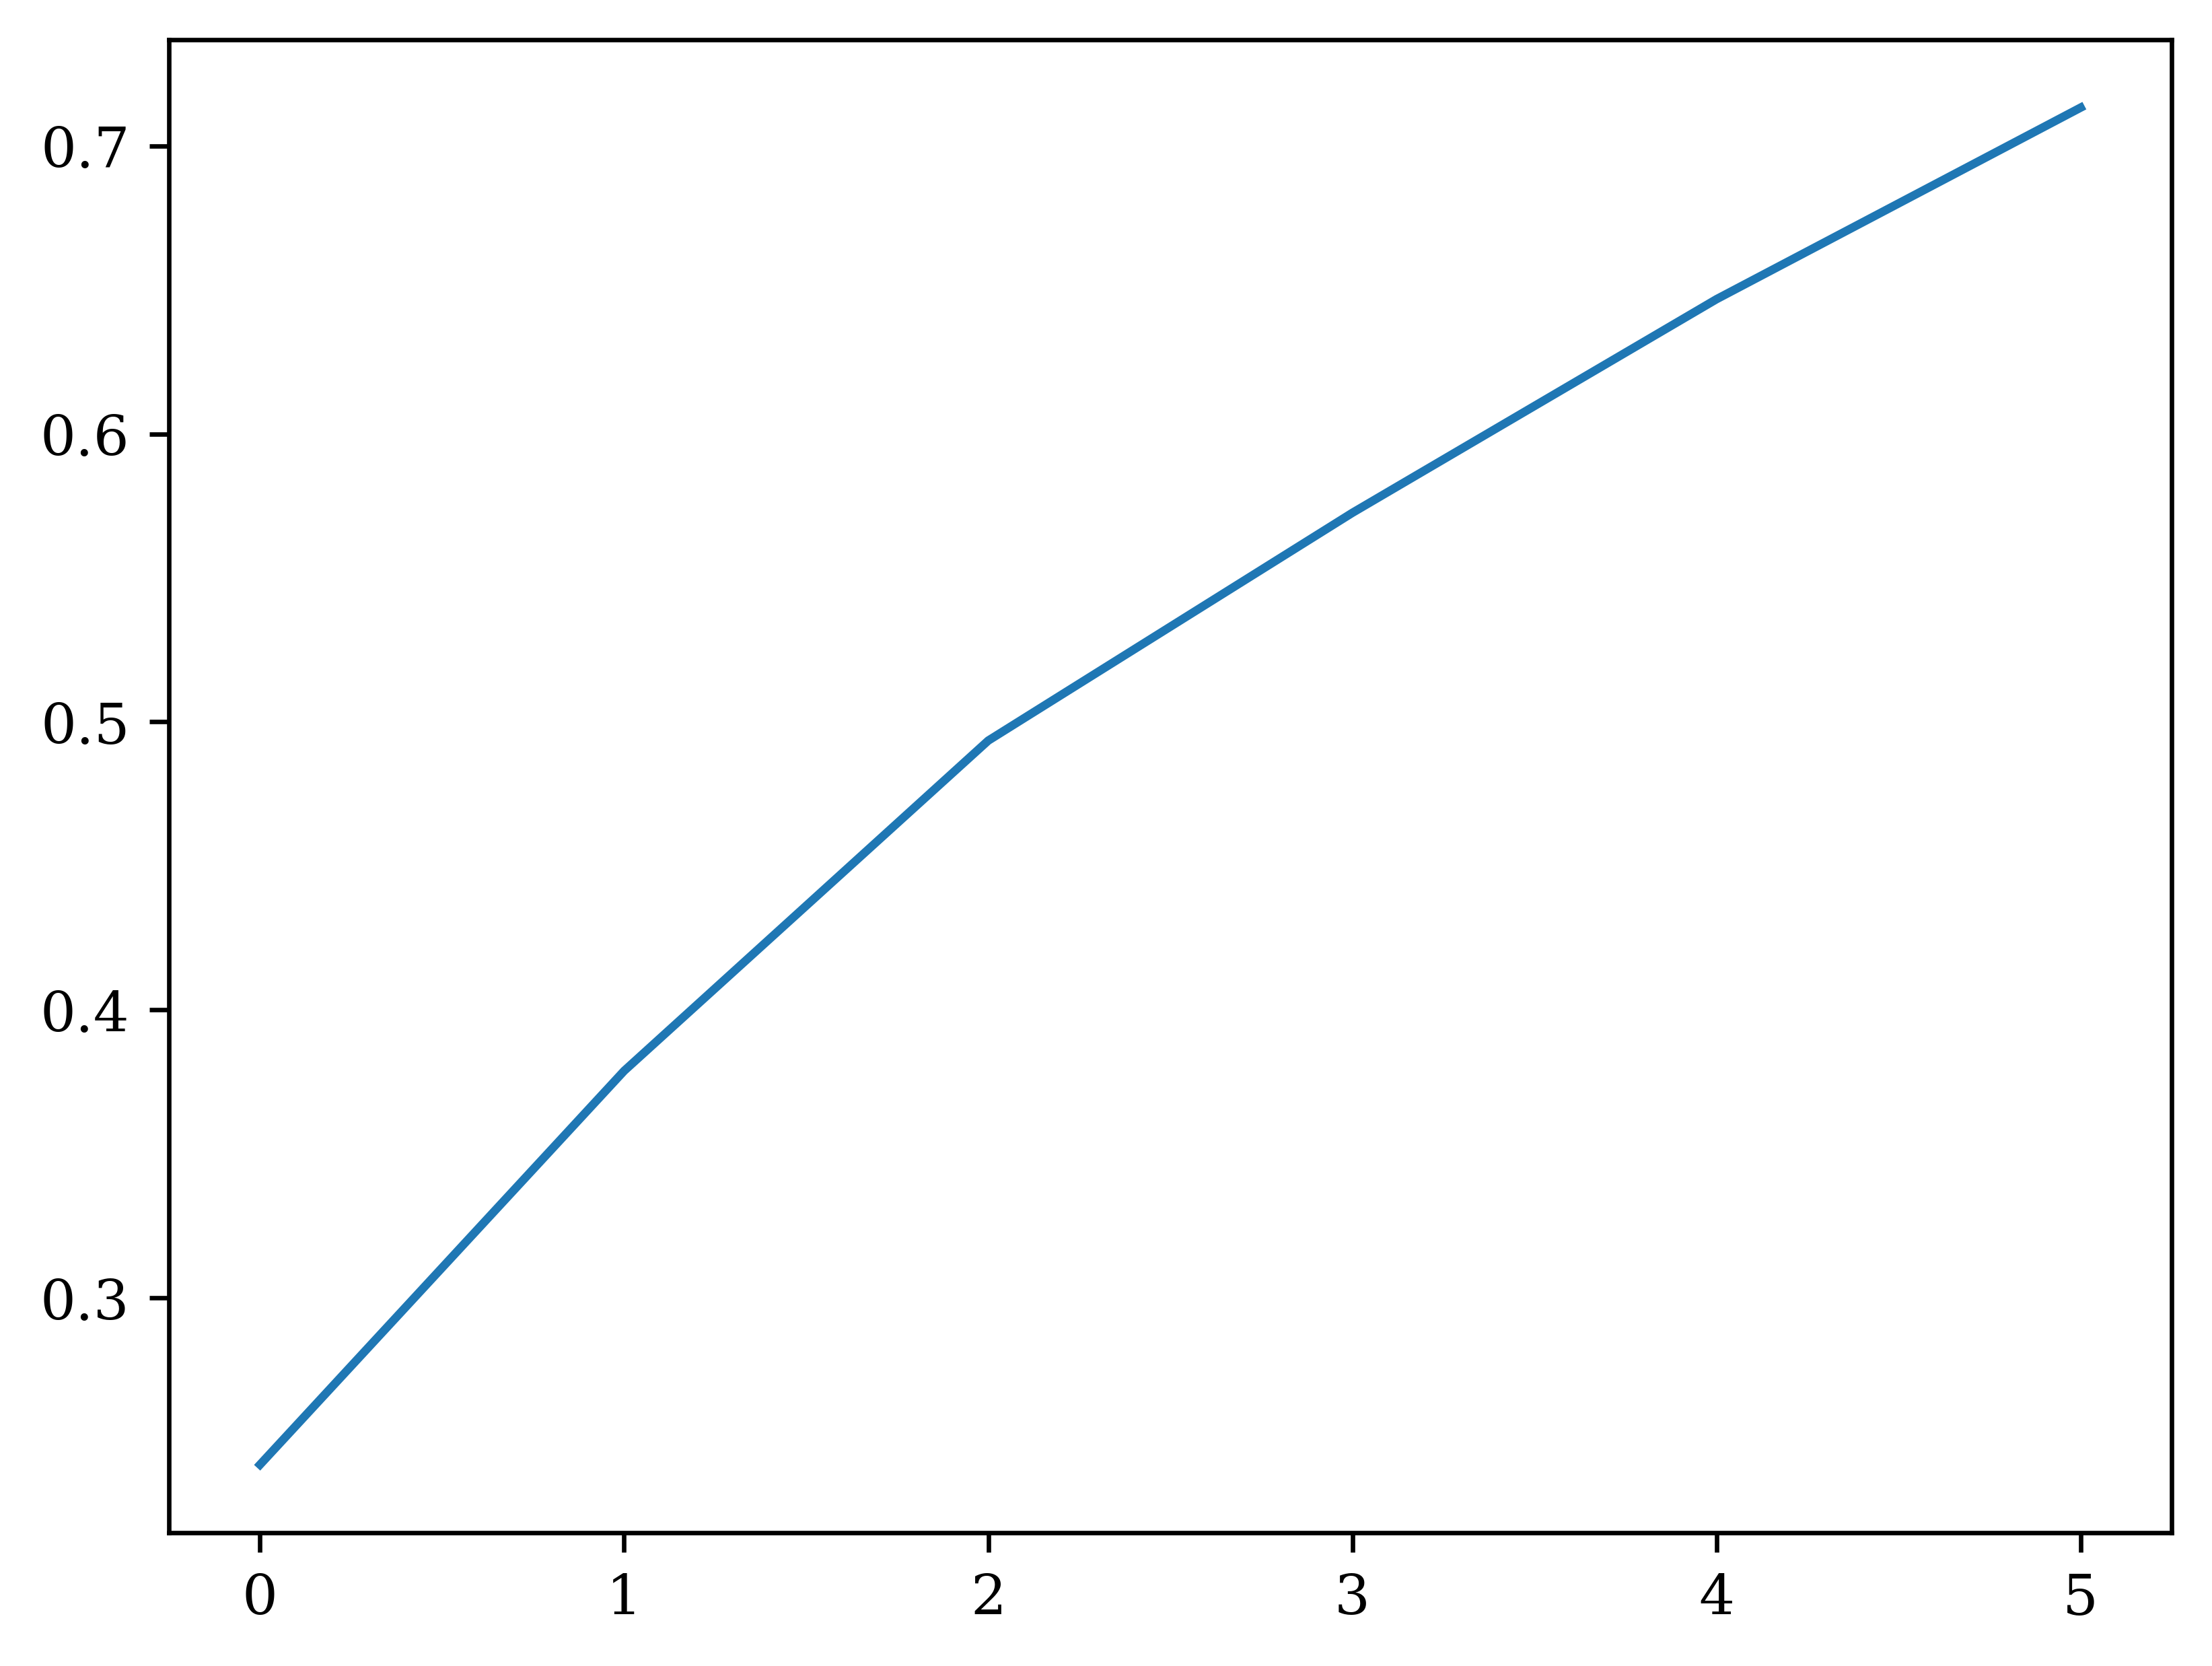

In [16]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [17]:
out.shape

(16, 6)

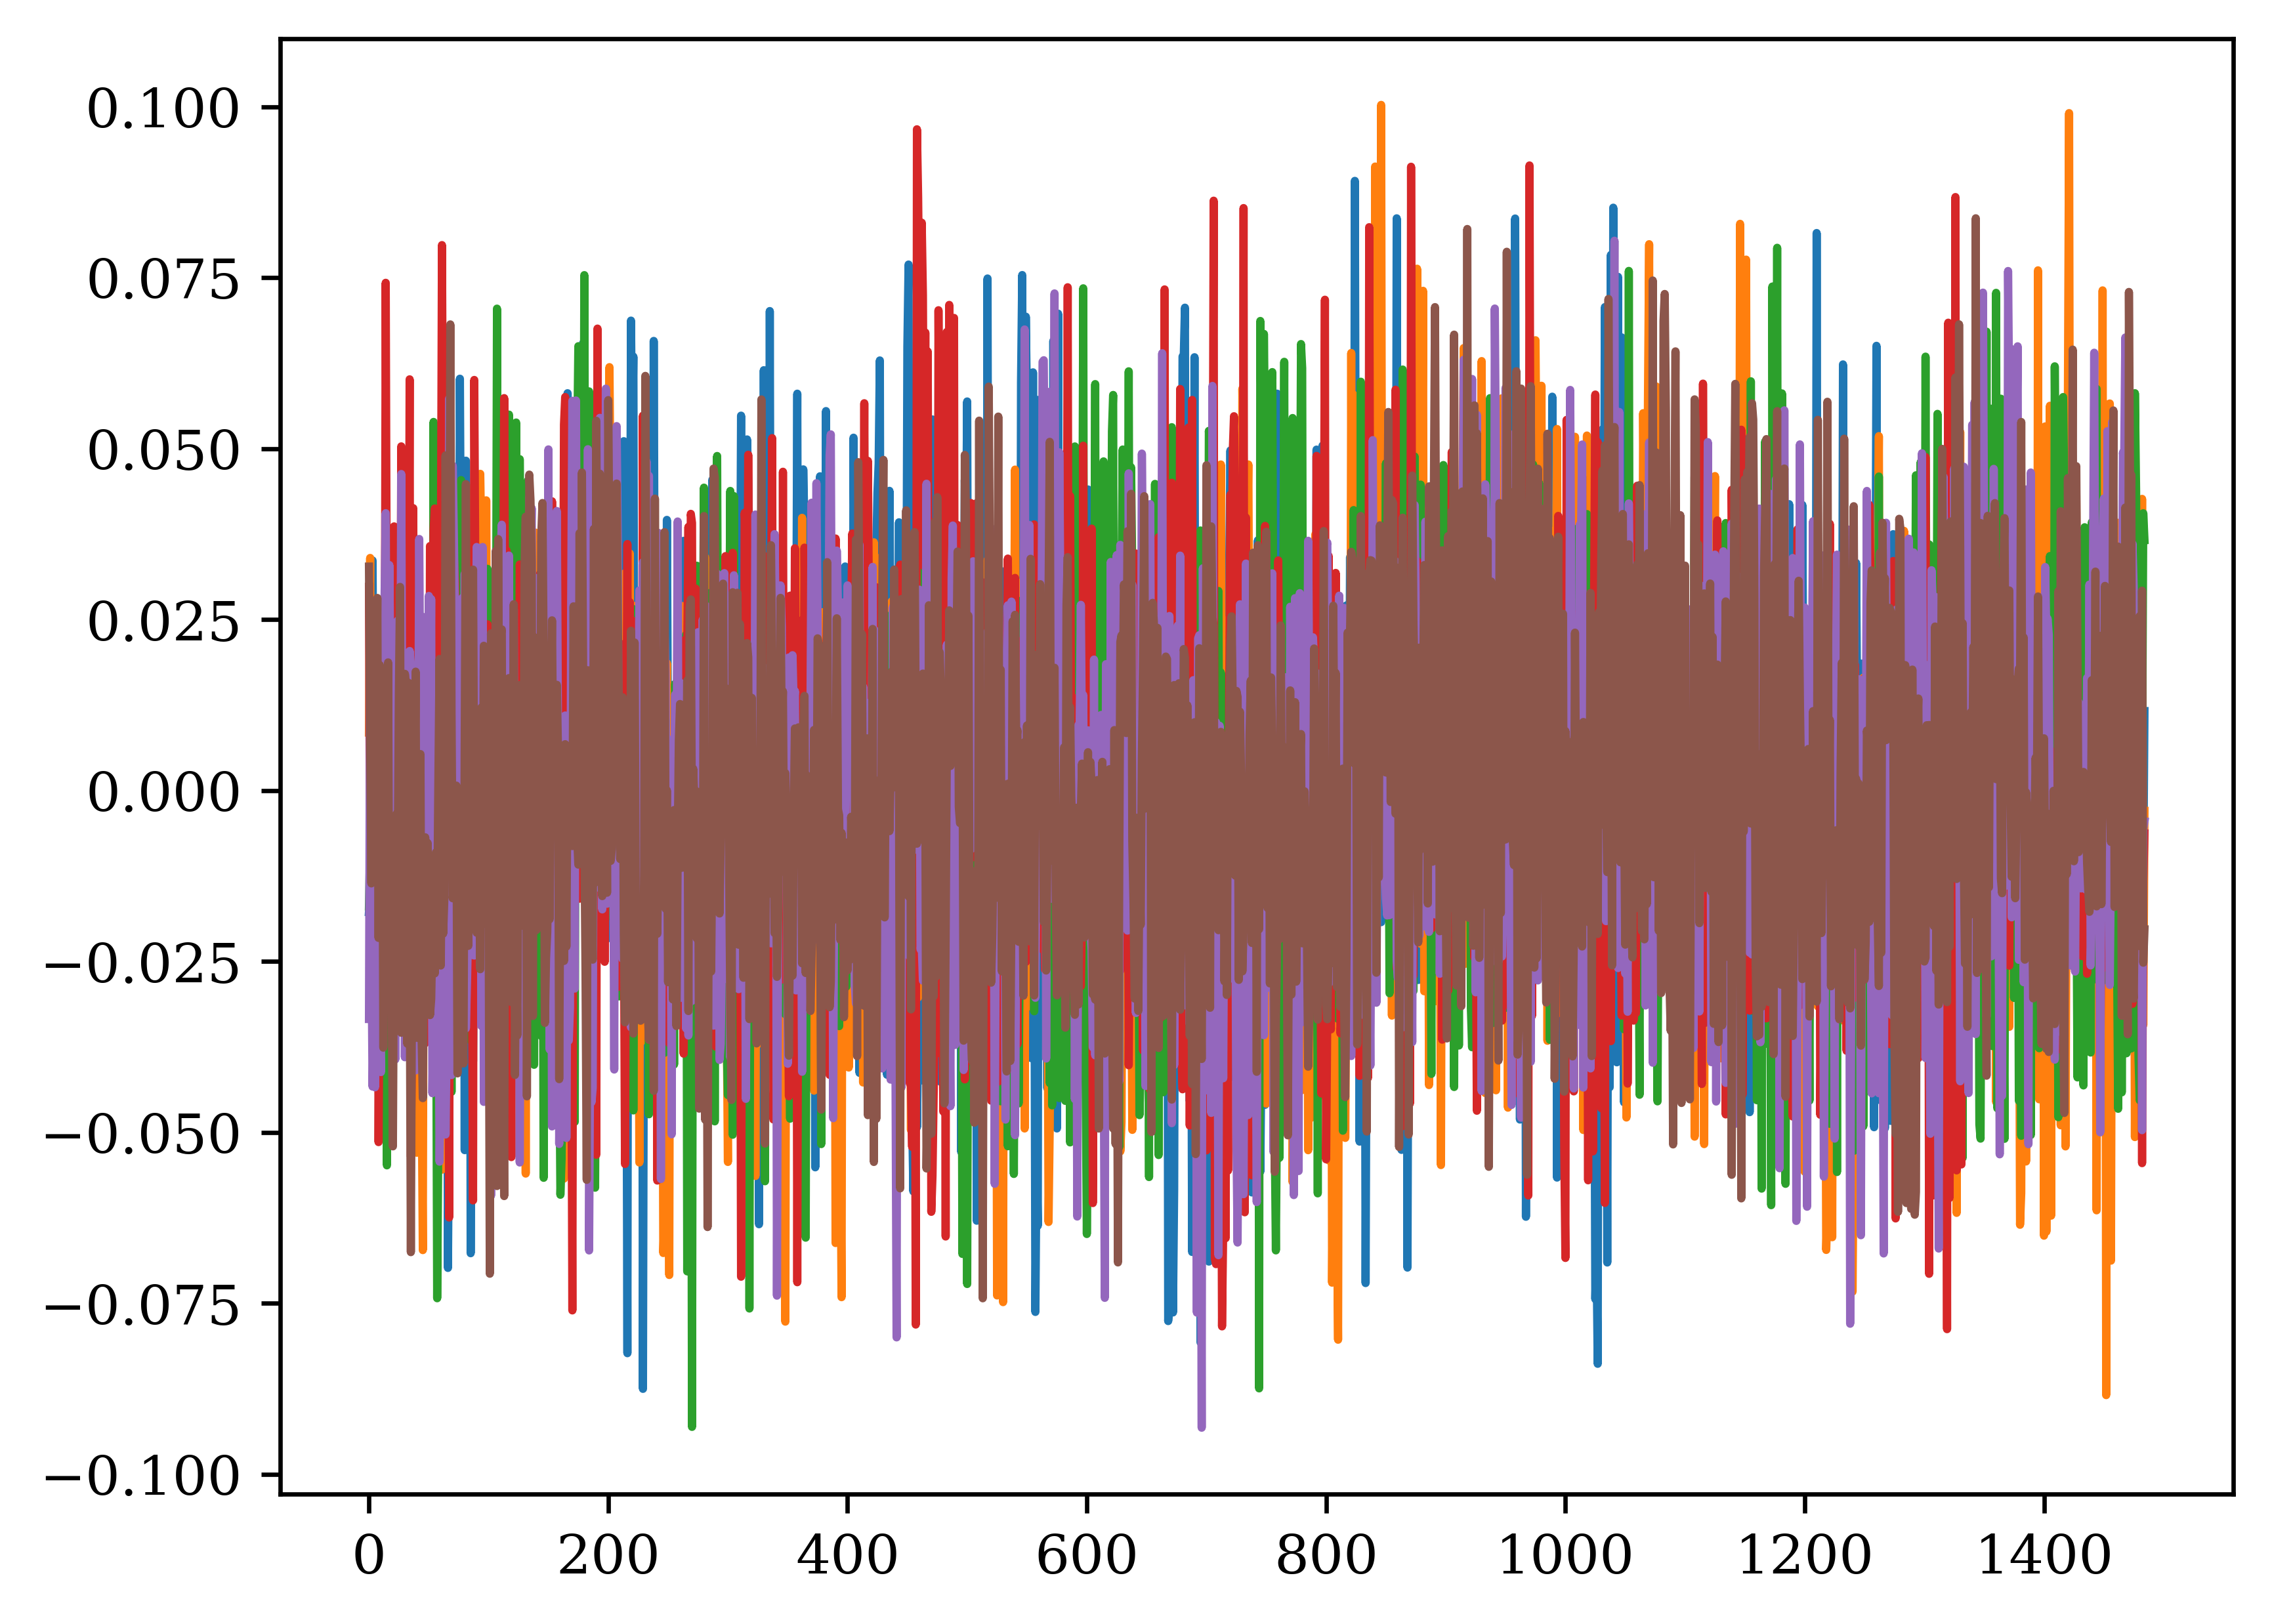

In [18]:
plt.plot(pca.components_.T)

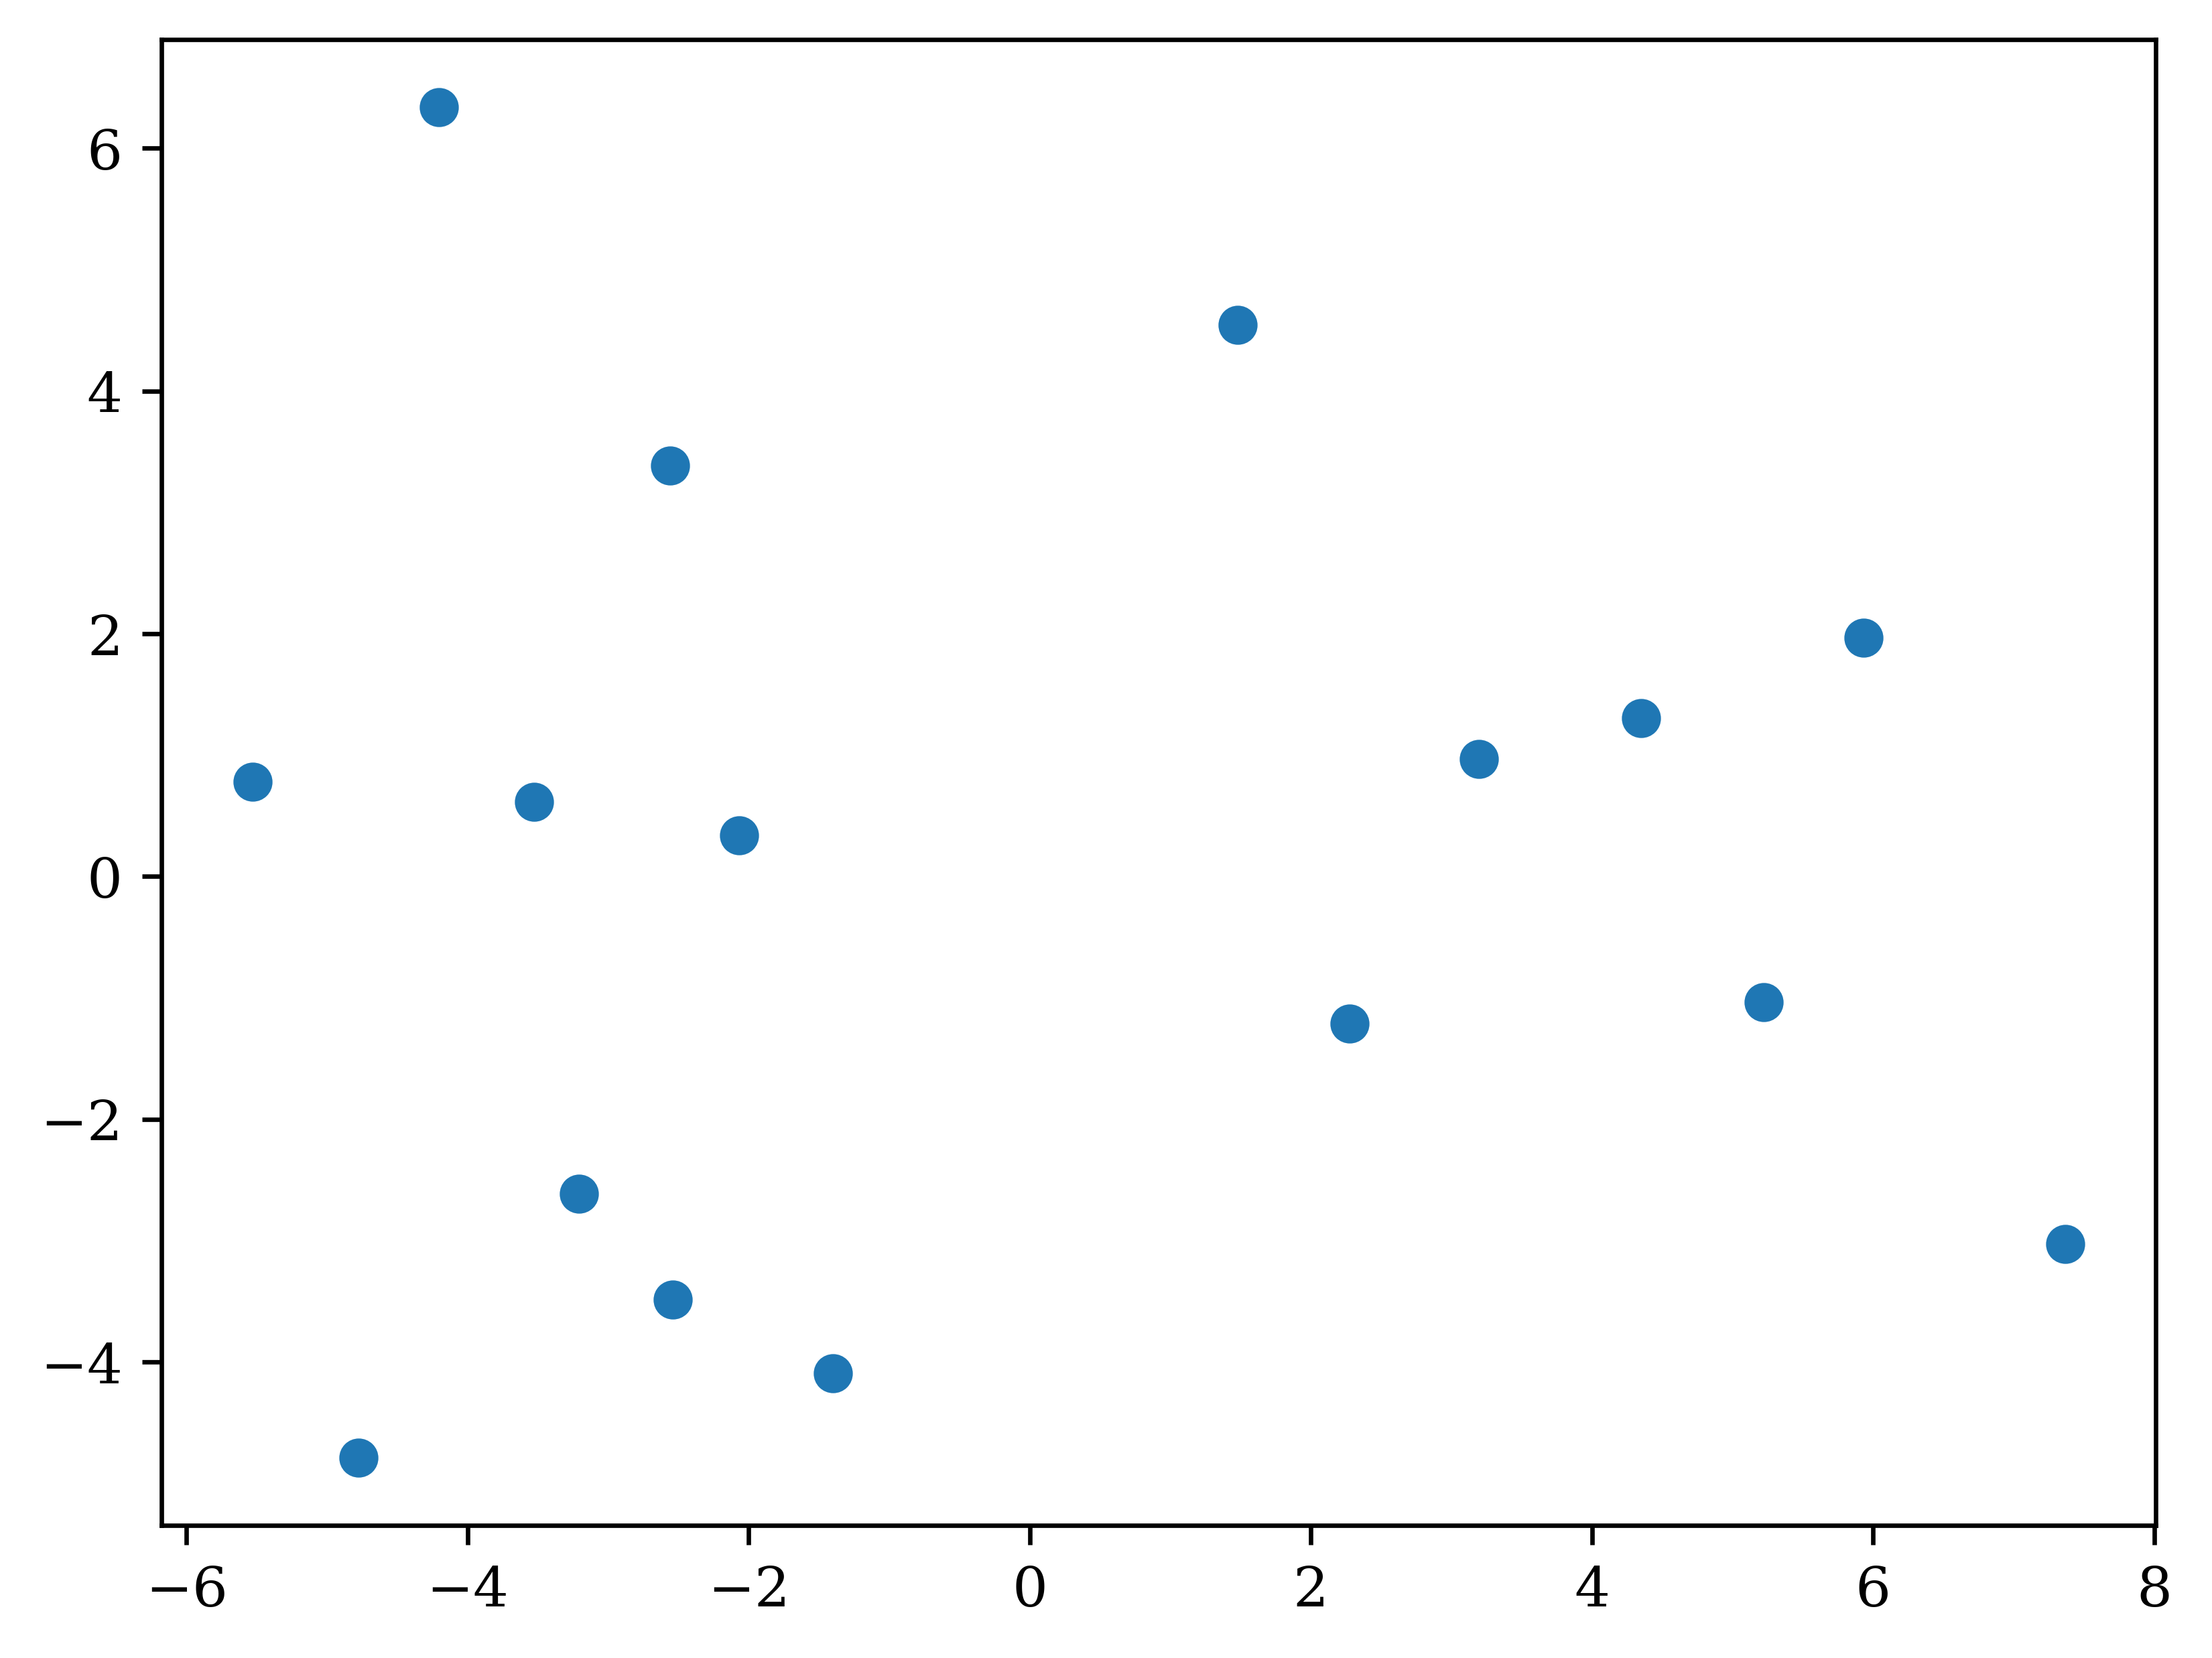

In [19]:
plt.scatter(out[:, 0], out[:, 1])

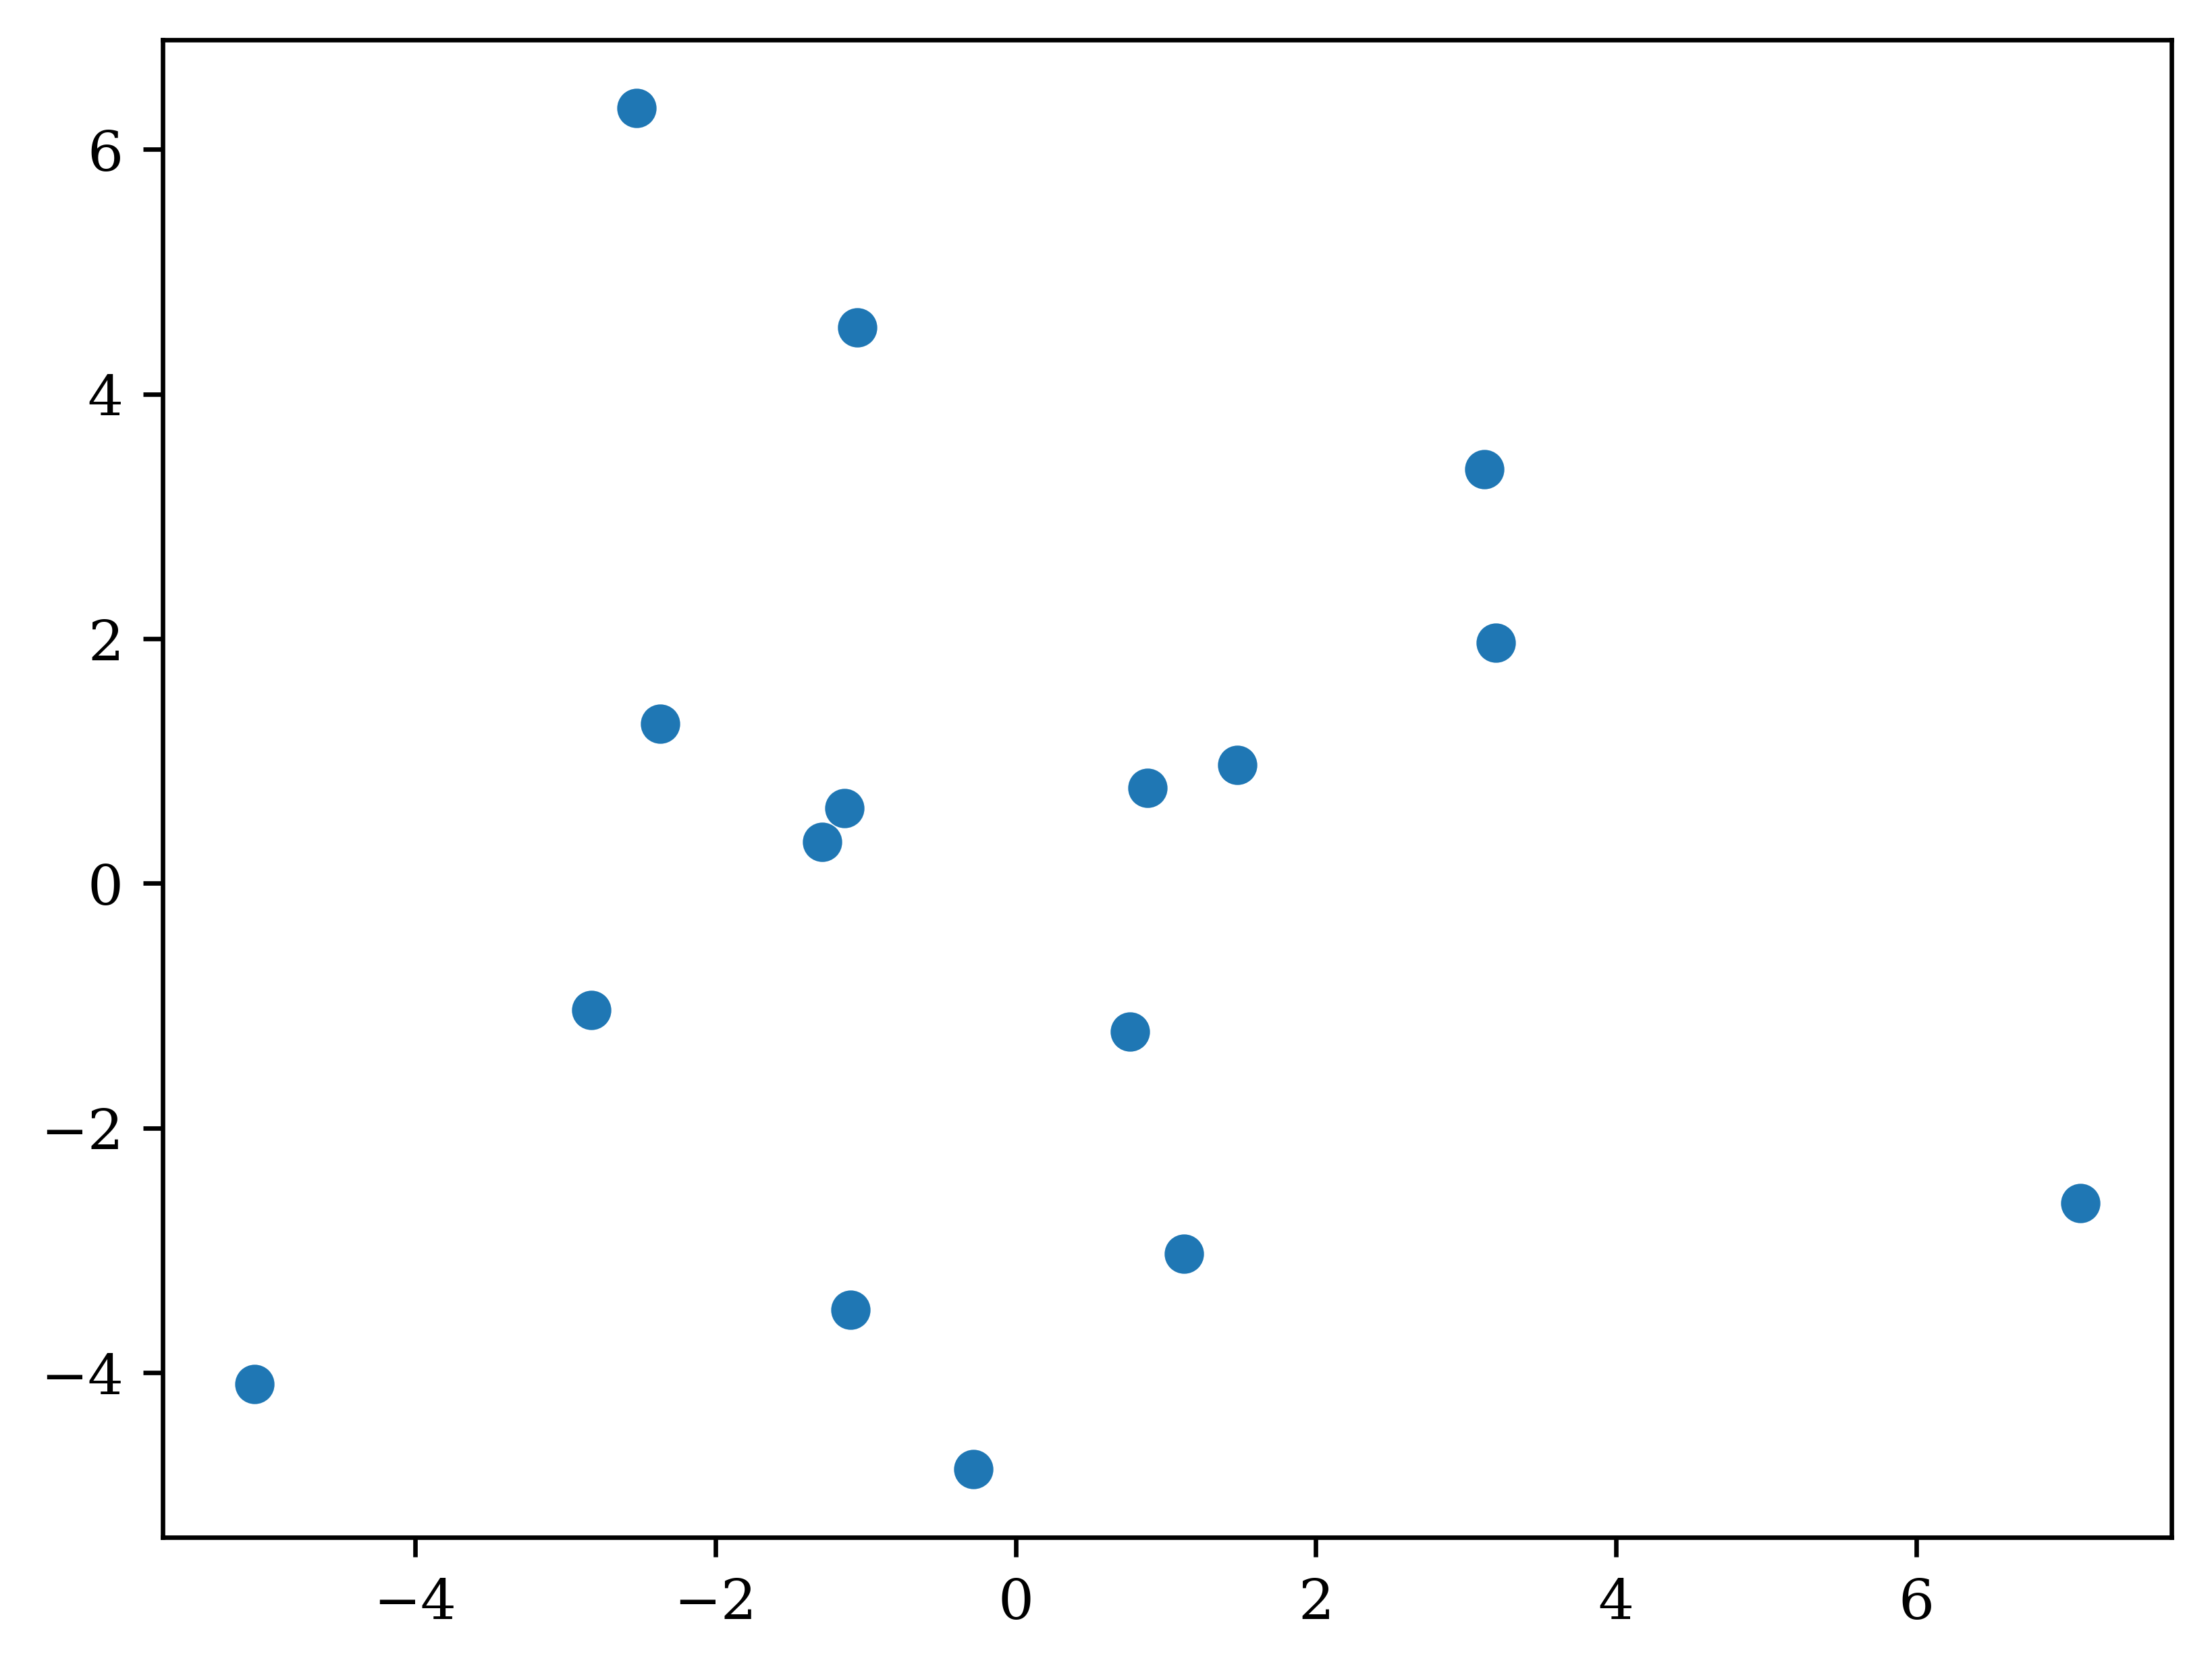

In [20]:
plt.scatter(out[:, 2], out[:, 1])

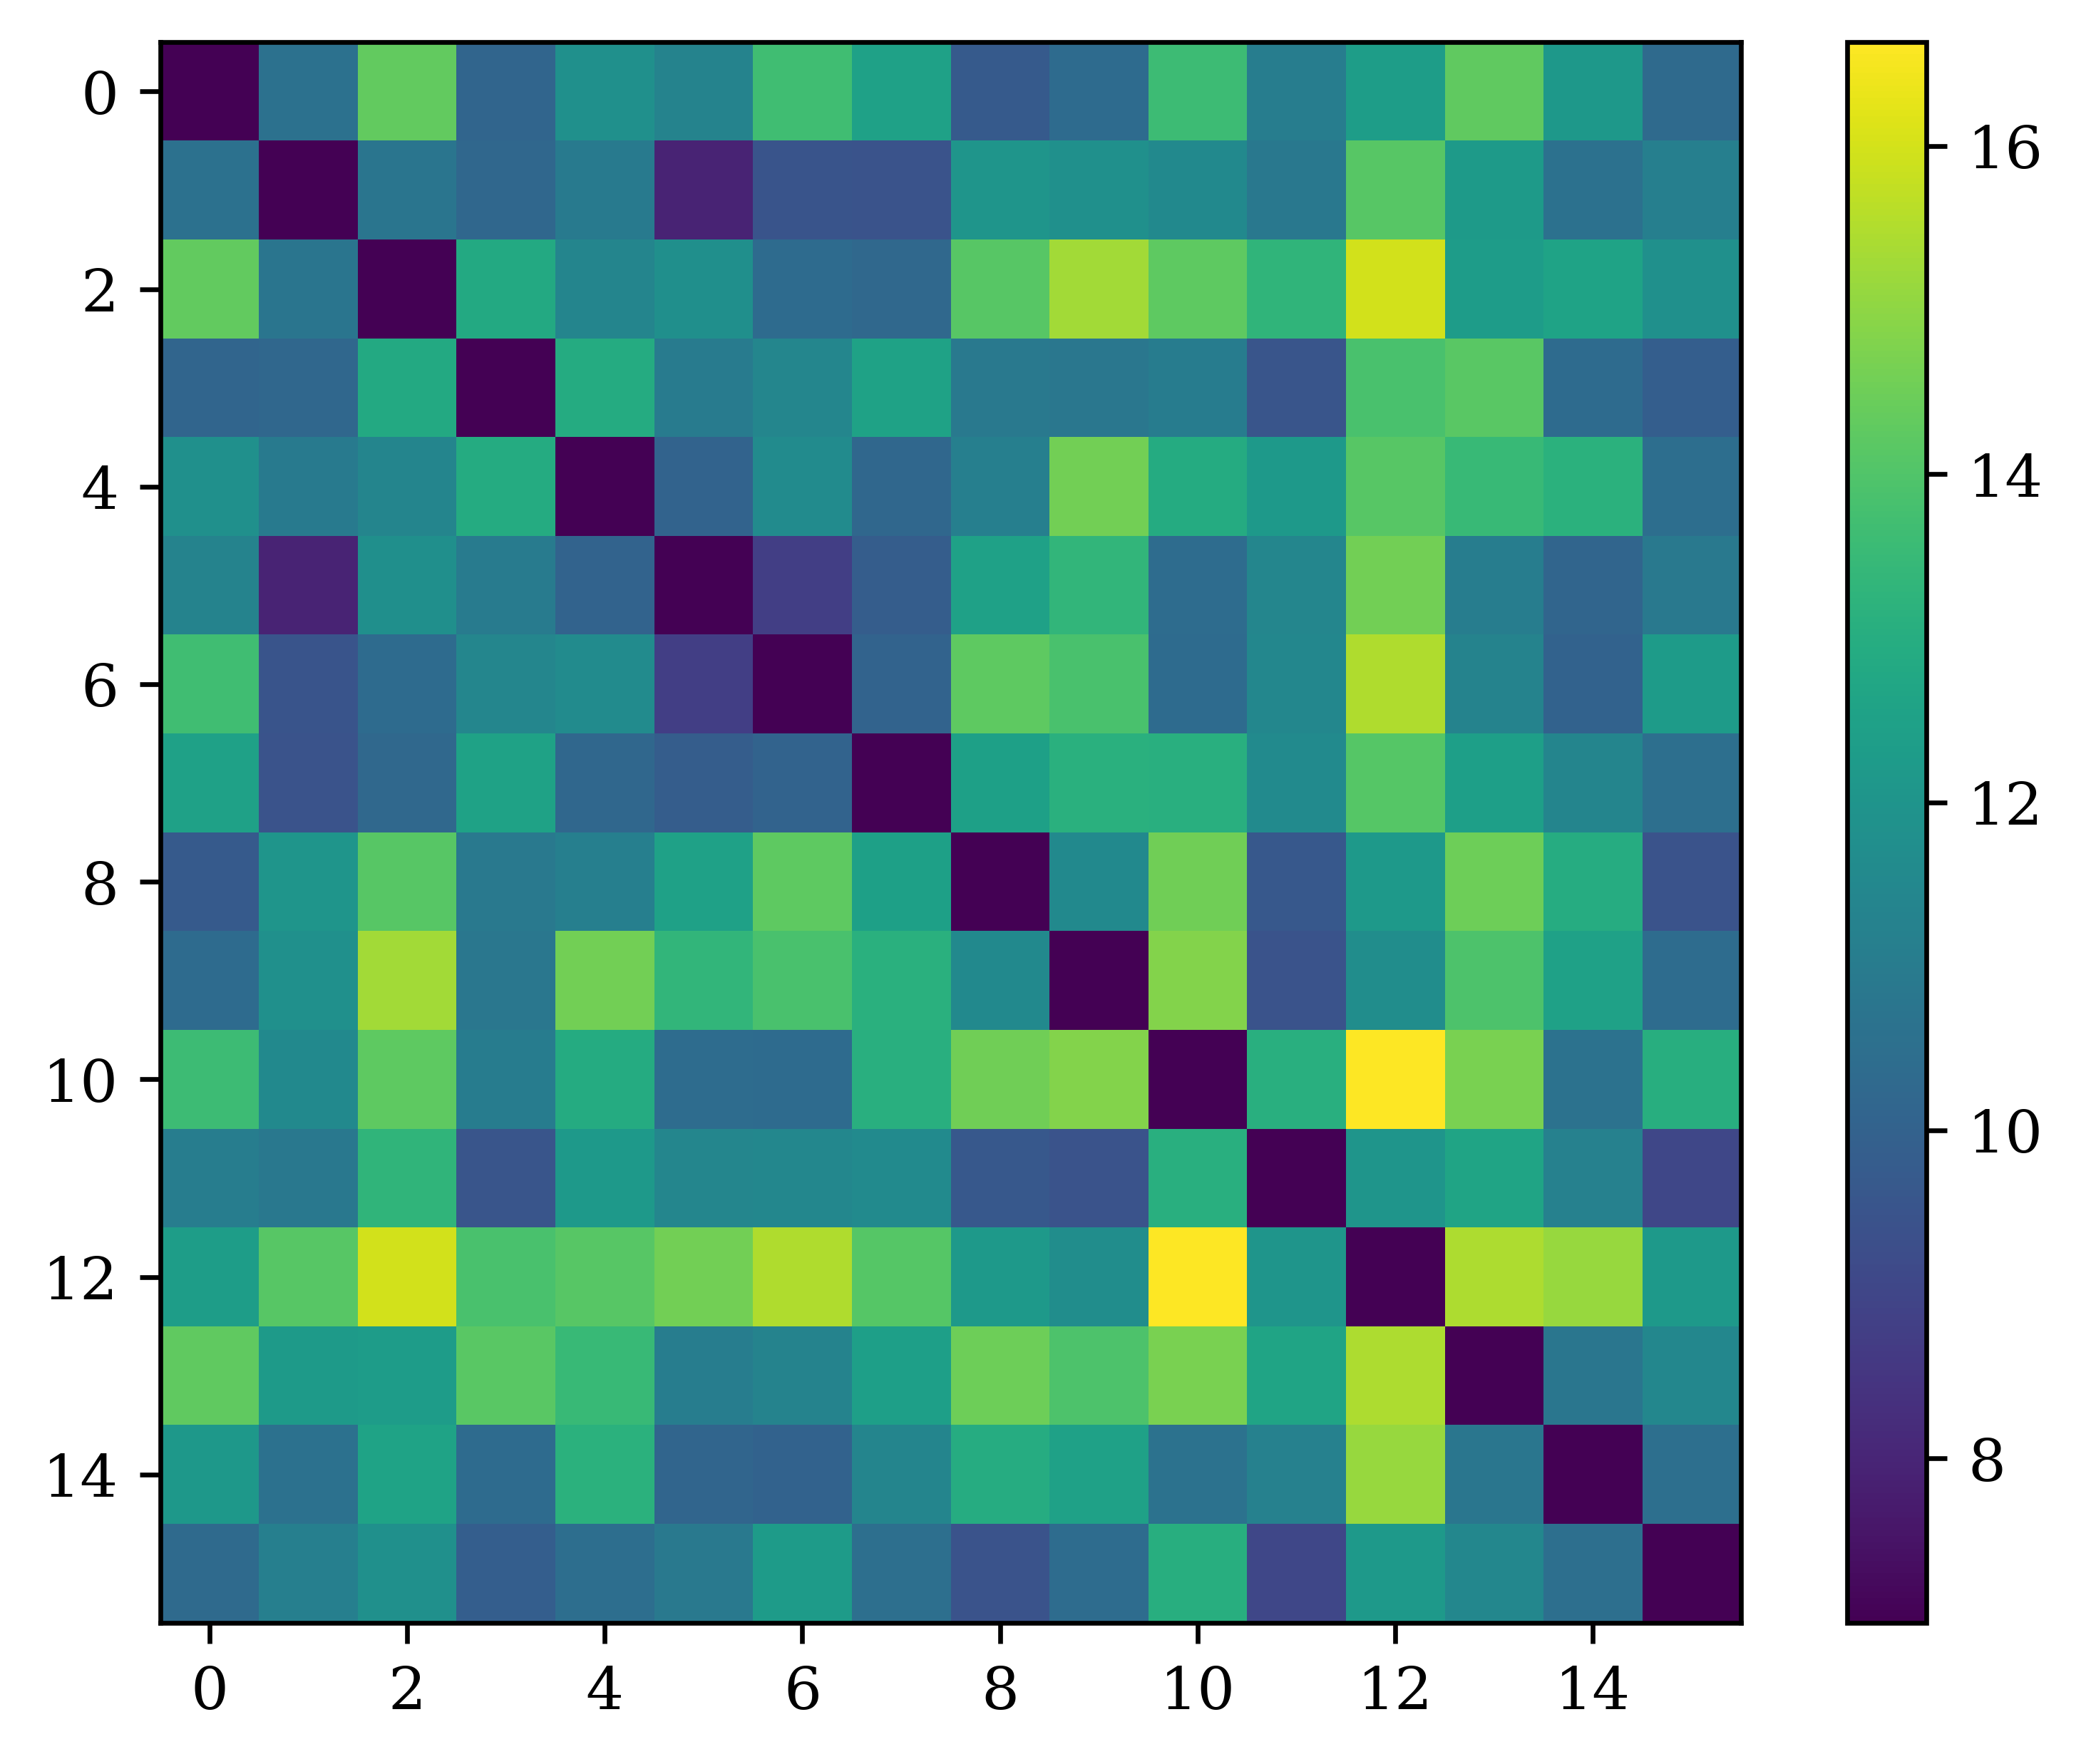

In [21]:
dynamics_similarity = pdist(all_cov, metric='euclidean')
plt.imshow(squareform(dynamics_similarity), vmin=7)
plt.colorbar()

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


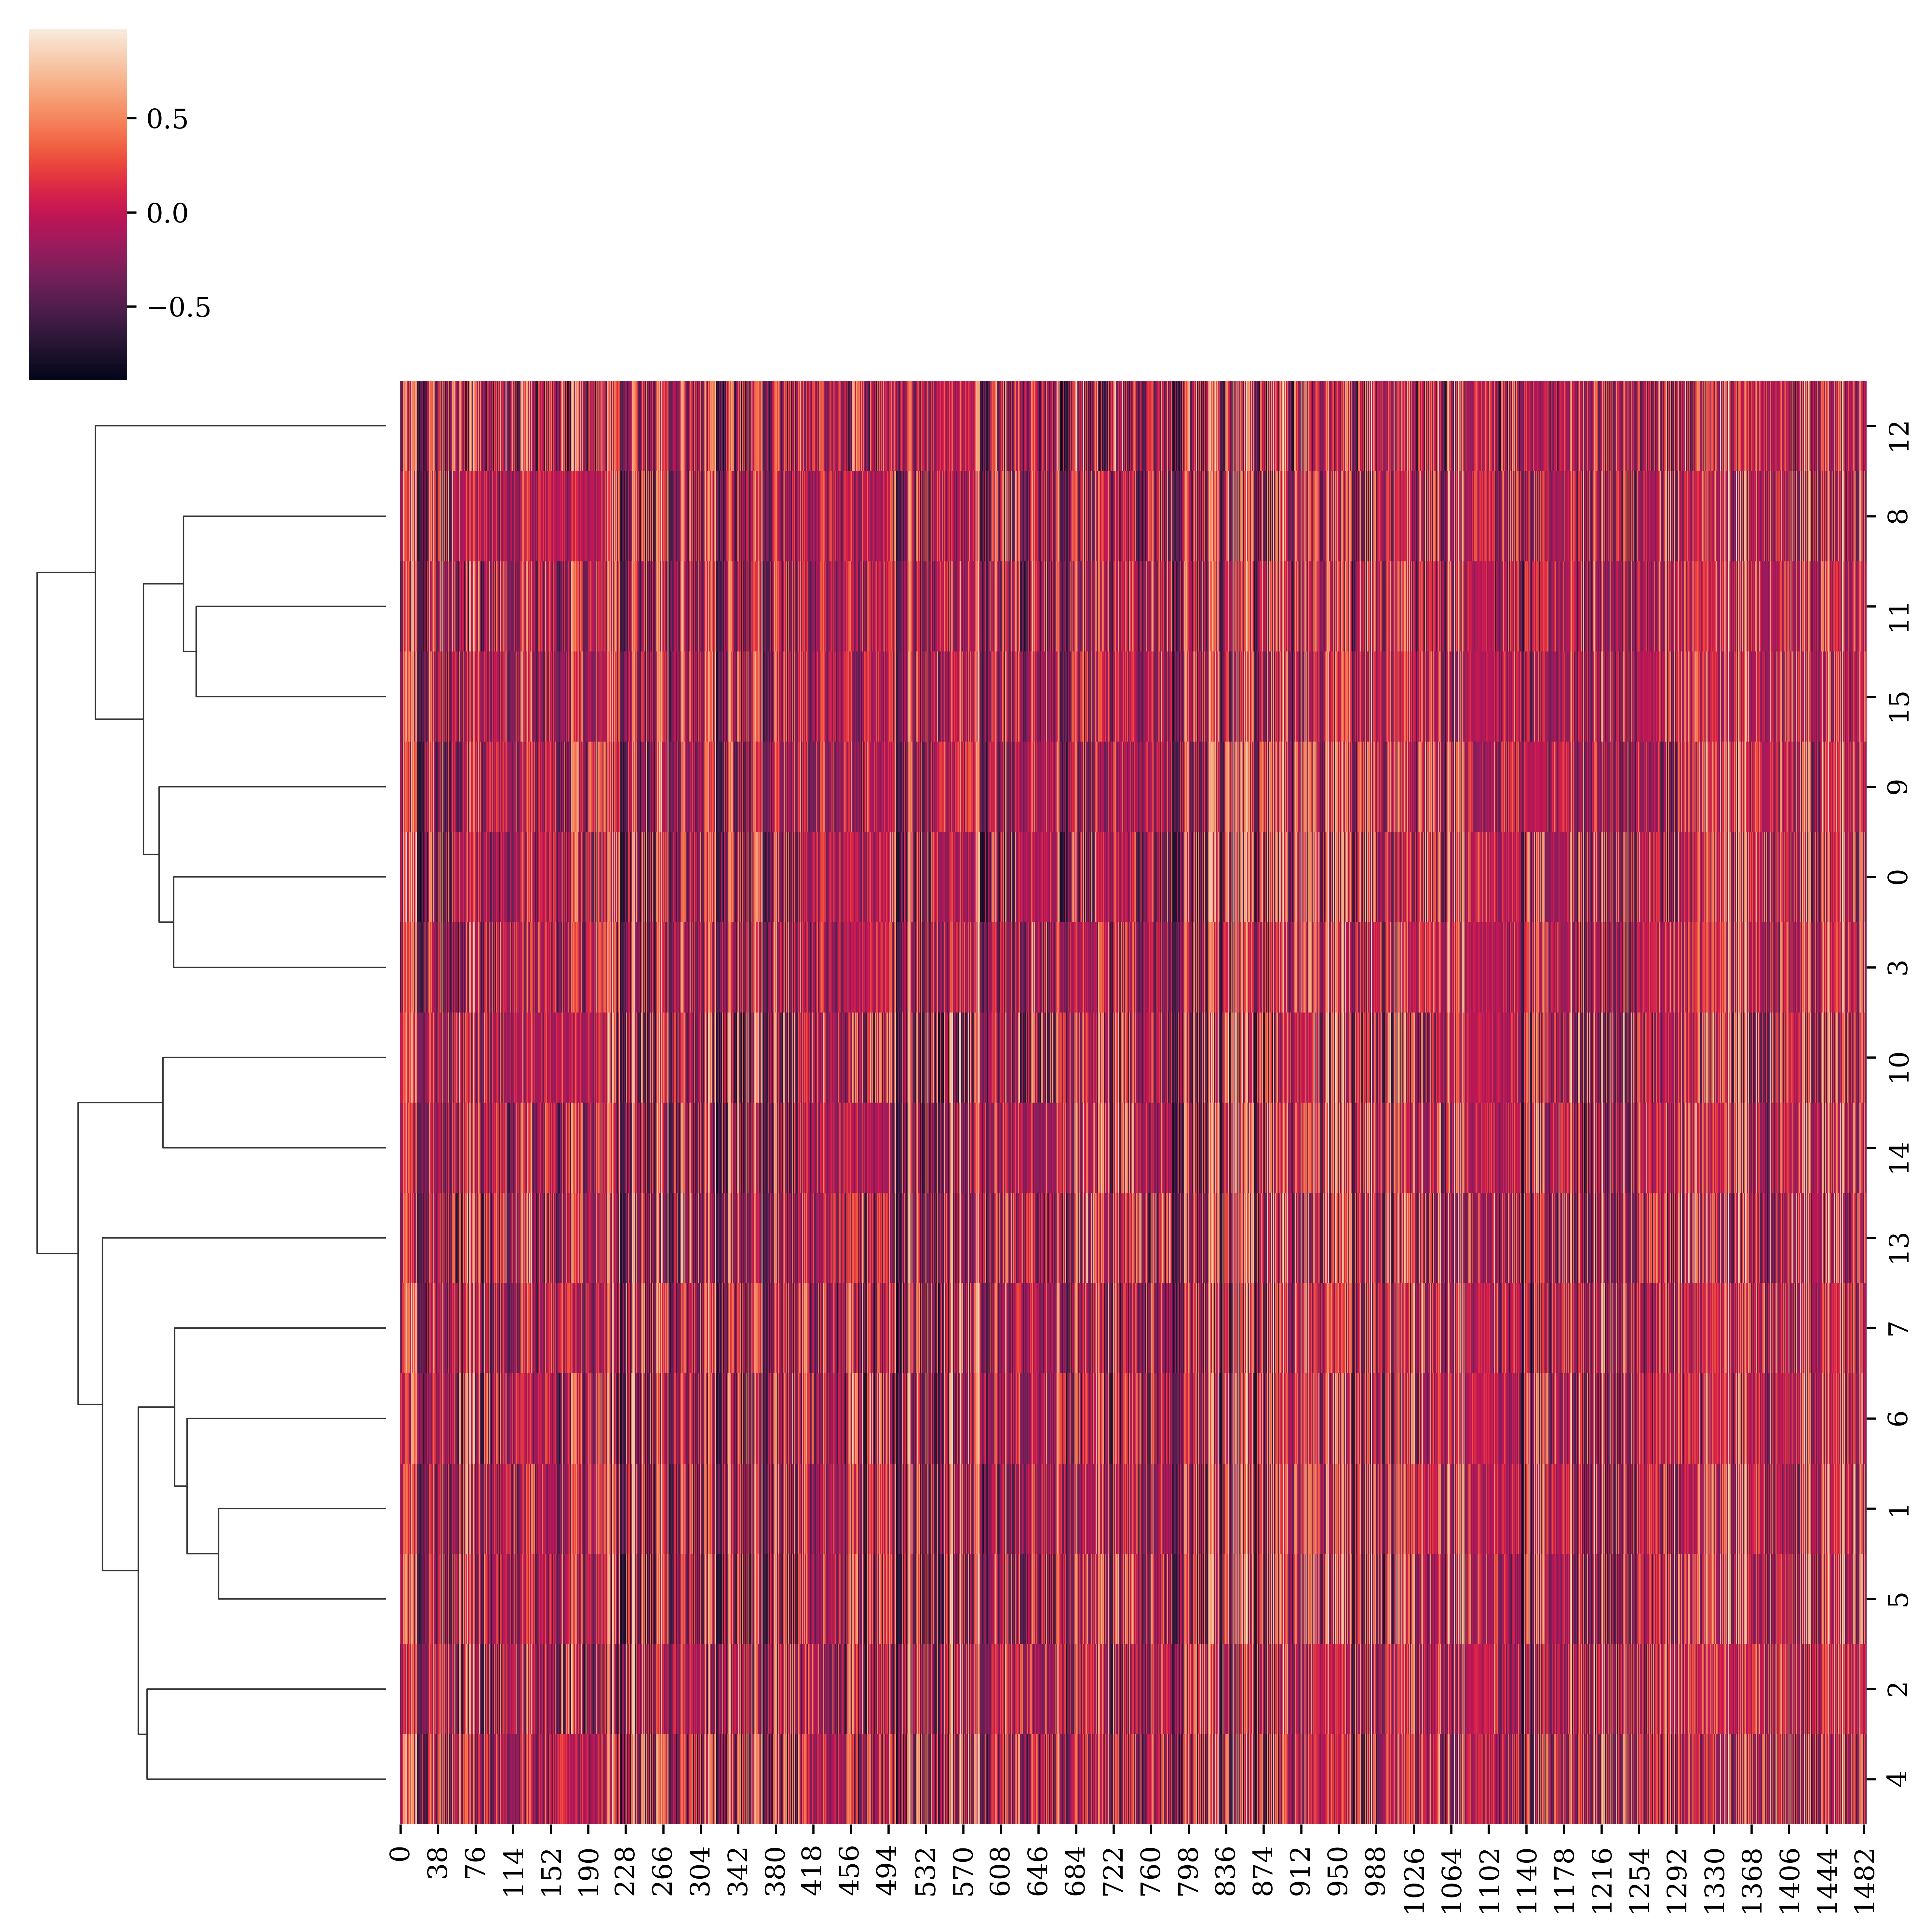

In [22]:
g = sns.clustermap(all_cov, method='complete', col_cluster=False);

In [23]:
srt = g.dendrogram_row.reordered_ind

In [24]:
srt

[12, 8, 11, 15, 9, 0, 3, 10, 14, 13, 7, 6, 1, 5, 2, 4]

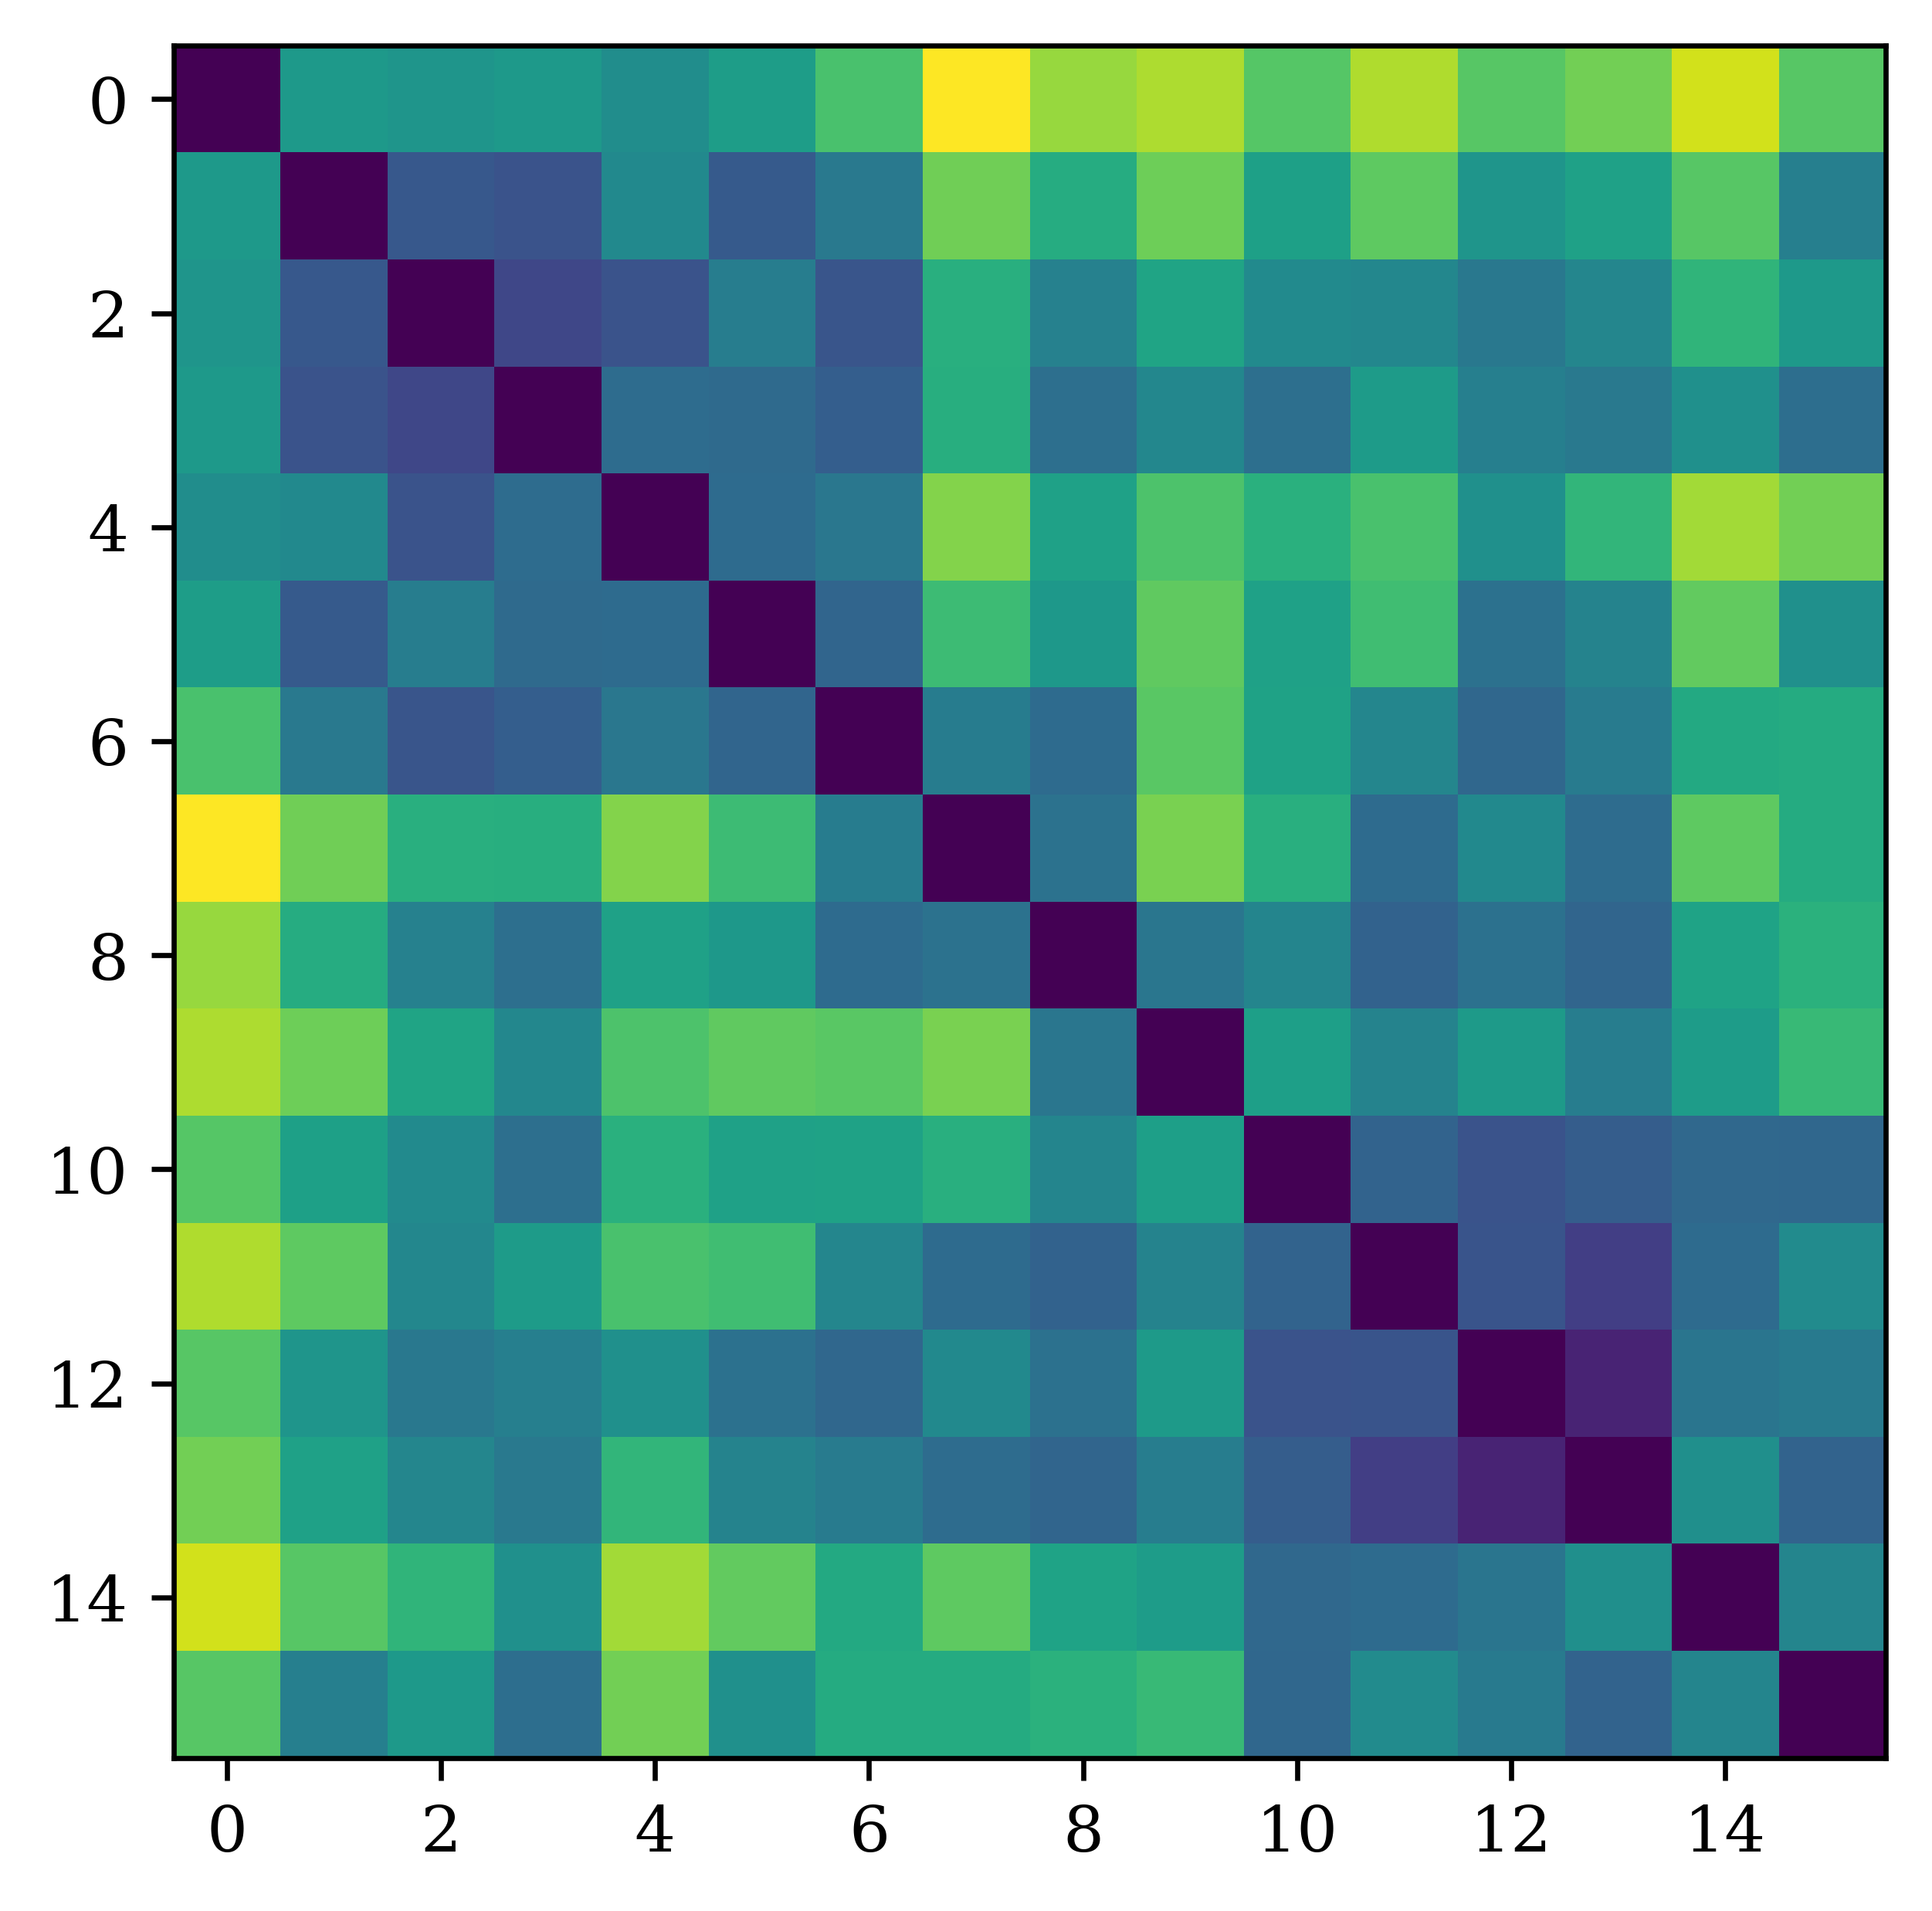

In [25]:
plt.imshow(squareform(dynamics_similarity)[srt][:, srt], vmin=7)